<a href="https://colab.research.google.com/github/E-Penguin/SpacecraftAnomalyClassification/blob/main/Direct_Classification_Image_Classification_of_Spacecraft_Anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip uninstall tsai -y
!pip install {"tsai -U" if stable else "git+https://github.com/E-Penguin/tsai.git"} >> /dev/null

!pip install optuna
import optuna

!pip install -Uqq ipdb
import ipdb
%pdb off


  Running command git clone --filter=blob:none --quiet https://github.com/E-Penguin/tsai.git /tmp/pip-req-build-fyq4wib1
Automatic pdb calling has been turned OFF


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_export = '/content/drive/MyDrive/Colab Notebooks/data/inception_model.pkl'
weights = '/content/drive/MyDrive/Colab Notebooks/data/inception_weights'
test_data_directory = '/content/drive/MyDrive/Colab Notebooks/data/SMAP_MSL/data/test'
labels = '/content/drive/MyDrive/Colab Notebooks/data/SMAP_MSL/data/labeled_anomalies.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the anomaly sequences
import pandas as pd
import numpy as np

def parse_string_list(string_list):
    # Remove the surrounding brackets
    stripped_string = string_list.strip("[]")
    # Split the string by commas
    split_strings = stripped_string.split(",")
    # Remove leading and trailing whitespace from each string
    cleaned_strings = [s.strip() for s in split_strings]
    return cleaned_strings

# Read the CSV file into a DataFrame
df_anomaly = pd.read_csv(labels)

# Iterate over each row in the DataFrame
for index, row in df_anomaly.iterrows():
    chan_id = row['chan_id']
    row['anomaly_sequences'] = eval(row['anomaly_sequences'])
    row['class'] = parse_string_list(row['class'])

print(df_anomaly.columns)

#################################################################
# Apply labels to data sets
!mkdir labelled_data

import numpy as np
import pandas as pd
import os

data_directory = test_data_directory
labelled_data = "labelled_data"

# Get a list of all .npy files in the directory
file_list = [file for file in os.listdir(data_directory) if file.endswith(".npy")]

class Anomaly:
  def __init__(self, chan_id, spacecraft, anomaly_sequences,num_values):
    self.chan_id = chan_id
    self.spacecraft = spacecraft
    self.num_values = num_values

    self.anomaly_sequences = sorted(anomaly_sequences, key=lambda x: x[0])


  def __str__(self):
   return f"{self.chan_id}, {self.spacecraft}, {self.anomaly_sequences}, {self.num_values}"

anomalies = []

# Loop through each file and load its contents into the DataFrame
for filename in file_list:
    file_path = os.path.join(data_directory, filename)
    data = np.load(file_path)

    # Create an array to store the anomaly labels
    anomaly_labels = np.zeros(len(data), dtype=int)

    # Determine the channel
    chan_id = os.path.splitext(filename)[0]

    # Load the anomaly sequences in. This fails in 1 case where there are no anomalies, so return empty array
    try:
        anomaly_sequences = eval(df_anomaly.loc[df_anomaly['chan_id'] == chan_id, 'anomaly_sequences'].values[0])
    except:
        anomaly_sequences = []

    anomaly = None

    try:
      anomaly = Anomaly(chan_id,
                      df_anomaly.loc[df_anomaly['chan_id'] == chan_id, 'spacecraft'].values[0],
                      anomaly_sequences,
                      df_anomaly.loc[df_anomaly['chan_id'] == chan_id, 'num_values'].values[0])

      anomalies.append(anomaly)

      #print(anomaly)
    except:
      print("Problem creating anomaly object for", chan_id)

    # Set anomaly labels to 1 for each anomaly sequence
    for start, end in anomaly_sequences:
        anomaly_labels[start:end + 1] = 1

    # Add the anomaly_labels as a new column to data array
    data = np.column_stack((data, anomaly_labels))

    # Write out the labelled data
    np.save(f"{labelled_data}/{chan_id}_lab.npy", data)

Index(['chan_id', 'spacecraft', 'anomaly_sequences', 'class', 'num_values'], dtype='object')
Problem creating anomaly object for T-10


In [ ]:
def get_loss_weights(y):
  # Calculate the number of occurrences for each class
  class_counts = np.bincount(y)

  # Compute weights
  max_class_count = np.max(class_counts)
  weights_np = max_class_count / class_counts

  # Apply log scaling
  weights_np = np.log(max_class_count + 1) / np.log(class_counts + 1)

  # Normalise
  weights_np = weights_np / np.sum(weights_np)

  # Convert numpy array to PyTorch tensor
  weights = torch.tensor(weights_np, dtype=torch.float32)

  return weights

def get_alpha_weights(y):
    # Calculate the number of occurrences for each class
    class_counts = np.bincount(y)

    # Total number of samples
    total_samples = len(y)

    # Compute the inverse of class frequencies
    inverse_freq = total_samples / class_counts

    # Normalizing (if you want the sum of alpha values to be 1
    inverse_freq = inverse_freq / np.sum(inverse_freq)

    # Convert numpy array to PyTorch tensor
    alpha_weights = torch.tensor(inverse_freq, dtype=torch.float32)

    return alpha_weights


In [ ]:
import inspect
from tsai.all import *

@patch
@delegates(subplots)
def get_probas(self:Learner, ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if dl is None: dl = self.dls[ds_idx]
    if one_batch: dl = [dl.one_batch()]
    probas, targets = self.get_preds(dl=dl)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = random_choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    if isinstance(probas, torch.Tensor): probas = probas.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor): targets = targets.detach().cpu().numpy()
    self.recorder = recorder
    return probas

@patch
@delegates(subplots)
def get_probas2(self:Learner, ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    if dl is None: dl = self.dls[ds_idx]
    assert dl.cat

    probas, preds = self.get_preds(dl=dl)

    return probas

In [ ]:
from tsai.all import *
from fastai.callback.all import *

class MyEarlyStoppingCallback(TrackerCallback):
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    order=TrackerCallback.order+3
    def __init__(self,
        monitor='valid_loss', # value (usually loss or metric) being monitored.
        comp=None, # numpy comparison operator; np.less if monitor is loss, np.greater if monitor is metric.
        min_delta=0., # minimum delta between the last monitor value and the best monitor value.
        patience=1, # number of epochs to wait when training has not improved model.
        reset_on_fit=True # before model fitting, reset value being monitored to -infinity (if monitor is metric) or +infinity (if monitor is loss).
    ):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        self.patience = patience

    def before_fit(self):
        self.wait = 0
        self.first_epoch = True  # Initialize the flag
        super().before_fit()

    def after_epoch(self):
        "Compare the value monitored to its best score and maybe stop training."
        # Skip metric comparison for the first epoch
        if self.first_epoch:
            print("Skipping first epoch")
            self.new_best = False
            self.first_epoch = False
            self.wait += 1
            return

        super().after_epoch()

        if self.new_best: self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f'No improvement since epoch {self.epoch-self.wait}: early stopping')
                raise CancelFitException()


In [ ]:
import math
import matplotlib.pyplot as plt
from tsai.all import *

from fastai.optimizer import OptimWrapper, SGD, RMSProp, RAdam

from fastai.callback.all import *

class FocalLossFlatWithWeights(FocalLossFlat):
  def __repr__(self):
    return "FocalLossFlatWithWeights"

##################################################
# Identify anomalies with at least n separate anomalies for a given spacecraft
def filter_anomalies(spacecraft, min_count):
  filtered_anomalies = []

  for anomaly in anomalies:
    if len(anomaly.anomaly_sequences) >= min_count and anomaly.spacecraft == spacecraft:
      filtered_anomalies.append(anomaly)

  return filtered_anomalies

###############################################
# Identify split points following this algorithm:
# 1. Divide number of anomalies evenly into train/test
#    1.1 if uneven make the train set larger
# 2. Find the mid point between the last anomaly of train and first anomaly of test
# 3. Return train/test split
def find_split_point(anomaly):
  train_anomaly_end = 0
  test_anomaly_start = 0

  if len(anomaly.anomaly_sequences) > 1:
    # Split the anomalies in two
    train_anomalies = math.ceil(len(anomaly.anomaly_sequences) / 2)

    # Get the position of the last train anomaly
    train_anomaly_end = anomaly.anomaly_sequences[train_anomalies-1][1] # From
    test_anomaly_start = anomaly.anomaly_sequences[train_anomalies][0]  # To
  else:
    # There's only one anomaly, let's split it in two
    train_anomaly_end = anomaly.anomaly_sequences[0][0] # From
    test_anomaly_start = anomaly.anomaly_sequences[0][1]  # To

  # Find the mid-point
  split_point = math.floor((train_anomaly_end + test_anomaly_start)/2)

  return split_point

# Visualise the dataset
def visualise(data, chan_id, split_point, anomaly_sequences, image_path):
  fig, ax = plt.subplots()
  fig.set_size_inches(plot_width, plot_height)

  # Plot the non-target features with transparency
  num_features = data.shape[1]
  color_map = plt.get_cmap('tab10')
  for i in range(1, num_features):
    ax.plot(data[:, i], alpha=0.2, color=color_map(i / num_features))

  # Plot the target feature
  ax.plot(data[:, 0], color='blue')

  # Apply shading for each anomaly sequence
  for anomaly_sequence in anomaly_sequences:
      start_index, end_index = anomaly_sequence
      ax.axvspan(start_index, end_index, alpha=0.3, color='red', label='Anomaly')

  # Show the split point
  plt.axvline(x=split_point, color='red', linewidth=2, linestyle='dashed')

  # Add labels, legend, etc. (customize as needed)
  ax.set_xlabel('Time Steps')
  ax.set_ylabel('Values')
  ax.set_title(f'Time Series with Anomaly Sequences {chan_id}')

  # Show the plot
  fig.tight_layout()
  plt.show()
  fig.savefig(f'{image_path}_plot.png', dpi=100)
  #fig.savefig(f'{png_directory}/telemanom_{chan_id}.png', dpi=100)
  plt.close()

def get_loss_func(y, loss_func='cel'):
  # Some loss functions
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  loss_weight = get_loss_weights(y.astype(np.int64))
  loss_weight.to(device)

  loss_function = None

  if loss_func == 'fl':
    loss_function = FocalLoss(gamma=0.5)
  elif loss_func == 'celf':
    loss_function = CrossEntropyLossFlat()
  elif loss_func == 'celf_w':
    loss_function = CrossEntropyLossFlat(weight=loss_weight.to(device))
  elif loss_func == 'cel_w':
    loss_function = torch.nn.CrossEntropyLoss(weight=loss_weight.to(device))
  elif loss_func == 'cel':
    loss_function = torch.nn.CrossEntropyLoss()
  elif loss_func == 'flf':
    loss_function = FocalLossFlat(gamma=0.5)
  elif loss_func == 'flf_w':
    loss_function = FocalLossFlat(gamma=0.5, weight=get_alpha_weights(y.astype(np.int64)).to(device))
  else:
    loss_function = torch.nn.CrossEntropyLoss()

  loss_function.to(device)

  return loss_function

def save_splits_fig(fig, image_path, chan_id):
    fig.set_figheight(fig.get_figheight()+0.5)
    fig.get_axes()[0].set_title(f"{chan_id} Split distribution")
    fig.set_layout_engine('tight')
    fig.savefig(f'{image_path}_splits.pdf')

def save_results_fig(learn, image_path, chan_id):
    metrics_fig = learn.plot_metrics()
    probas_fig = learn.show_probas()
    confusion_fig = learn.plot_confusion_matrix()

    if metrics_fig is not None:
      metrics_fig.suptitle(chan_id)
      metrics_fig.set_layout_engine('tight')
      metrics_fig.savefig(f'{image_path}_metrics.pdf')

    if probas_fig is not None:
      probas_fig.suptitle(chan_id)
      probas_fig.savefig(f'{image_path}_probas.pdf')

    if confusion_fig is not None:
      confusion_fig.set_figheight(confusion_fig.get_figheight()+0.5)
      confusion_fig.suptitle(chan_id)
      confusion_fig.savefig(f'{image_path}_confusion_matrix.pdf')

class GradientMonitor(Callback):
    def __init__(self):
        super().__init__()
        self.grads = []

    def after_backward(self):
        # Compute average gradient magnitude
        avg_grad = sum([(p.grad ** 2).mean().sqrt() for p in self.model.parameters() if p.grad is not None])
        self.grads.append(avg_grad.item())

    def plot(self):
        plt.plot(self.grads)
        plt.xlabel('Iterations')
        plt.ylabel('Average Gradient Magnitude')
        plt.title('Gradient Magnitude over Training Iterations')
        plt.show()

def get_callbacks(monitor, min_delta, patience, weights, logs, append=False):
    cbs = [MyEarlyStoppingCallback(monitor=monitor, min_delta=min_delta, patience=patience),
          SaveModelCallback(monitor=monitor, min_delta=min_delta, fname=weights),
          CSVLogger(fname=f"{logs}_log.csv", append=append),
          ReduceLROnPlateau(monitor=monitor),
          GradientMonitor()]#,
          #tsai.data.mixed_augmentation.CutMix1d()]

    return cbs

def get_metrics():
  return [F1Score(),accuracy, Precision(), Recall()]

def y_max(o):
  return np.max(o, axis=1)

def get_X_y(data, window_length):
  # Args to SlidingWindow
  stride = window_length # no overlap
  horizon = None
  get_x = list(np.arange(data.shape[1]-1))
  get_y = data.shape[1]-1
  seq_first = True
  random_start = 0

  # Apply sliding window
  X,y = SlidingWindow(window_length, get_x = get_x, get_y=get_y, y_func=y_max)(data)

  return X,y

def get_dls(X, y, splits, bs, inv_splits):
  tfms = [None, TSClassification()]
  batch_tfms = []
  #batch_tfms = [TSNormalize(), TSToGASF(224)]
  dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
  dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, bs=bs)

  # Swap test/train sets if needed
  if inv_splits == True:
    print("Swapping test/train")
    train_ds, valid_ds = dls.train_ds, dls.valid_ds
    dls = TSDataLoaders.from_dsets(valid_ds, train_ds, batch_tfms=batch_tfms, bs=bs)

  return dls

def get_splits_from_data(y, valid_size, seed, generate_figs, image_path, chan_id):
  if generate_figs == True:
    splits,fig = get_splits(y, valid_size=valid_size, stratify=True, random_state=seed, shuffle=False, return_figure=True, show_plot=True)
    save_splits_fig(fig, image_path, chan_id)
  else:
    splits = get_splits(y, valid_size=valid_size, stratify=True, random_state=seed, shuffle=False, return_figure=False, show_plot=False)

  return splits

def get_results_from_learner(learn, thr = 0.5):
  # Evaluate model
  f1 = learn.validate()[1]

  # Get the predictions
  probas = learn.get_probas()
  probas2 = learn.get_probas2()
  preds = (probas2.numpy()[:, 1] > thr).astype(int)

  return probas, preds, probas2, f1

# Custom optimizer settings
def lookahead_lamb_opt(params, lr=1e-04, **kwargs):
    base_optimizer = Lamb(params, lr=lr, mom=0.9, sqr_mom=0.99, eps=1e-8, wd=1e-2, decouple_wd=True)
    return Lookahead(base_optimizer)

def lamb_opt(params, lr=1e-04, **kwargs):
    lamb = Lamb(params, lr=lr, mom=0.9, sqr_mom=0.99, eps=1e-8, wd=1e-2, decouple_wd=True)
    return lamb

def get_optimiser(opt='default'):
    if opt == 'lookahead_lamb':
        return lookahead_lamb_opt
    elif opt == 'lamb':
        return lamb_opt
    elif opt == 'sgd':
        return SGD
    elif opt == 'adamw':
        return partial(Adam, wd=1e-2, decouple_wd=True)  # Adjust Adam for AdamW behavior.
    elif opt == 'rmsprop':
        return RMSProp
    elif opt == 'radam':
        return RAdam
    elif opt == 'default' or opt == 'adam':
        return Adam

def prep_data(data, window_length, split_point, seed, generate_figs, bs, inv_splits, image_path, chan_id):
  X,y = get_X_y(data, window_length)
  valid_size = (len(data)-split_point)
  splits = get_splits_from_data(y, valid_size, seed, generate_figs, image_path, chan_id)
  dls = get_dls(X, y, splits, bs, inv_splits)
  return dls,y

def create_learner_model(dls, model, metrics=None, train_metrics=False, seed=42,
                   verbose=False, opt_func=Adam, pretrained=False, weights_path=None, fusion_layers=128, fusion_dropout=0):
  this_model = create_model(model, dls=dls, fusion_layers=fusion_layers, fusion_dropout=fusion_dropout,
                       pretrained=pretrained, weights_path=weights_path)

  learn = Learner(dls, this_model, metrics=metrics, opt_func=opt_func)

  return learn

def create_learner(dls, arch='InceptionTime', arch_config={}, metrics=None, train_metrics=False, seed=42,
                   verbose=False, opt_func=Adam, pretrained=False, weights_path=None, fusion_layers=128, fusion_dropout=0):
  learn = ts_learner(dls, arch=arch, arch_config=arch_config, metrics=metrics, train_metrics=False, seed=seed,
                     verbose=False, opt_func=opt_func, pretrained=pretrained, weights_path=weights_path,
                     fusion_layers=fusion_layers, fusion_dropout=fusion_dropout)
  return learn

def run_learner(learn, y, epochs, lr_max=1e-4, cbs=None, loss_func='cel', verbose=True):
    start = time.time()

    learn.loss_func = get_loss_func(y, loss_func)

    if verbose == True:
      learn.fit_one_cycle(epochs, lr_max=lr_max, cbs=cbs)
      print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
    else:
      with learn.no_bar(), learn.no_logging(): learn.fit_one_cycle(epochs, lr_max=lr_max, cbs=cbs)

def get_side(inv_splits=False):
  side = ''
  if inv_splits == True:
    side = '_b'
  return side

def get_paths(data_path='', inv_splits=False, arch=None):
  side = get_side(inv_splits)
  model_export = f"{data_path}/models/{arch}_model_{anomaly.chan_id}{side}.pkl"
  weights = f"{data_path}/weights/{arch}_weights_{anomaly.chan_id}{side}"
  image_path = f"{data_path}/img/{arch}_{anomaly.chan_id}{side}"
  logs = f"{data_path}/logs/{arch}_{anomaly.chan_id}{side}"

  return model_export,weights,image_path,logs

def compute_batch_size(l):
  bs = 1
  while bs < l and bs < 1024:
      bs *= 2
  return min(bs, 1024)

def get_one_batch(data, window_length, split_point, seed, bs):
  dls,y = prep_data(data, window_length, split_point, seed, False, bs, inv_splits=False, image_path=None, chan_id=None)

  xb, yb = dls.train.one_batch()
  return xb

def run_model(data, data_path, arch=None, arch_config=None, model=None, chan_id=None, load_weights=False, thr=0.5, generate_figs=False, lr_max = 1e-3, window_length=64, bs=64,
              split_point=0, inv_splits=False, epochs=35, patience=10, min_delta=0.001, monitor='f1_score', seed=42, optimiser='adam', loss_func='cel',
              fusion_layers=128, fusion_dropout=0, verbose=True, pretrained=False):
  print(f'############# CHAN_ID = {chan_id} #############')

  # Work out paths for input/outputs
  model_export,weights,image_path,logs = get_paths(data_path=data_path, inv_splits=inv_splits, arch=arch)

  # Prep data
  dls,y = prep_data(data, window_length, split_point, seed, generate_figs, bs, inv_splits, image_path, chan_id)

  # Configure metrics
  metrics = get_metrics()

  # Create the learner
  learn = create_learner(dls, arch=arch, arch_config=arch_config, metrics=metrics, train_metrics=False,
                        seed=seed, verbose=False, opt_func=get_optimiser(opt=optimiser),
                        fusion_layers=fusion_layers, fusion_dropout=fusion_dropout, pretrained=pretrained)

  # Load our saved weights
  if load_weights:
    try:
      learn.load(weights)
    except:
      print('Could not load weights from', weights)
      load_weights = False

  if load_weights == False:
    # Get the callbacks
    cbs = get_callbacks(monitor, min_delta, patience, weights, logs)

    # Run the learner
    run_learner(learn, y, epochs, lr_max=lr_max, cbs=cbs, loss_func=loss_func, verbose=verbose)

  if generate_figs == True and load_weights == False: save_results_fig(learn, image_path, chan_id)

  # save to gdrive
  learn.export(model_export)

  # Return results
  return get_results_from_learner(learn, thr)

#################################################################################################


In [ ]:
# Print stats
def count_sequences_left_of_split_np(sequences, split_point):
    # Convert the list of sequences to a numpy array
    sequences_np = np.array(sequences)
    # Count sequences where the end is less than the split point
    count = np.sum(sequences_np[:, 1] < split_point)
    return count

def count_sequences_right_of_split_np(sequences, split_point):
    # Convert the list of sequences to a numpy array
    sequences_np = np.array(sequences)
    # Count sequences where the end is less than the split point
    count = np.sum(sequences_np[:, 1] >= split_point)
    return count

# SMAP
data_path = f"/content/drive/MyDrive/Colab Notebooks/data"
filtered_anomalies = filter_anomalies("MSL", 2)

# Let's do some machine learning!
data_path = f"/content/drive/MyDrive/Colab Notebooks/data"

import math

sum_training = 0
sum_testing = 0
sum_training_win = 0
sum_testing_win = 0

for anomaly in filtered_anomalies:
    # Find a sensible split point according to our criteria
    split_point = find_split_point(anomaly)

    # Load the data
    file_path = os.path.join(labelled_data, f'{anomaly.chan_id}_lab.npy')
    data = np.load(file_path)

    print(anomaly.chan_id, "&", count_sequences_left_of_split_np(anomaly.anomaly_sequences, split_point),"&", data.shape[1], "\\(\\times\\)", split_point, "&", math.ceil(split_point/64), "&", count_sequences_right_of_split_np(anomaly.anomaly_sequences, split_point),"&",  data.shape[1], "\\(\\times\\)", anomaly.num_values - split_point, "&", math.ceil((anomaly.num_values - split_point)/64), "\\\\" )

    sum_training += split_point
    sum_testing += anomaly.num_values - split_point
    sum_training_win += math.ceil(split_point/64)
    sum_testing_win += math.ceil((anomaly.num_values - split_point)/64)

print(sum_training, sum_testing, sum_training_win, sum_testing_win)

C-1 & 1 & 56 \(\times\) 1425 & 23 & 1 & 56 \(\times\) 839 & 14 \\
D-14 & 1 & 56 \(\times\) 1725 & 27 & 1 & 56 \(\times\) 900 & 15 \\
C-2 & 1 & 56 \(\times\) 965 & 16 & 1 & 56 \(\times\) 1086 & 17 \\
F-7 & 2 & 56 \(\times\) 3057 & 48 & 1 & 56 \(\times\) 1997 & 32 \\
P-11 & 1 & 56 \(\times\) 1561 & 25 & 1 & 56 \(\times\) 1974 & 31 \\
T-13 & 1 & 56 \(\times\) 1345 & 22 & 1 & 56 \(\times\) 1085 & 17 \\
T-8 & 1 & 56 \(\times\) 1130 & 18 & 1 & 56 \(\times\) 389 & 7 \\
T-9 & 1 & 56 \(\times\) 850 & 14 & 1 & 56 \(\times\) 246 & 4 \\
12058 8516 193 137


T-3
Batch T-3 0
Batch T-3 1
Batch T-3 2
Batch T-3 3
Batch T-3 4
Batch T-3 5
Batch T-3 6
Batch T-3 7
Batch T-3 8
Batch T-3 9
Batch T-3 10
Batch T-3 11
Batch T-3 12
Batch T-3 13
Batch T-3 14
Batch T-3 15
Batch T-3 16
Batch T-3 17
Batch T-3 18
Batch T-3 19
Batch T-3 20
Batch T-3 21
Batch T-3 22
Batch T-3 23
Batch T-3 24
Batch T-3 25
Batch T-3 26
Batch T-3 27
Batch T-3 28
Batch T-3 29
Batch T-3 30
Batch T-3 31
Batch T-3 32
Batch T-3 33
Batch T-3 34
Batch T-3 35
Batch T-3 36
Batch T-3 37
Batch T-3 38
Batch T-3 39


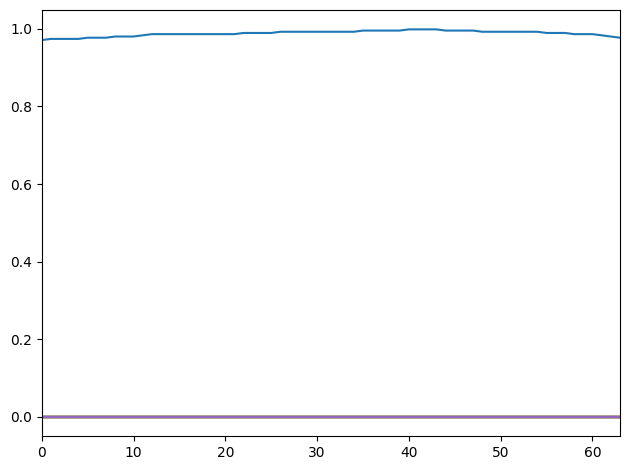

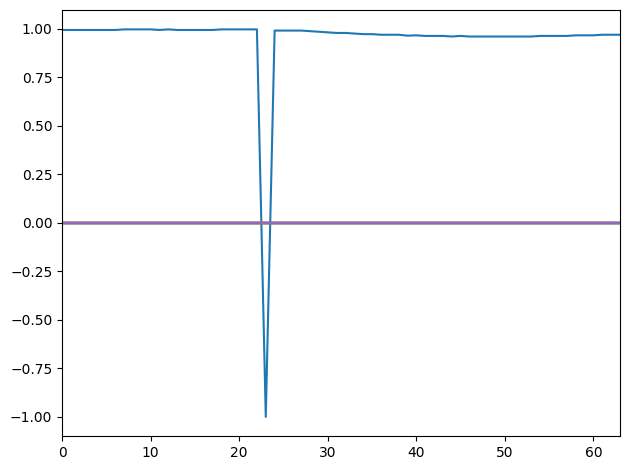

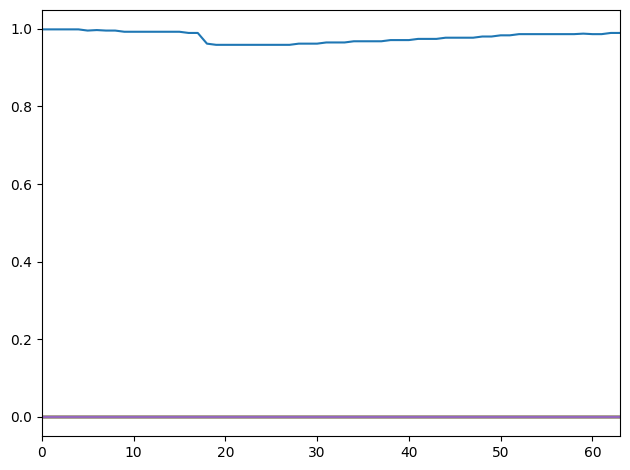

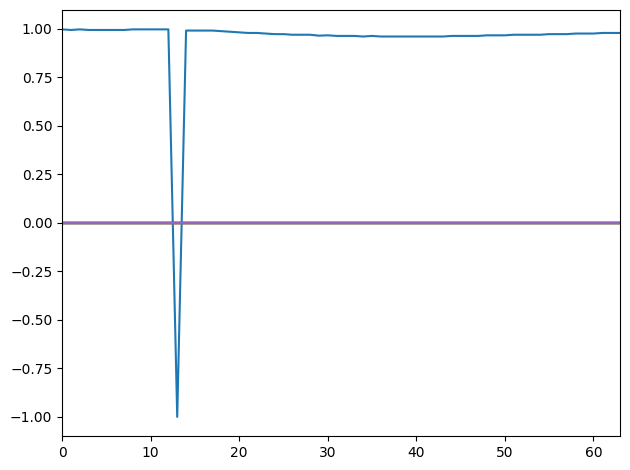

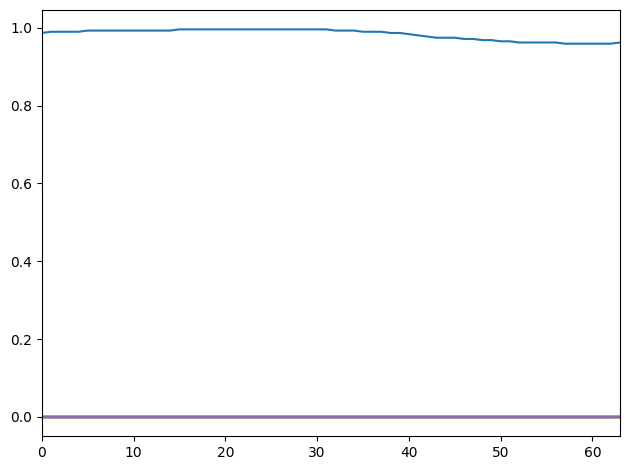

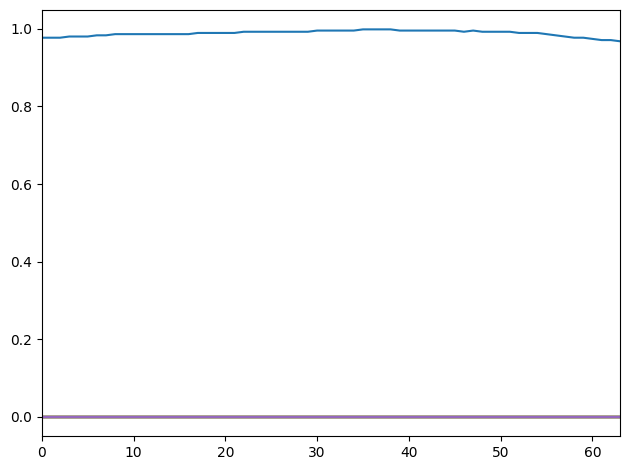

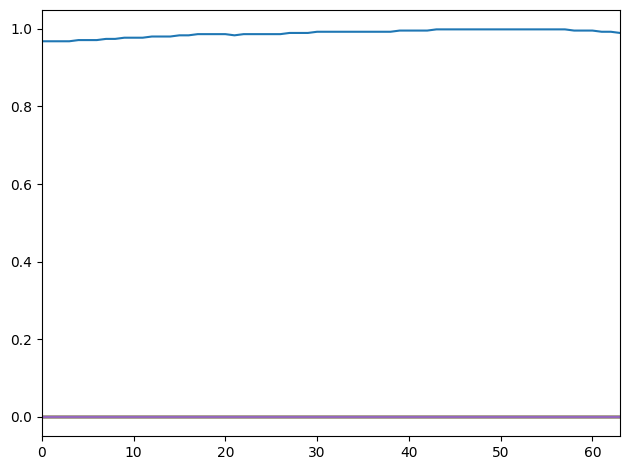

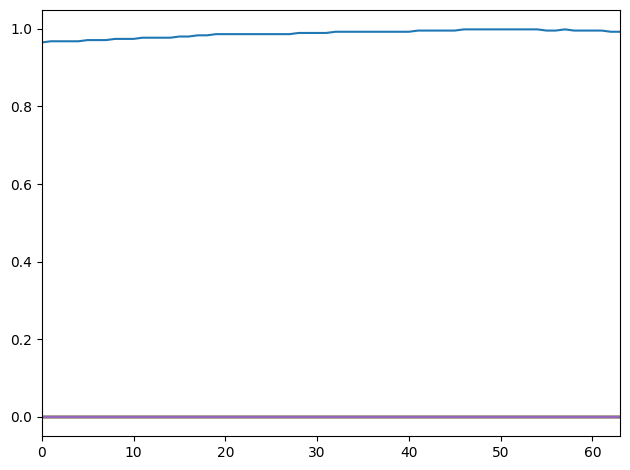

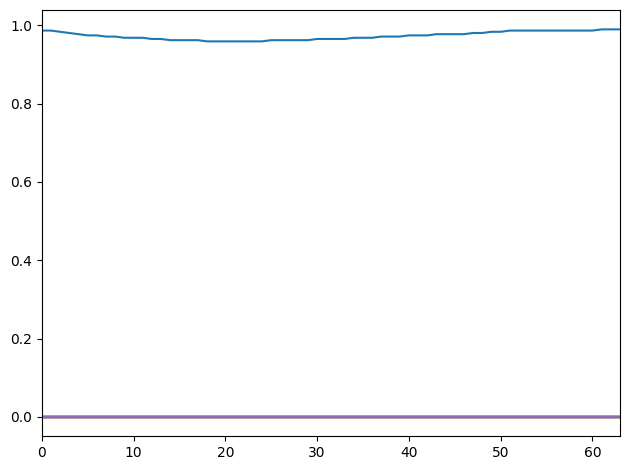

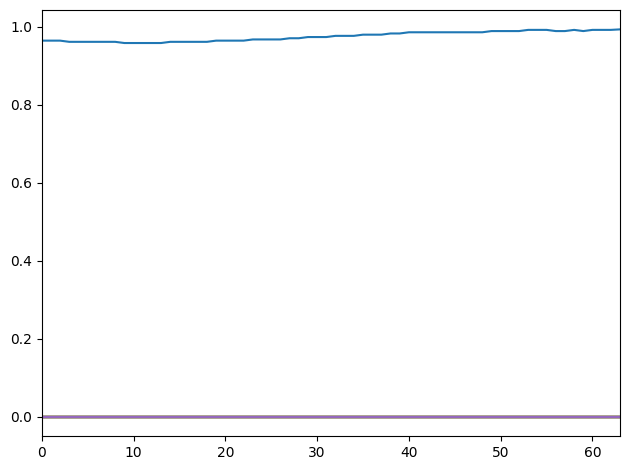

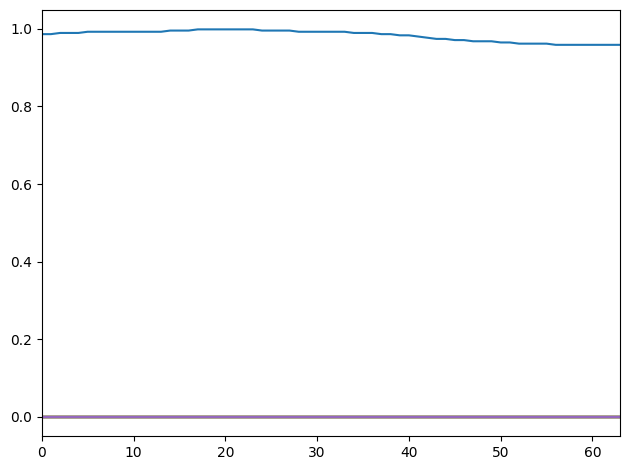

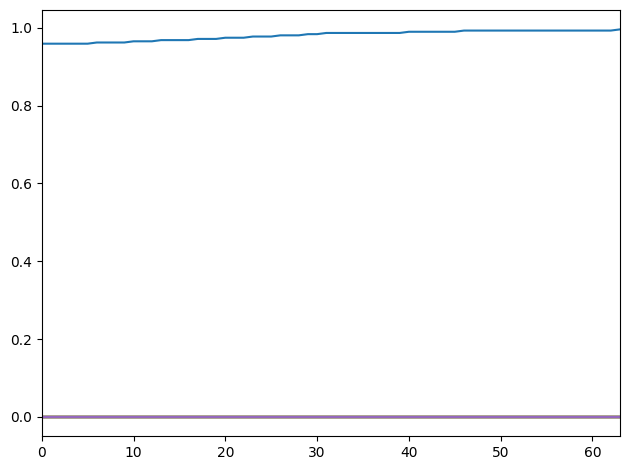

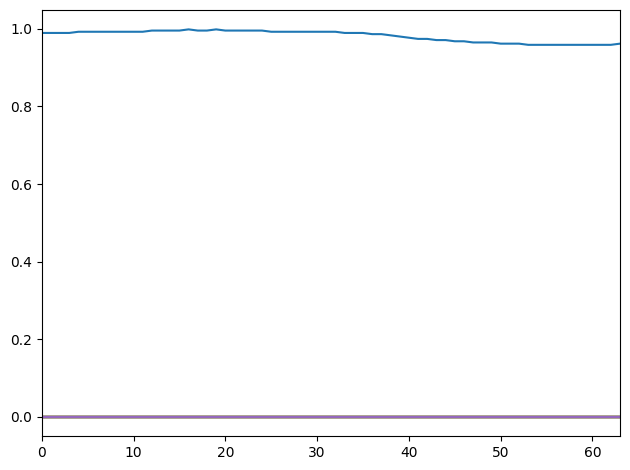

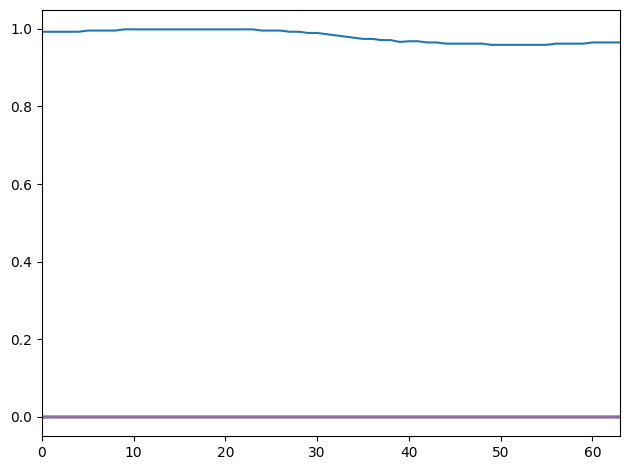

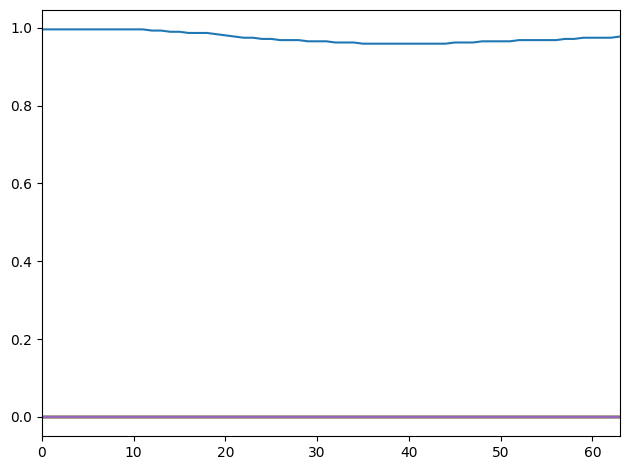

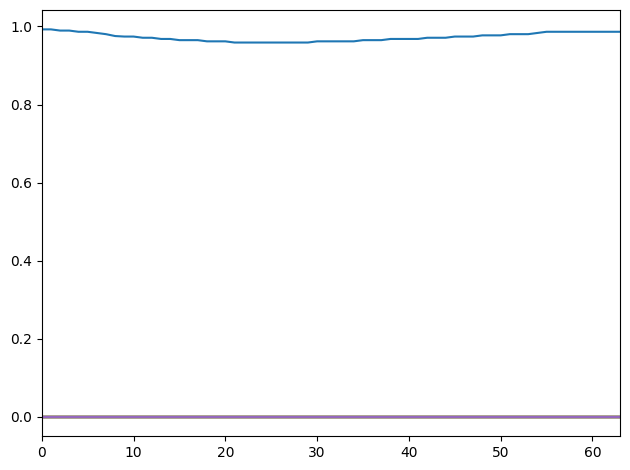

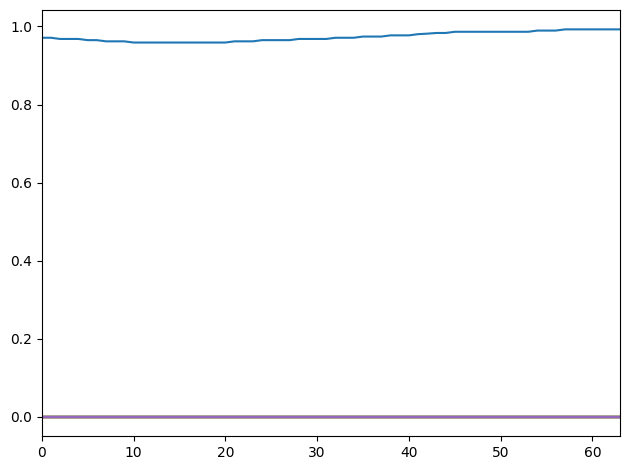

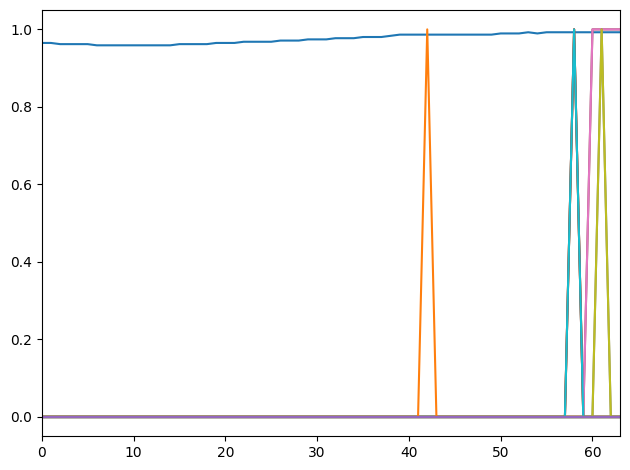

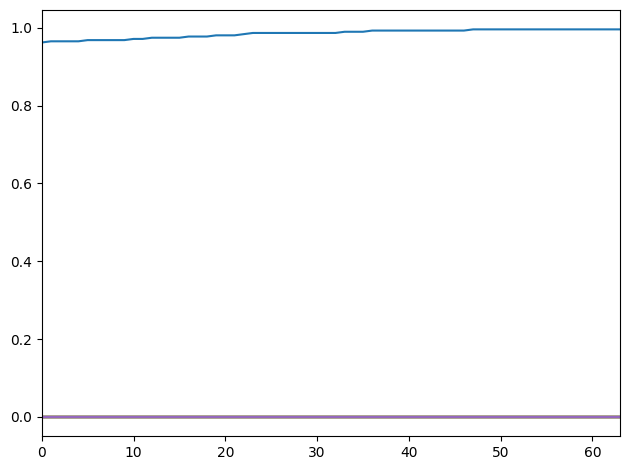

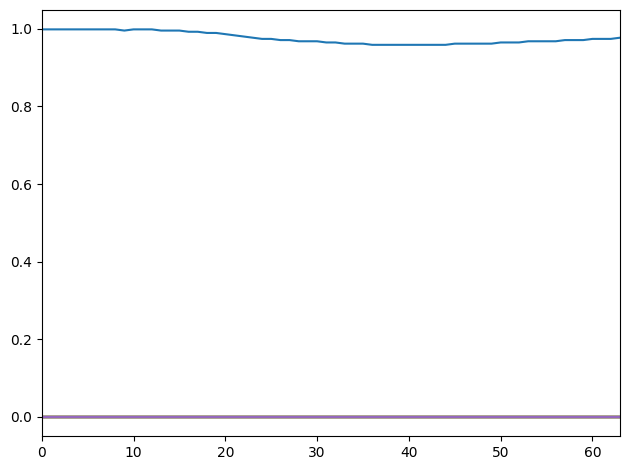

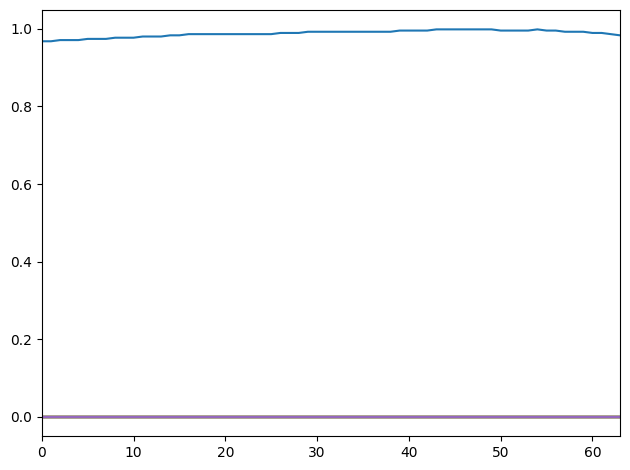

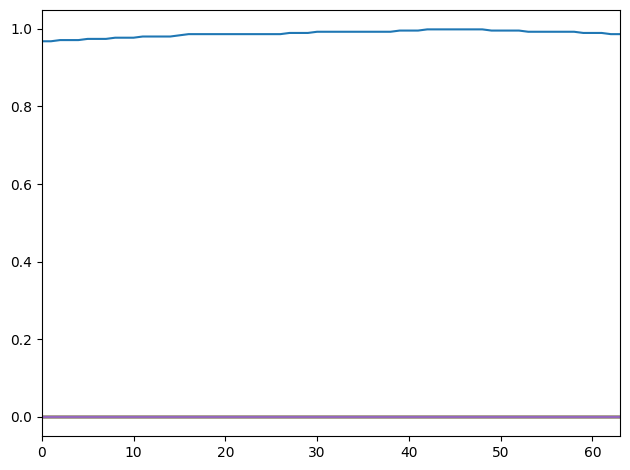

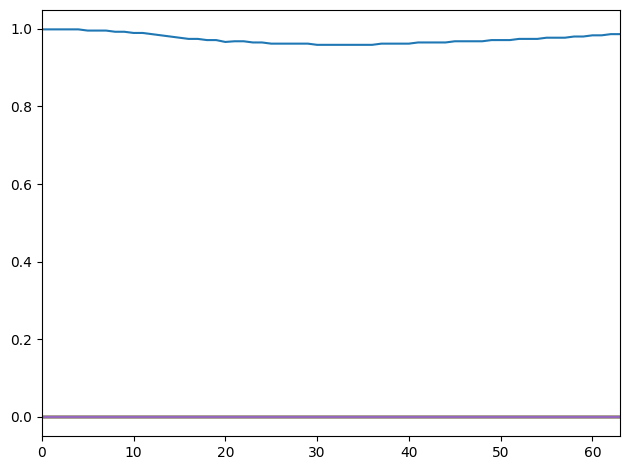

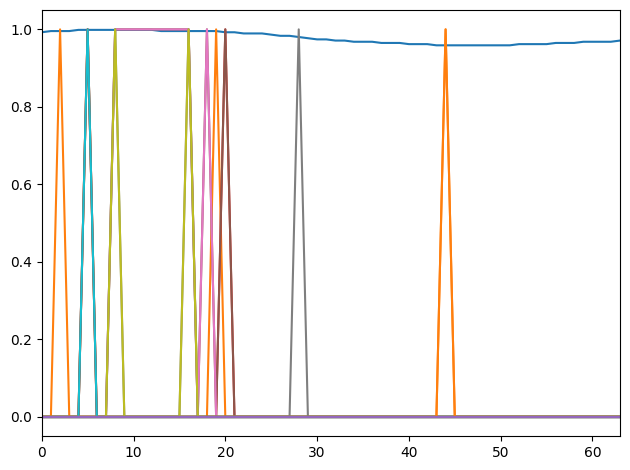

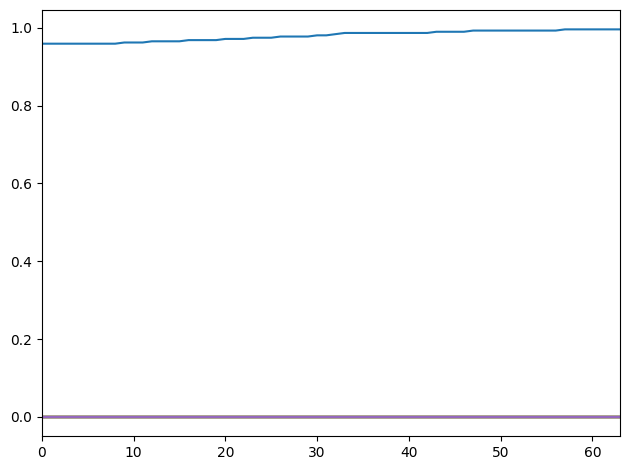

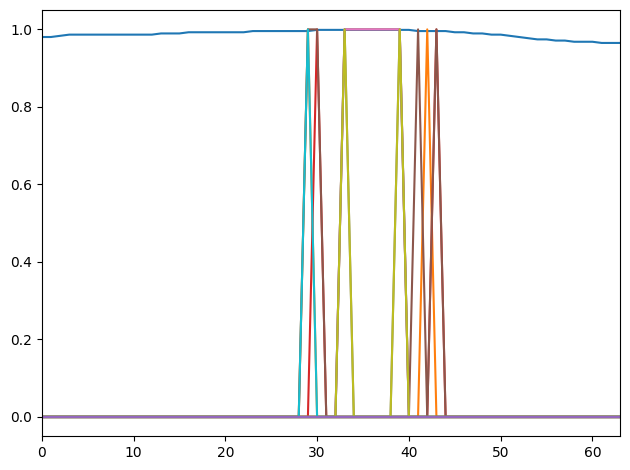

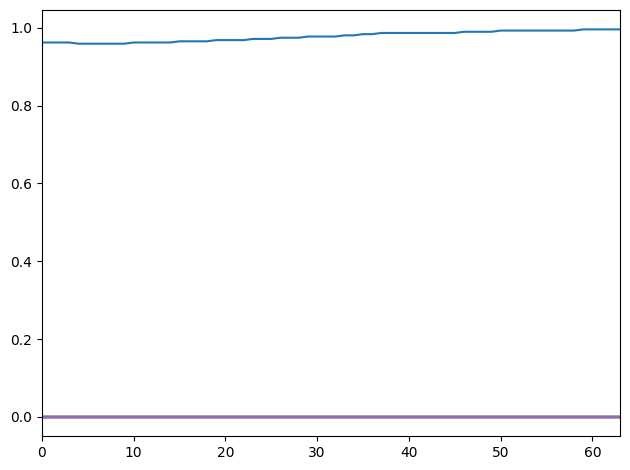

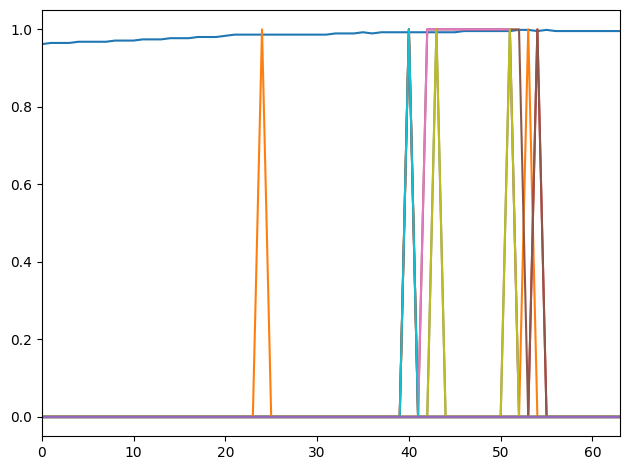

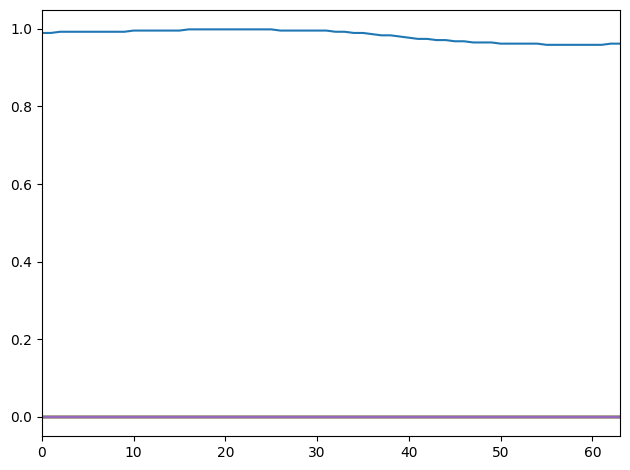

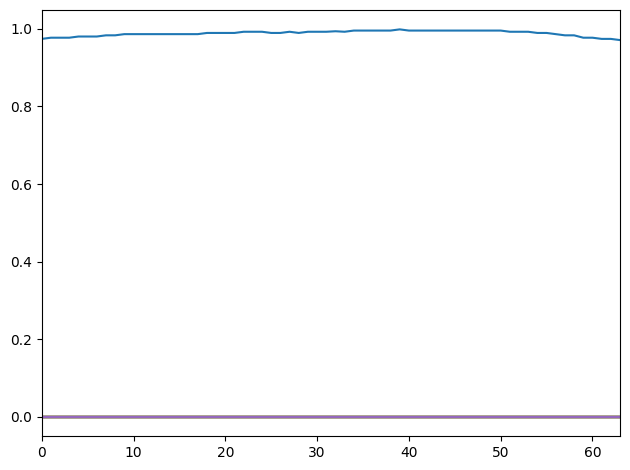

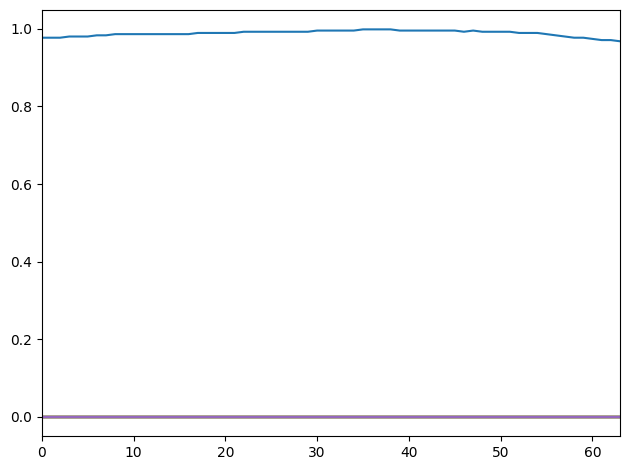

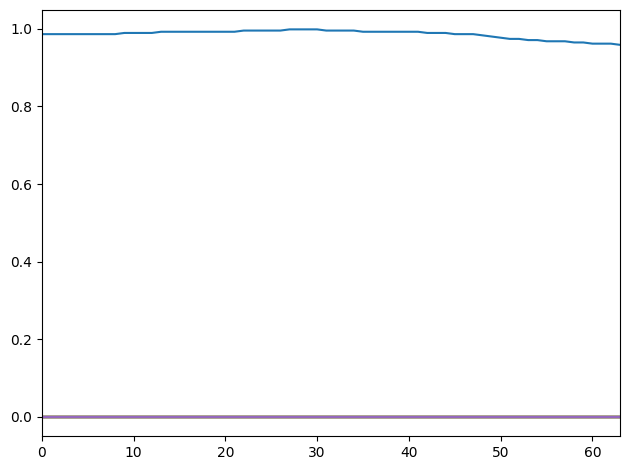

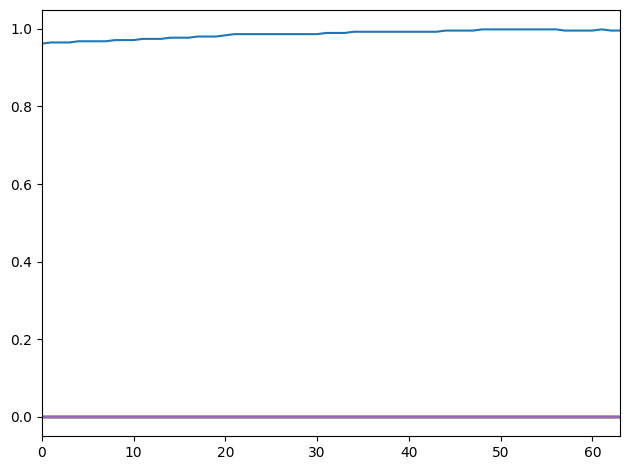

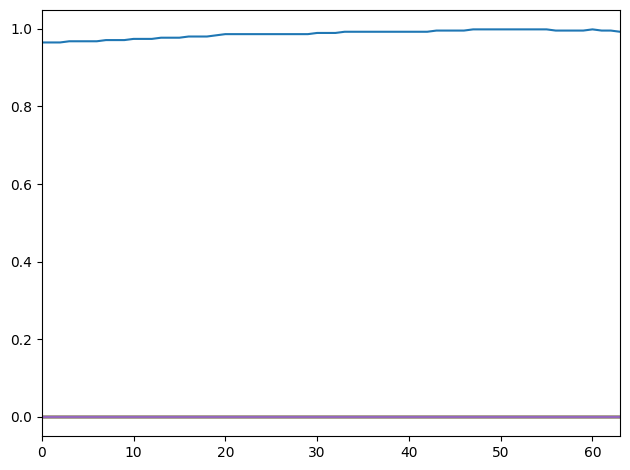

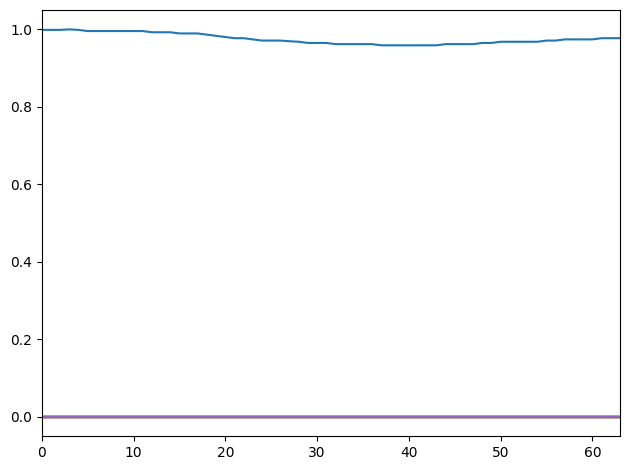

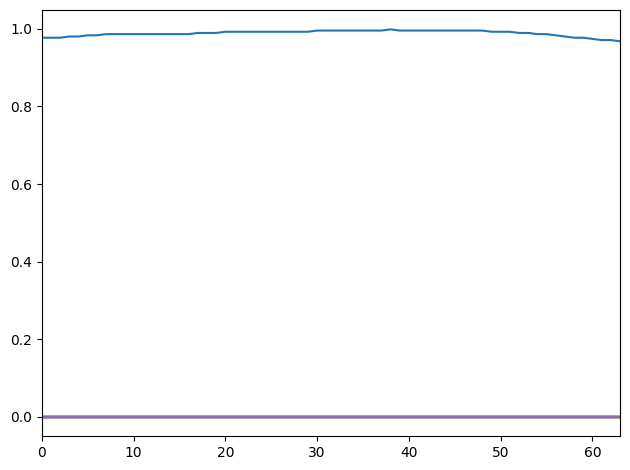

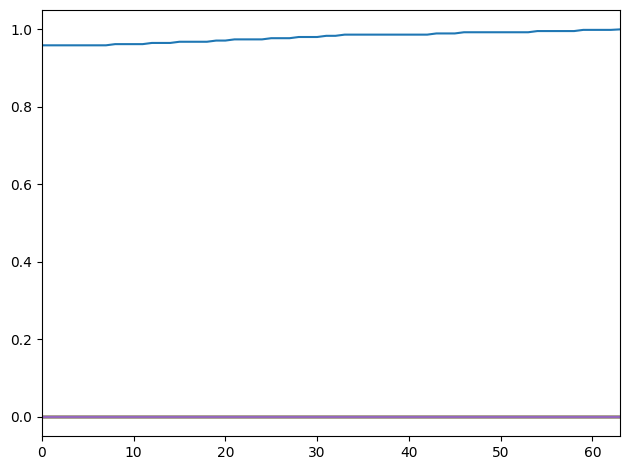

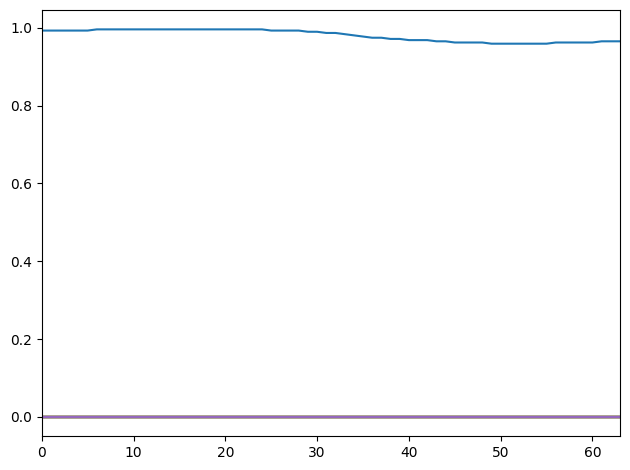

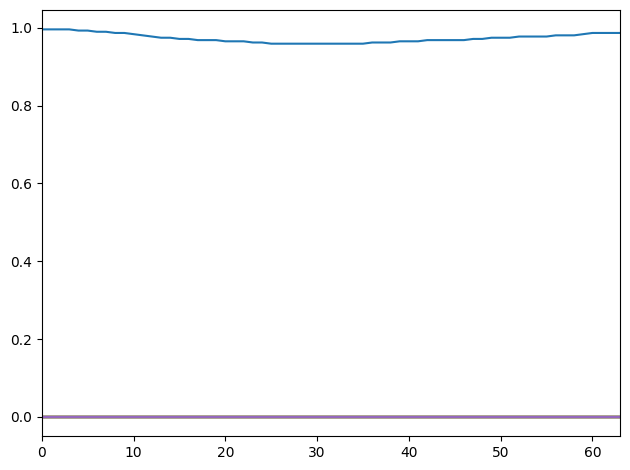

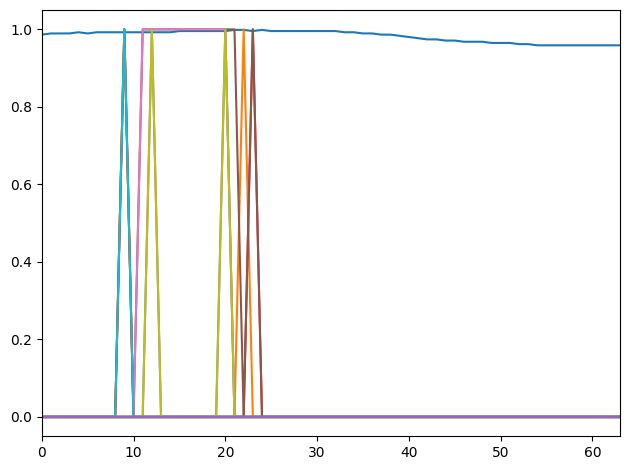

In [ ]:
def show_splitpoints(anomaly=None):
  # Find a sensible split point according to our criteria
  split_point = find_split_point(anomaly)

  print(f"{anomaly.chan_id},{split_point}")

filtered_anomalies = filter_anomalies("SMAP", 2)
#target_chan_ids = ['T-1', 'T-3']
target_chan_ids = ['T-3']

window_length = 64 #min(int(1.5 * avg_anom_len),128)
bs = 128 #compute_batch_size(window_length+1)
lr_max = 4.759e-04
optimiser = 'adamw'
loss_func = 'celf_w'
fusion_layers = [128,128]
fusion_dropout = 0.938
monitor='f1_score'
epochs=35
patience=10
pretrained=False
load_weights=False
seed=42

# Let's do some machine learning!
data_path = f"/content/drive/MyDrive/Colab Notebooks/data"

for anomaly in filtered_anomalies:
  if anomaly.chan_id in target_chan_ids:
    print(anomaly.chan_id)
    # Find a sensible split point according to our criteria
    split_point = find_split_point(anomaly)

    # Load the data
    file_path = os.path.join(labelled_data, f'{anomaly.chan_id}_lab.npy')
    data = np.load(file_path)

    for i in range(40):
      xb = get_one_batch(data, window_length, split_point, seed, bs)
      xb[0].show()
      print("Batch", anomaly.chan_id, i)

Automatic pdb calling has been turned OFF
18 anomalies found matching criteria
E-1,5320
E-12,5330
E-11,5332
E-10,5325
E-13,6044
G-7,6330
P-1,4157
P-4,3560
T-1,5224
T-3,3690
C-1,1425
D-14,1725
C-2,965
F-7,3057
P-11,1561
T-13,1345
T-8,1130
T-9,850
E-1,5320
############# CHAN_ID = E-1 #############


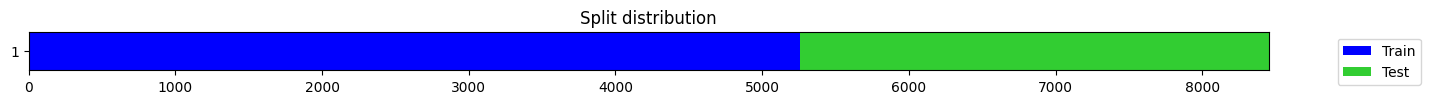

Better model found at epoch 0 with f1_score value: 0.08905380333951764.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.125.
Epoch 2: reducing lr to 1.3746386810773841e-05
Epoch 3: reducing lr to 2.1482373222988463e-05
Epoch 4: reducing lr to 2.963467486675526e-05
Epoch 5: reducing lr to 3.7163622520897166e-05
Better model found at epoch 6 with f1_score value: 0.5970588235294118.
Epoch 7: reducing lr to 4.671273483738852e-05
Epoch 8: reducing lr to 4.7581326720043344e-05
Epoch 9: reducing lr to 4.7334483842112396e-05
Epoch 10: reducing lr to 4.675088516001135e-05
Epoch 11: reducing lr to 4.5838879605583626e-05
Epoch 12: reducing lr to 4.4611514233981206e-05
Epoch 13: reducing lr to 4.3086348392447955e-05
Epoch 14: reducing lr to 4.1285201115889827e-05
Epoch 15: reducing lr to 3.9233840727135454e-05
Epoch 16: reducing lr to 3.6961612683724475e-05
No improvement since epoch 6: early stopping

training time: 00:00:30


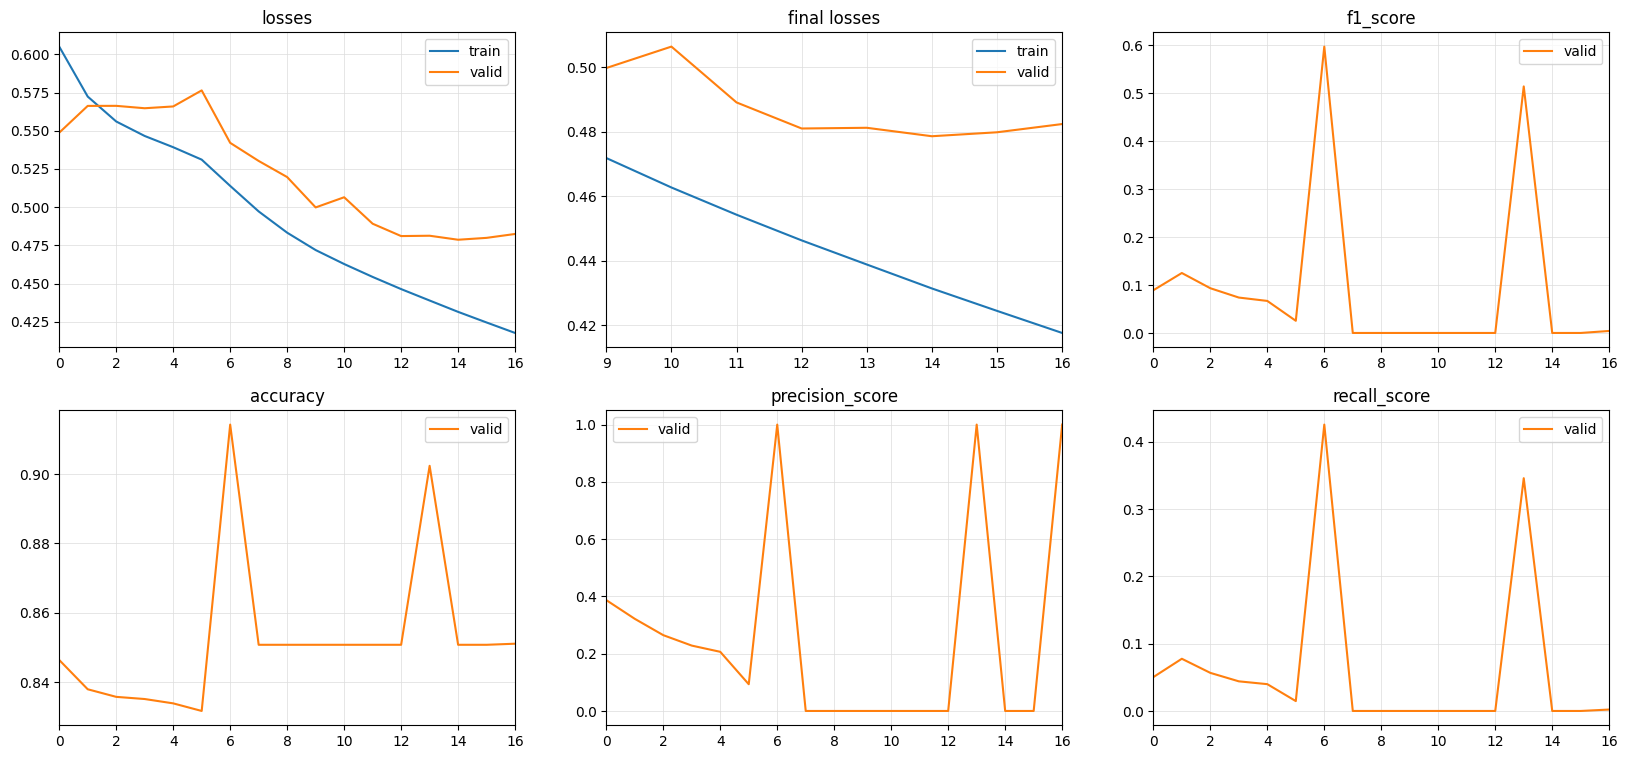

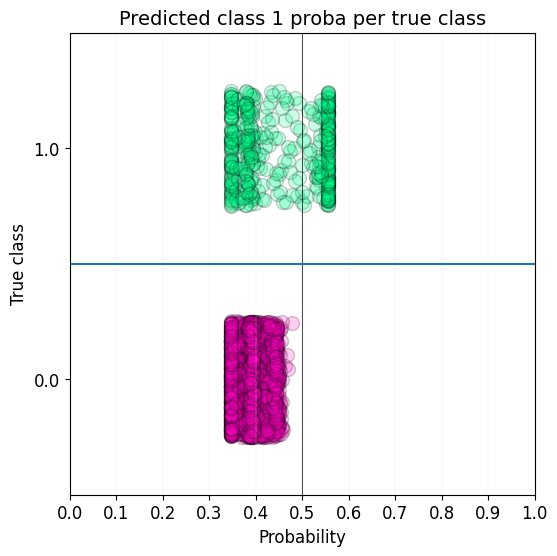

0.3477871 tensor(0.3478)
E-12,5330
############# CHAN_ID = E-12 #############


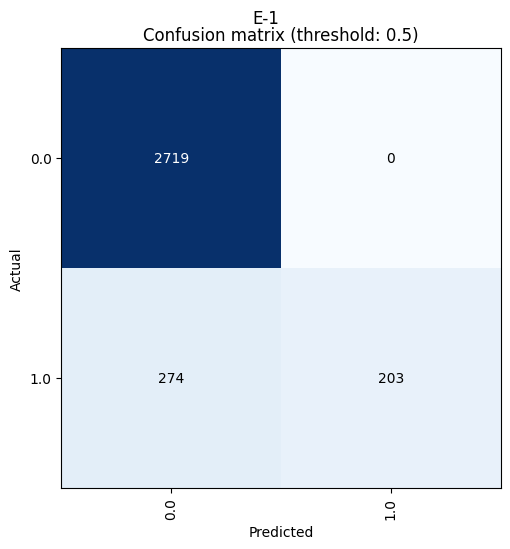

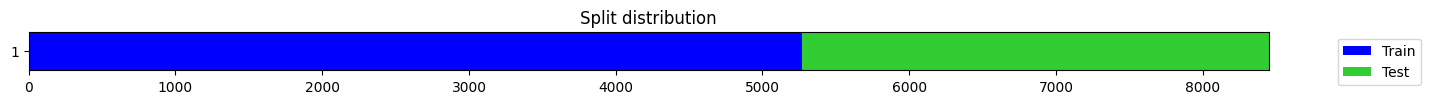

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Epoch 1: reducing lr to 7.413285773177325e-06
Epoch 2: reducing lr to 1.3746386810773841e-05
Epoch 3: reducing lr to 2.1482373222988463e-05
Epoch 4: reducing lr to 2.963467486675526e-05
Epoch 5: reducing lr to 3.7163622520897166e-05
Epoch 6: reducing lr to 4.3109049773200335e-05
Epoch 7: reducing lr to 4.671273483738852e-05
Epoch 8: reducing lr to 4.7581326720043344e-05
Epoch 9: reducing lr to 4.7334483842112396e-05
Epoch 10: reducing lr to 4.675088516001135e-05
Epoch 11: reducing lr to 4.5838879605583626e-05
No improvement since epoch 1: early stopping

training time: 00:00:18


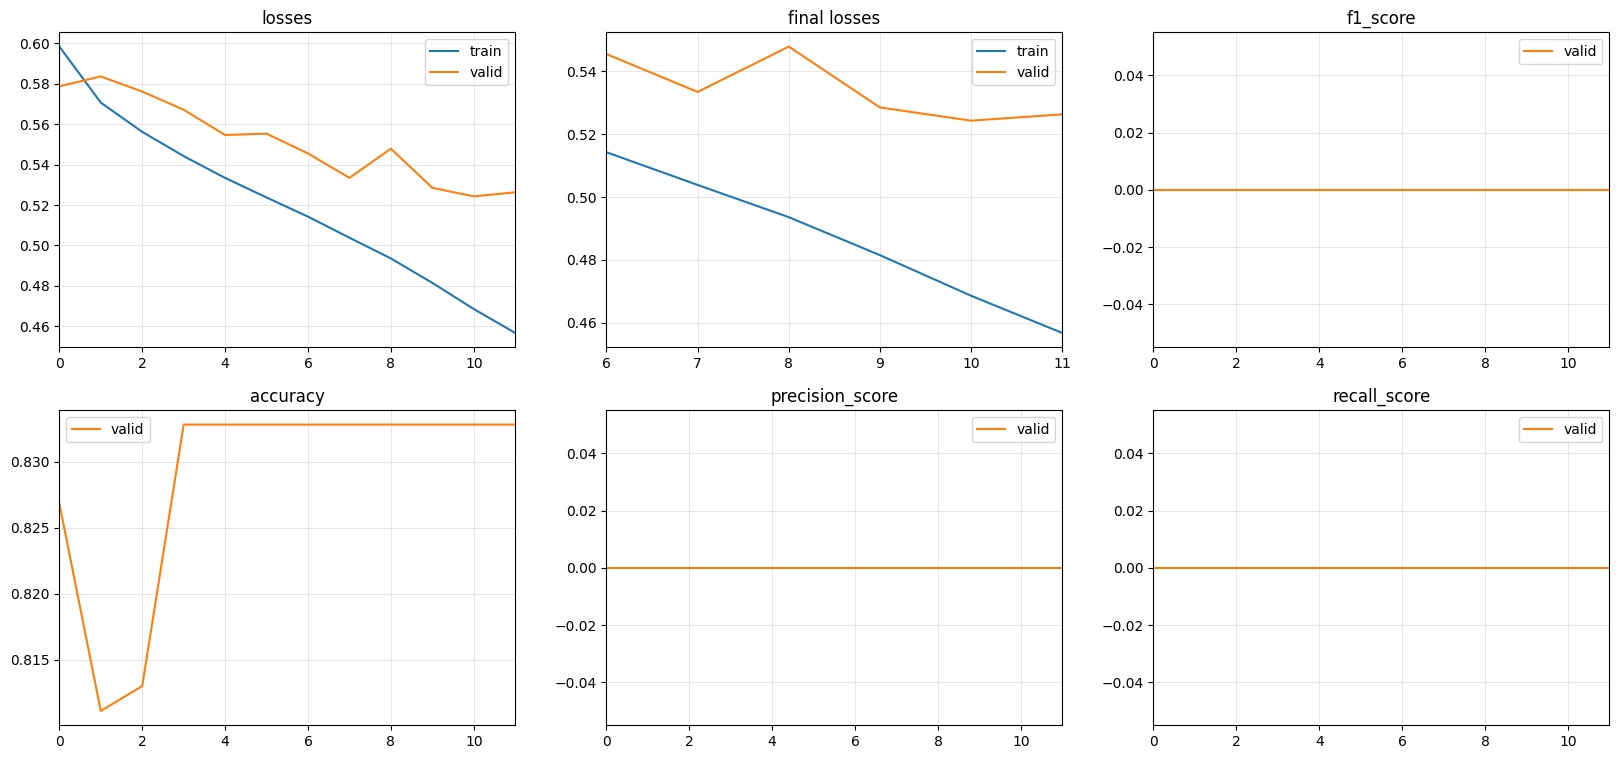

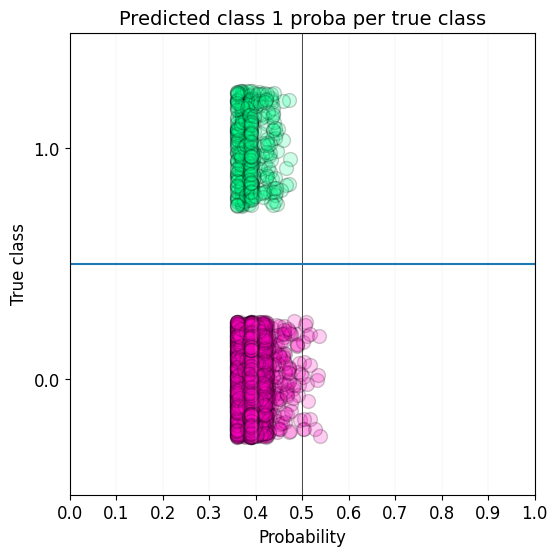

0.35904175 tensor(0.3590)
E-11,5332
############# CHAN_ID = E-11 #############


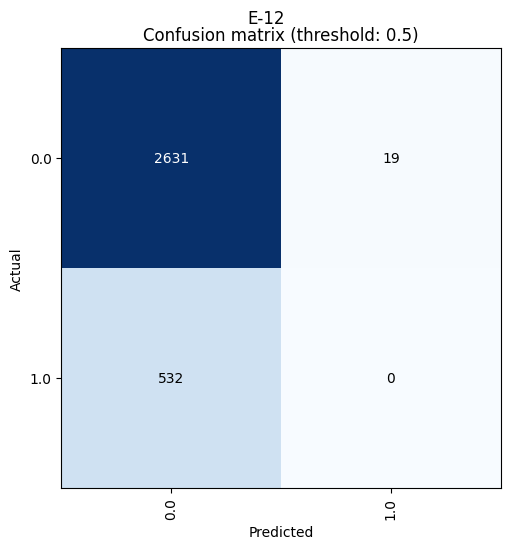

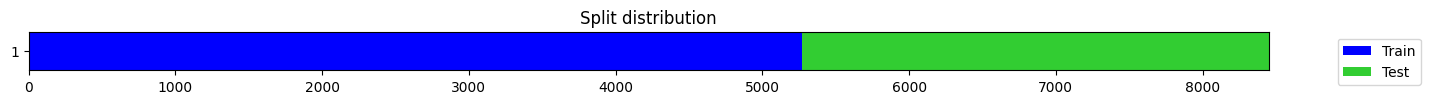

Better model found at epoch 0 with f1_score value: 0.1297709923664122.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.774703557312253.
Epoch 2: reducing lr to 1.3746386810773841e-05
Epoch 3: reducing lr to 2.1482373222988463e-05
Better model found at epoch 4 with f1_score value: 0.9170305676855895.
Epoch 5: reducing lr to 3.7163622520897166e-05
Epoch 6: reducing lr to 4.3109049773200335e-05
Epoch 7: reducing lr to 4.671273483738852e-05
Epoch 8: reducing lr to 4.7581326720043344e-05
Epoch 9: reducing lr to 4.7334483842112396e-05
Epoch 10: reducing lr to 4.675088516001135e-05
Epoch 11: reducing lr to 4.5838879605583626e-05
Epoch 12: reducing lr to 4.4611514233981206e-05
Epoch 13: reducing lr to 4.3086348392447955e-05
Epoch 14: reducing lr to 4.1285201115889827e-05
No improvement since epoch 4: early stopping

training time: 00:00:24


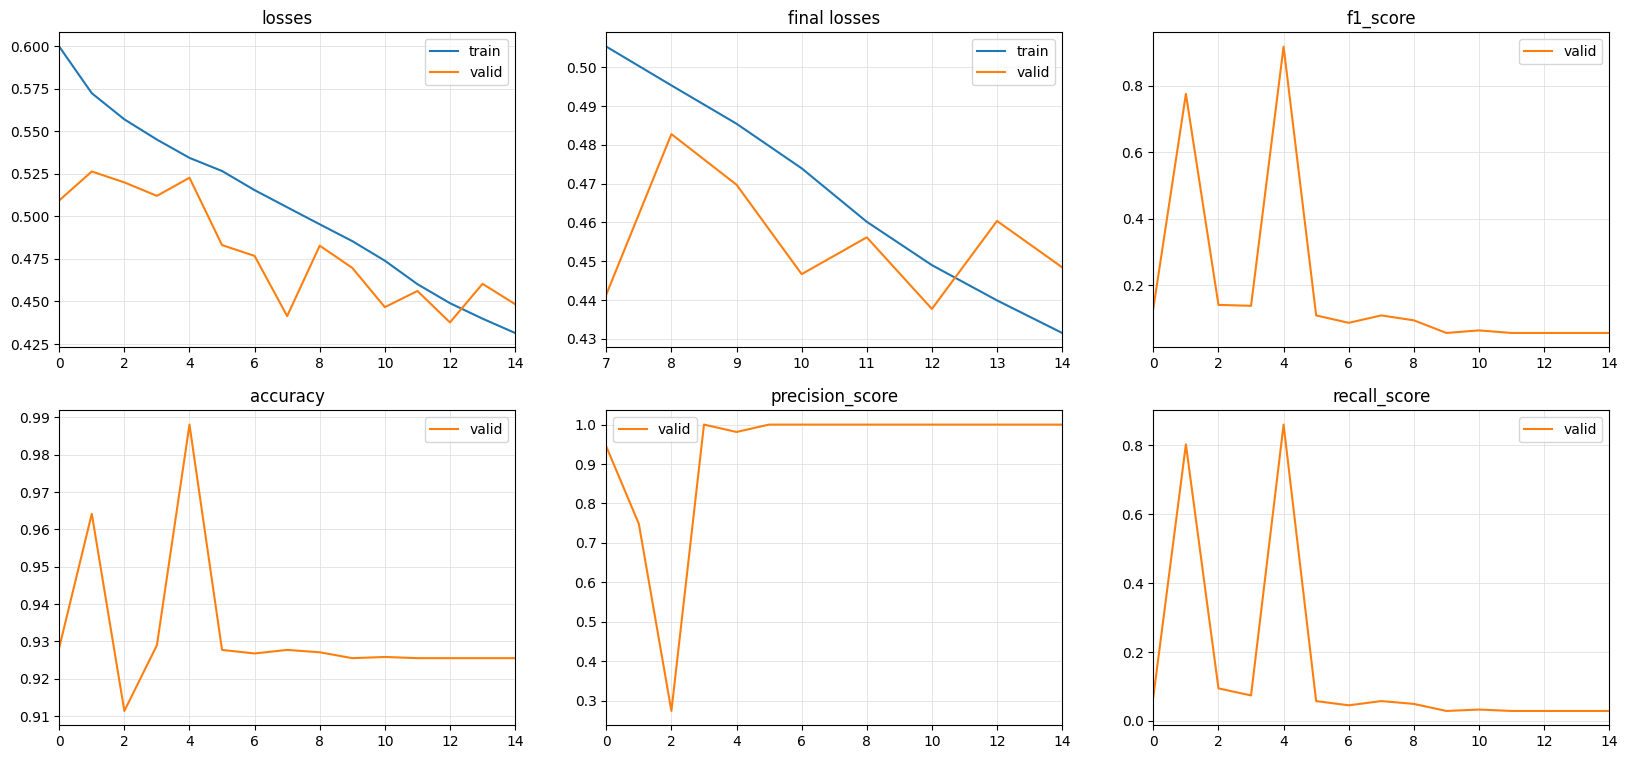

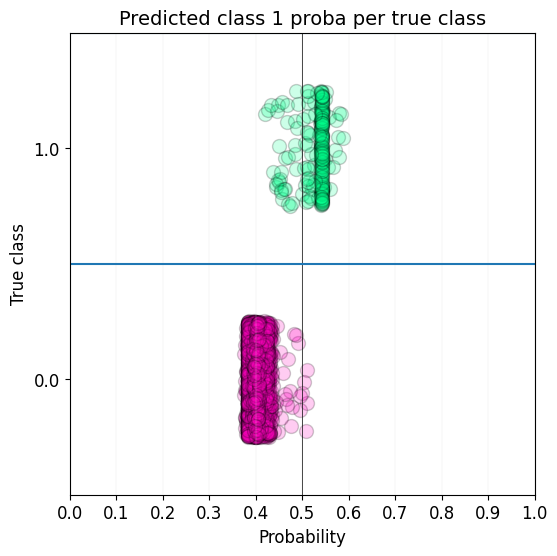

0.37536952 tensor(0.3754)
E-10,5325
############# CHAN_ID = E-10 #############


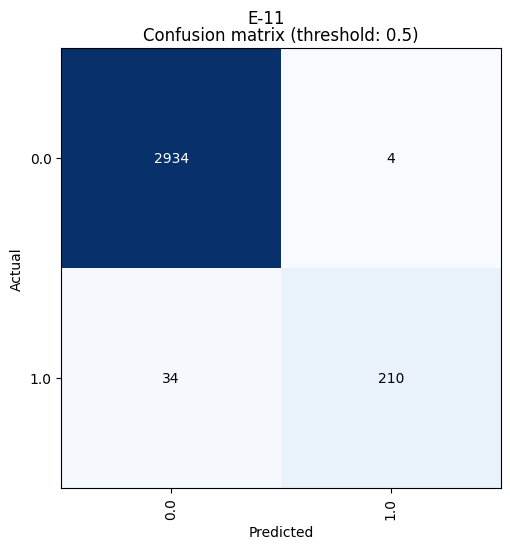

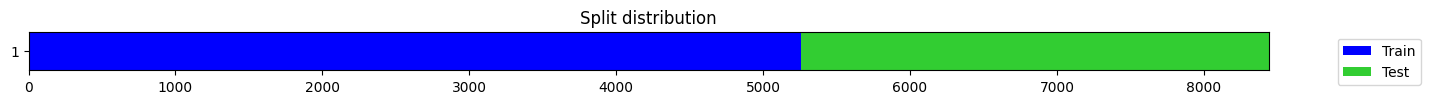

Better model found at epoch 0 with f1_score value: 0.14501510574018125.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.776386404293381.
Epoch 2: reducing lr to 1.3746386810773841e-05
Better model found at epoch 3 with f1_score value: 0.7820224719101123.
Epoch 4: reducing lr to 2.963467486675526e-05
Epoch 5: reducing lr to 3.7163622520897166e-05
Epoch 6: reducing lr to 4.3109049773200335e-05
Epoch 7: reducing lr to 4.671273483738852e-05
Epoch 8: reducing lr to 4.7581326720043344e-05
Epoch 9: reducing lr to 4.7334483842112396e-05
Better model found at epoch 10 with f1_score value: 0.831896551724138.
Epoch 11: reducing lr to 4.5838879605583626e-05
Epoch 12: reducing lr to 4.4611514233981206e-05
Epoch 13: reducing lr to 4.3086348392447955e-05
Epoch 14: reducing lr to 4.1285201115889827e-05
Epoch 15: reducing lr to 3.9233840727135454e-05
Epoch 16: reducing lr to 3.6961612683724475e-05
Epoch 17: reducing lr to 3.450102456617836e-05
Epoch 18: reducing lr to 3.188727

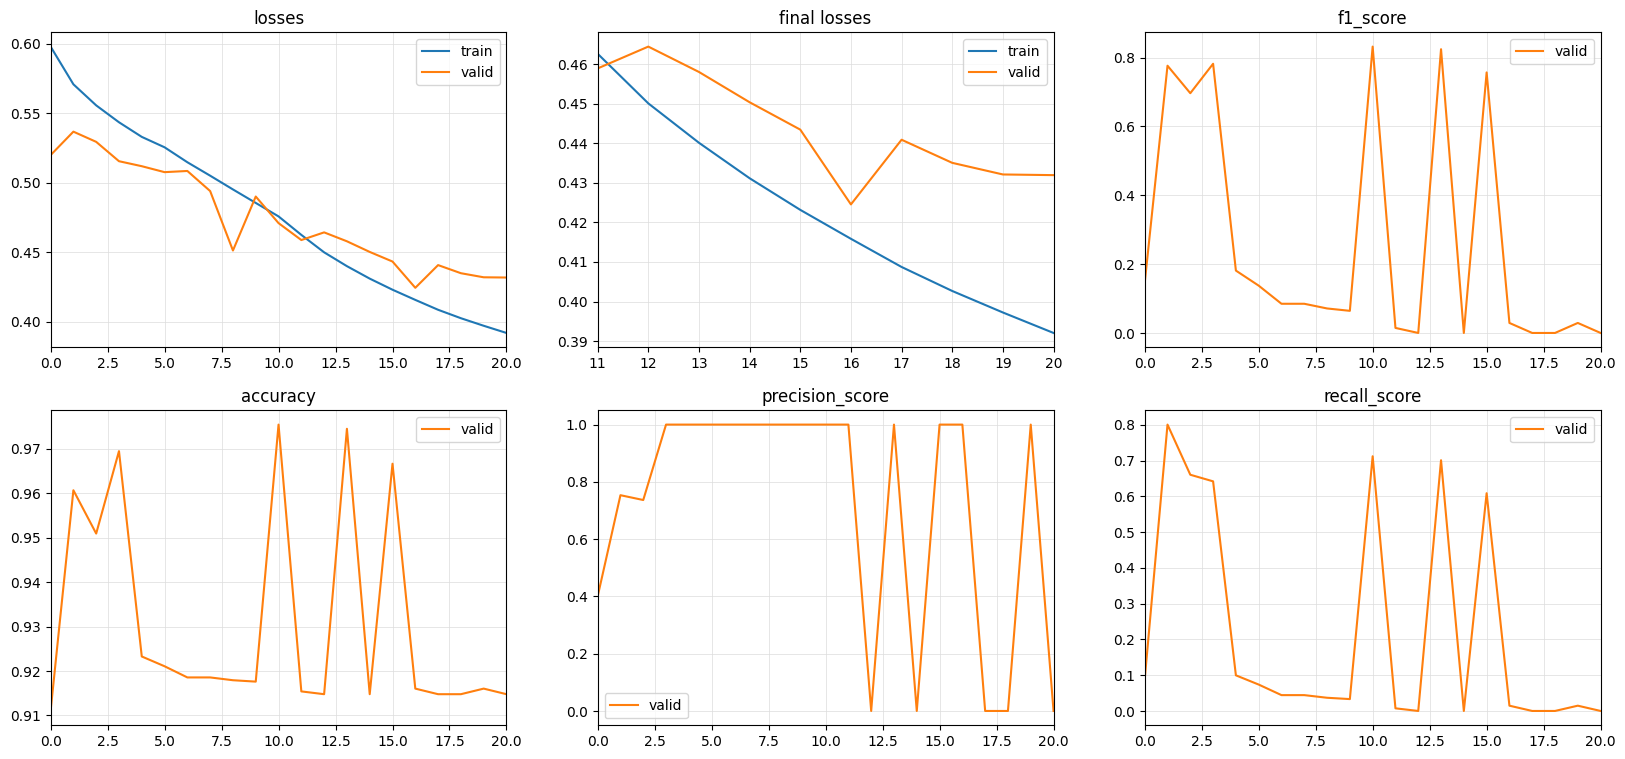

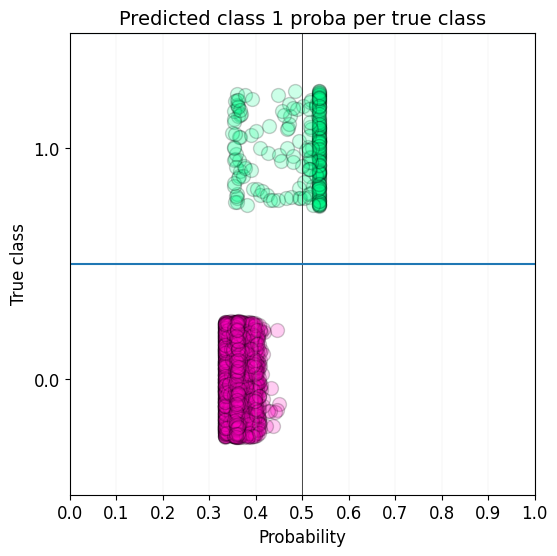

0.33357716 tensor(0.3336)
E-13,6044
############# CHAN_ID = E-13 #############


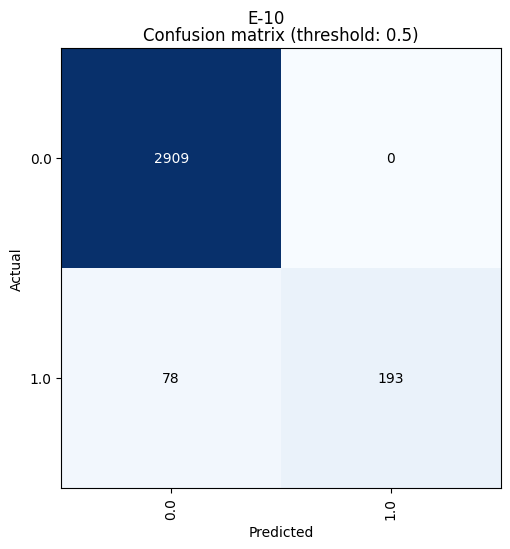

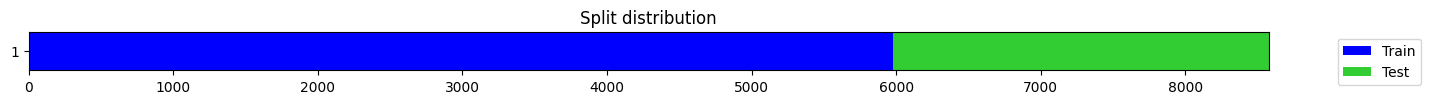

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.302158273381295.
Better model found at epoch 2 with f1_score value: 0.3923076923076923.
Epoch 3: reducing lr to 2.150389603534076e-05
Epoch 4: reducing lr to 2.9655911454358094e-05
Epoch 5: reducing lr to 3.718186669334198e-05
Epoch 6: reducing lr to 4.3121974846729486e-05
Epoch 7: reducing lr to 4.671869247422523e-05
Epoch 8: reducing lr to 4.758112174823747e-05
Epoch 9: reducing lr to 4.733337949608541e-05
Epoch 10: reducing lr to 4.674889723880561e-05
Epoch 11: reducing lr to 4.5836036548601994e-05
Epoch 12: reducing lr to 4.46078567142563e-05
No improvement since epoch 2: early stopping

training time: 00:00:24


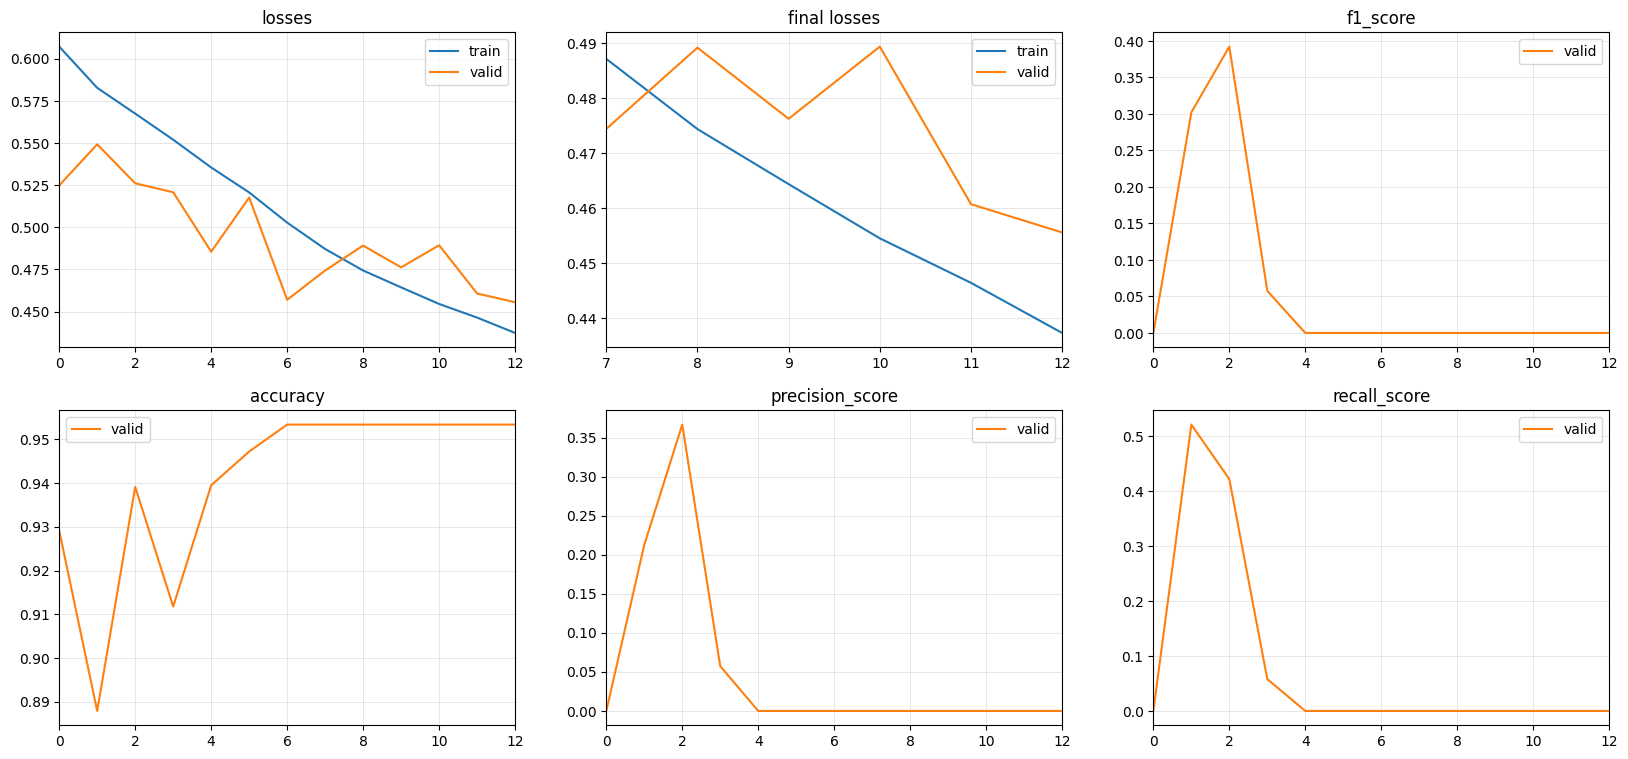

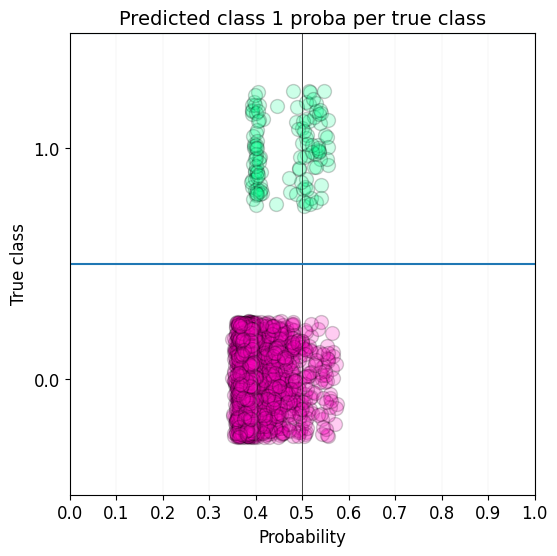

0.34856576 tensor(0.3486)
G-7,6330
############# CHAN_ID = G-7 #############


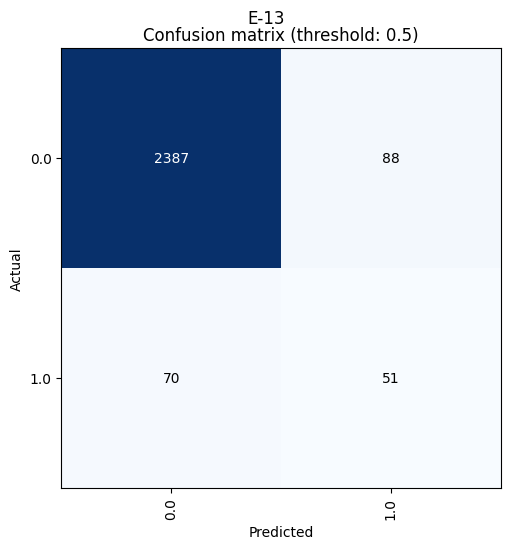

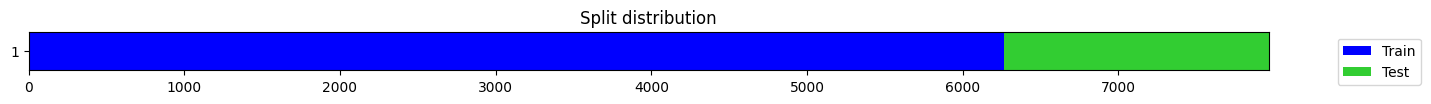

Better model found at epoch 0 with f1_score value: 0.5053763440860214.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.6367346938775511.
Epoch 2: reducing lr to 1.3771962768074605e-05
Better model found at epoch 3 with f1_score value: 0.6419753086419754.
Better model found at epoch 4 with f1_score value: 0.6550218340611355.
Better model found at epoch 5 with f1_score value: 0.6637554585152838.
Better model found at epoch 6 with f1_score value: 0.6782608695652174.
Epoch 7: reducing lr to 4.672072379847703e-05
Better model found at epoch 8 with f1_score value: 0.6995515695067265.
Better model found at epoch 9 with f1_score value: 0.7123287671232877.
Epoch 10: reducing lr to 4.674821680801352e-05
Better model found at epoch 11 with f1_score value: 0.7323943661971831.
Epoch 12: reducing lr to 4.4606605573609866e-05
Better model found at epoch 13 with f1_score value: 0.7358490566037735.
Epoch 14: reducing lr to 4.127833189194702e-05
Epoch 15: reducing lr to 3.92261

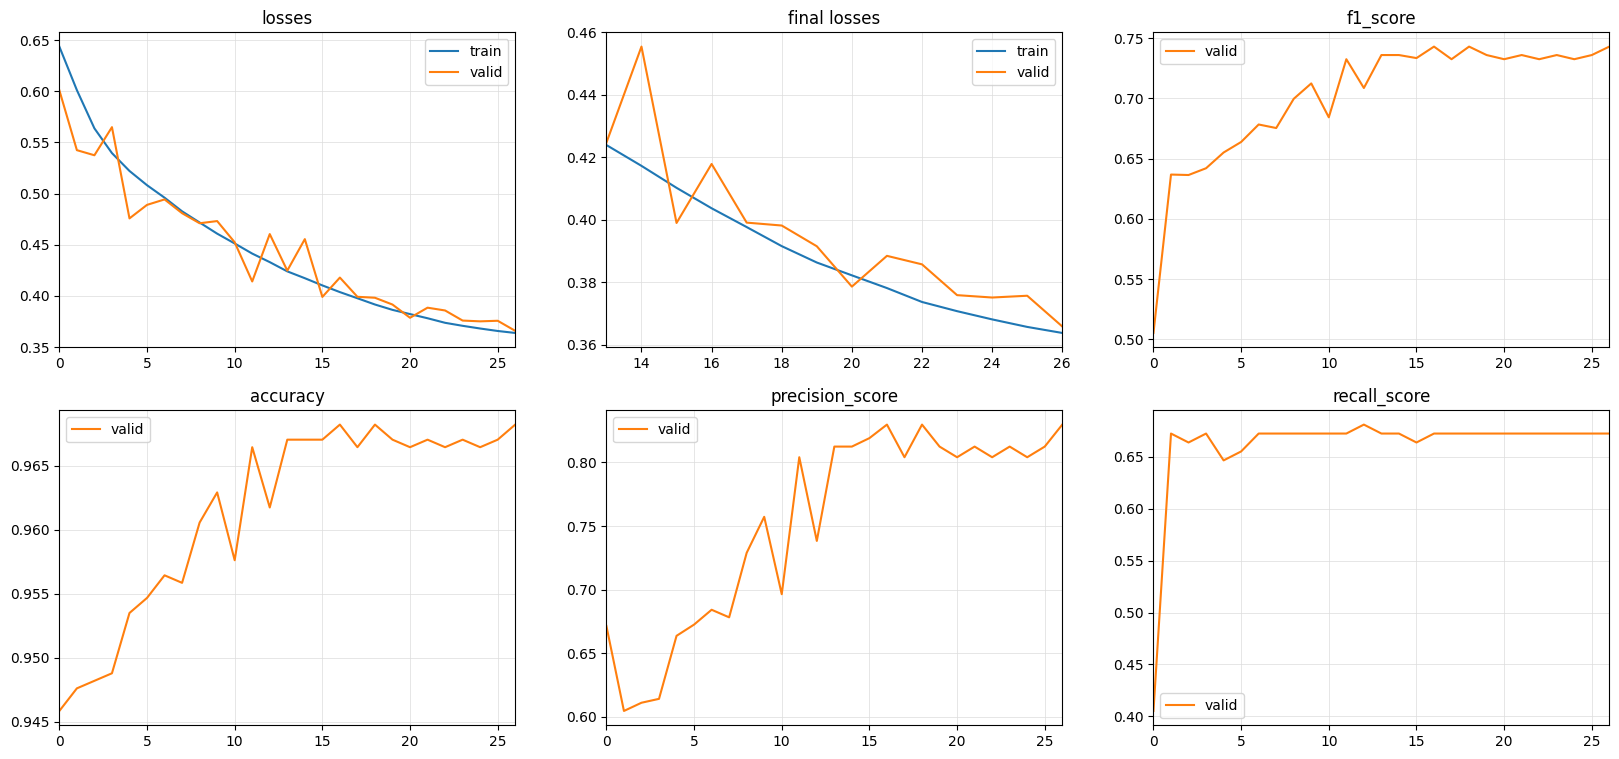

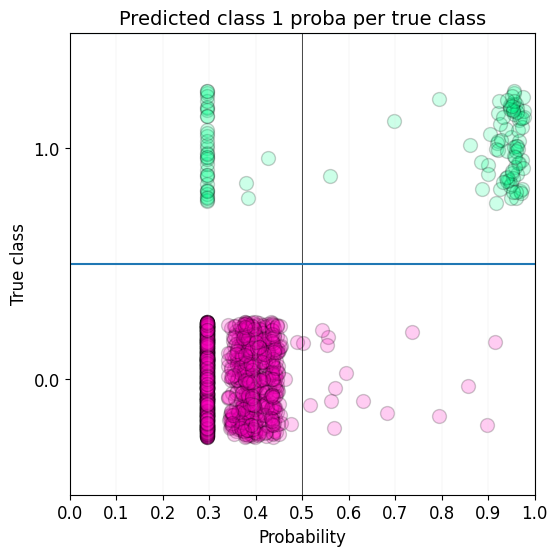

0.022663694 tensor(0.0227)
P-1,4157
############# CHAN_ID = P-1 #############


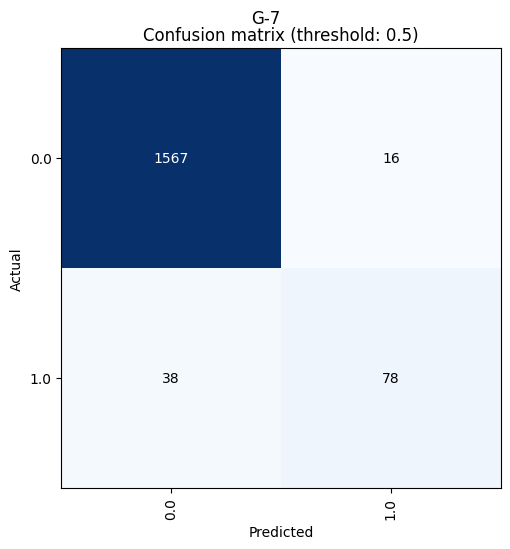

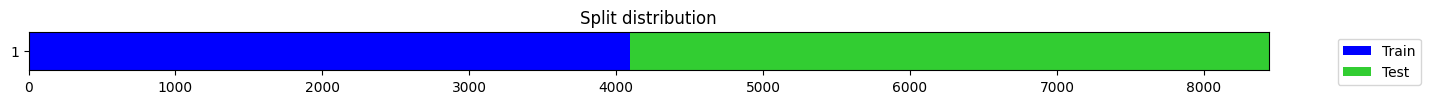

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.06533575317604357.
Epoch 2: reducing lr to 1.3689877859241402e-05
Epoch 3: reducing lr to 2.141852086092386e-05
Epoch 4: reducing lr to 2.9571620112252426e-05
Epoch 5: reducing lr to 3.71094088789465e-05
Epoch 6: reducing lr to 4.3070591122770686e-05
Epoch 7: reducing lr to 4.669493581954082e-05
Epoch 8: reducing lr to 4.7581921085050365e-05
Epoch 9: reducing lr to 4.733774817300981e-05
Better model found at epoch 10 with f1_score value: 0.19121447028423771.
Epoch 11: reducing lr to 4.584730613087278e-05
Epoch 12: reducing lr to 4.462235948165875e-05
Epoch 13: reducing lr to 4.30994569991145e-05
Epoch 14: reducing lr to 4.130038554790961e-05
Epoch 15: reducing lr to 3.925088290619308e-05
Epoch 16: reducing lr to 3.698026955719143e-05
Epoch 17: reducing lr to 3.452102723745061e-05
Better model found at epoch 18 with f1_score value: 0.25133689839572193.
Epoch 

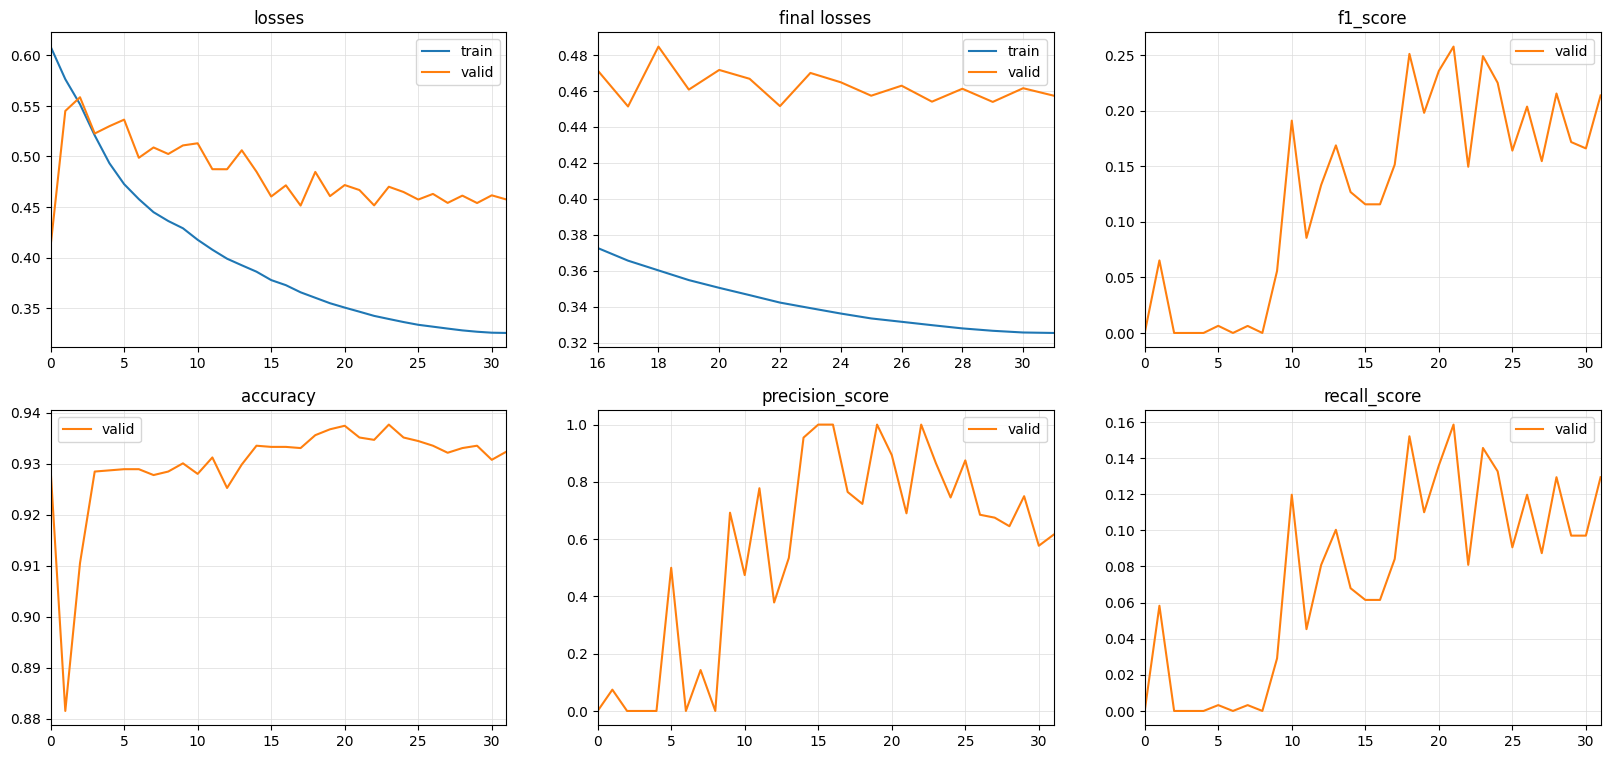

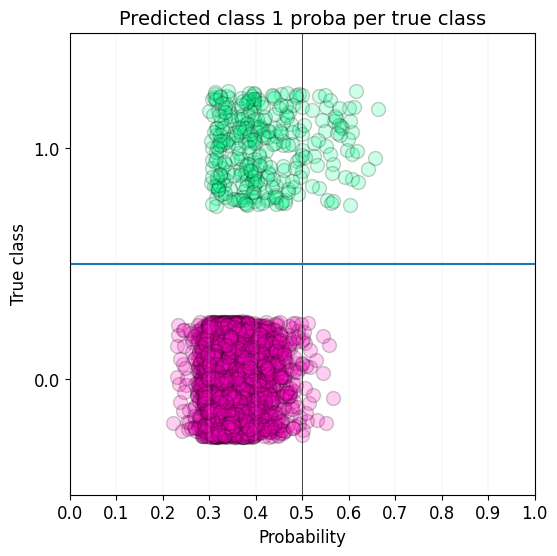

0.22226968 tensor(0.2223)
P-4,3560
############# CHAN_ID = P-4 #############


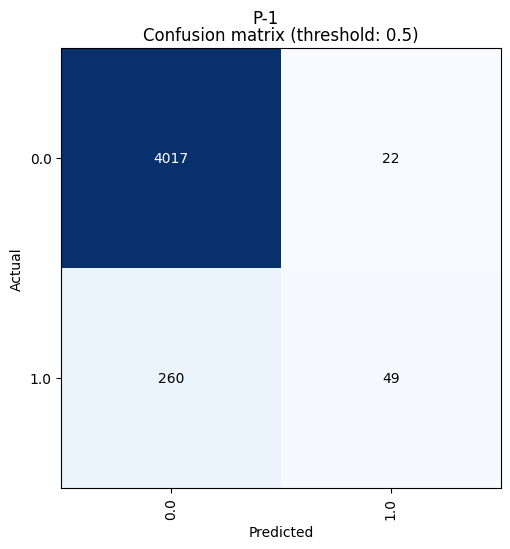

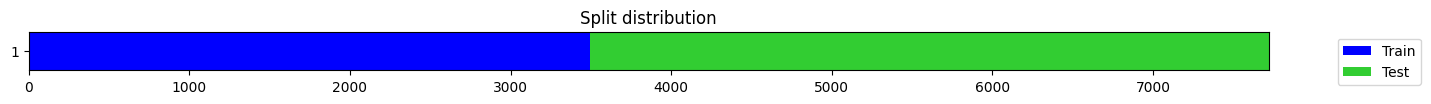

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.7167630057803467.
Better model found at epoch 2 with f1_score value: 0.7386363636363636.
Better model found at epoch 3 with f1_score value: 0.7457627118644068.
Epoch 4: reducing lr to 2.9533302815287273e-05
Epoch 5: reducing lr to 3.707643217637162e-05
Epoch 6: reducing lr to 4.304716054150125e-05
Epoch 7: reducing lr to 4.668403946731573e-05
Epoch 8: reducing lr to 4.7582271835508204e-05
Epoch 9: reducing lr to 4.733972090672249e-05
Epoch 10: reducing lr to 4.676033910170752e-05
Epoch 11: reducing lr to 4.585241525588447e-05
Epoch 12: reducing lr to 4.462893848878581e-05
Epoch 13: reducing lr to 4.31074115591973e-05
No improvement since epoch 3: early stopping

training time: 00:00:21


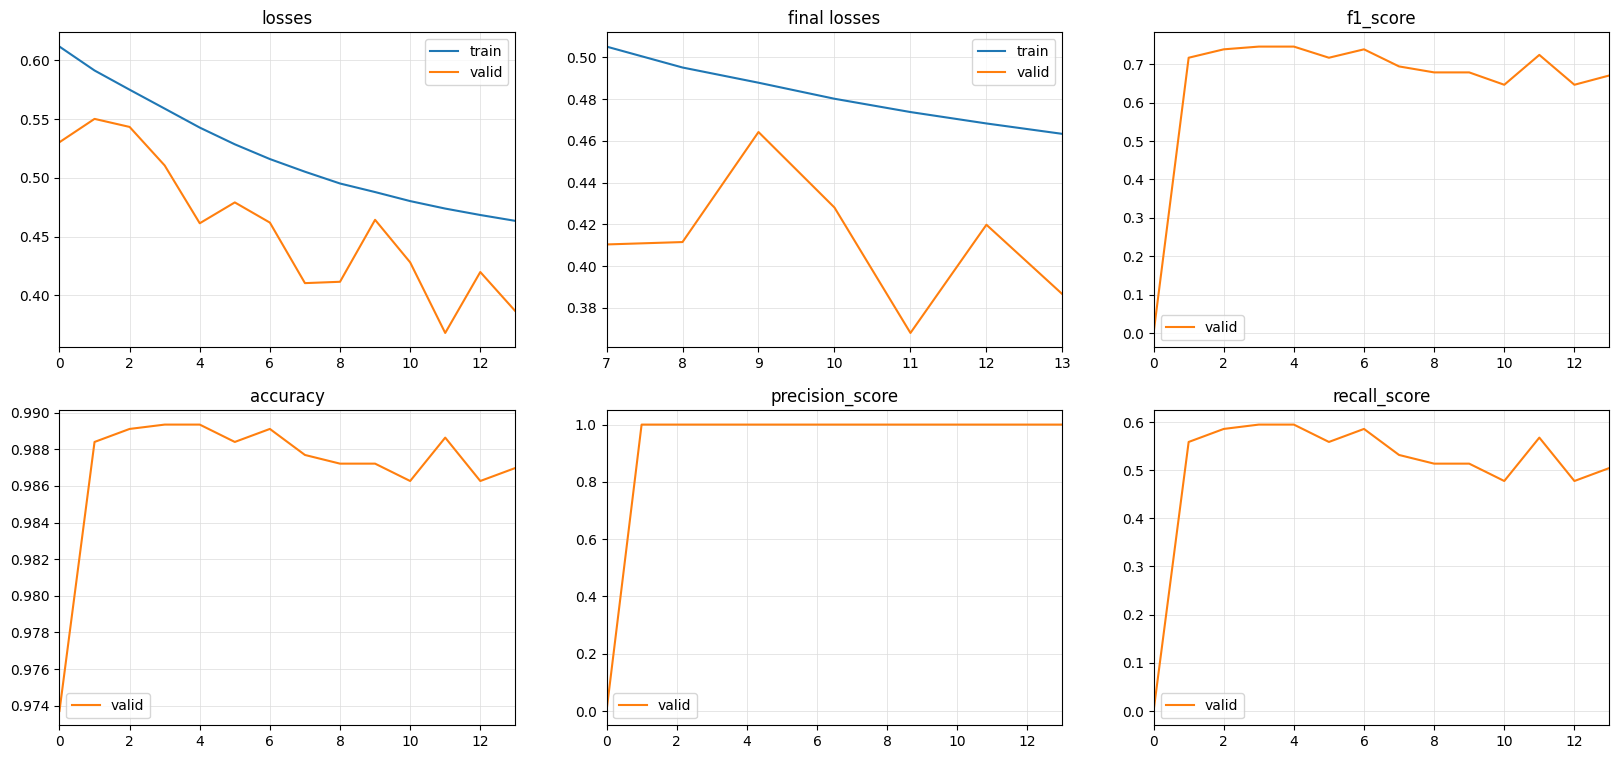

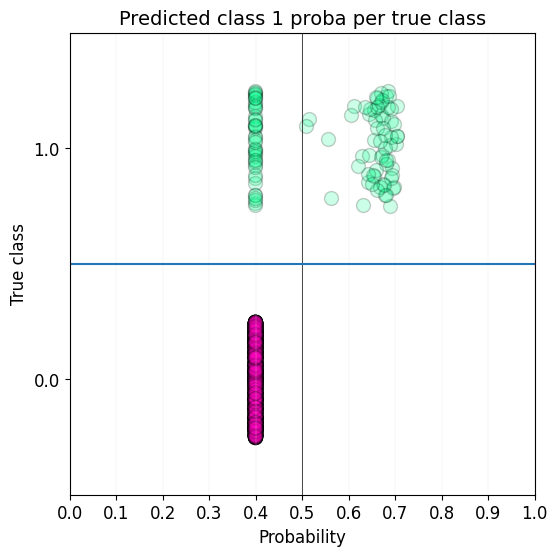

0.2950062 tensor(0.2950)
T-1,5224
############# CHAN_ID = T-1 #############


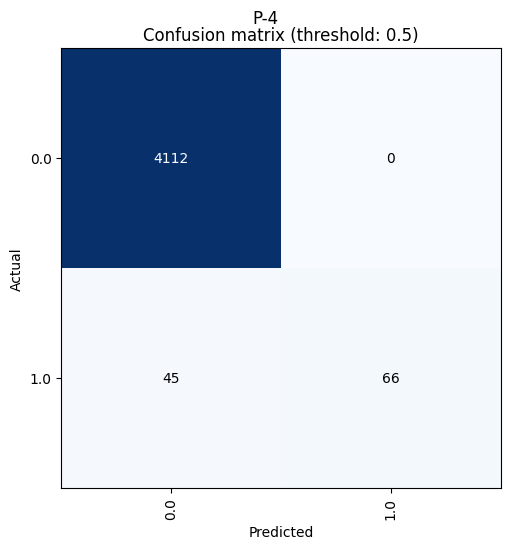

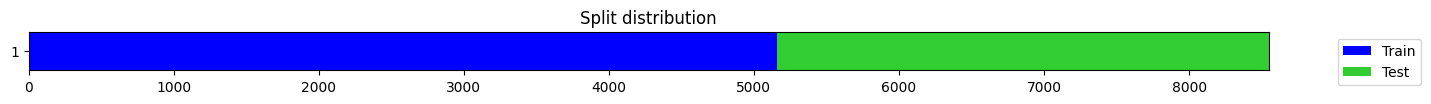

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Epoch 1: reducing lr to 7.410028662004672e-06
Epoch 2: reducing lr to 1.3742004696662203e-05
Epoch 3: reducing lr to 2.147742426169683e-05
Better model found at epoch 4 with f1_score value: 0.28125000000000006.
Better model found at epoch 5 with f1_score value: 0.31884057971014496.
Better model found at epoch 6 with f1_score value: 0.36065573770491804.
Epoch 7: reducing lr to 4.6711361871629417e-05
Better model found at epoch 8 with f1_score value: 0.4418604651162791.
Epoch 9: reducing lr to 4.7334737754013985e-05
Better model found at epoch 10 with f1_score value: 0.449438202247191.
Epoch 11: reducing lr to 4.5839533832352e-05
Epoch 12: reducing lr to 4.461235598737376e-05
Epoch 13: reducing lr to 4.308736563018042e-05
Epoch 14: reducing lr to 4.128637928521106e-05
Epoch 15: reducing lr to 3.923516297293081e-05
Epoch 16: reducing lr to 3.6963056378605016e-05
Epoch 17: reducing lr to 3.450257244670343e-05
Epoc

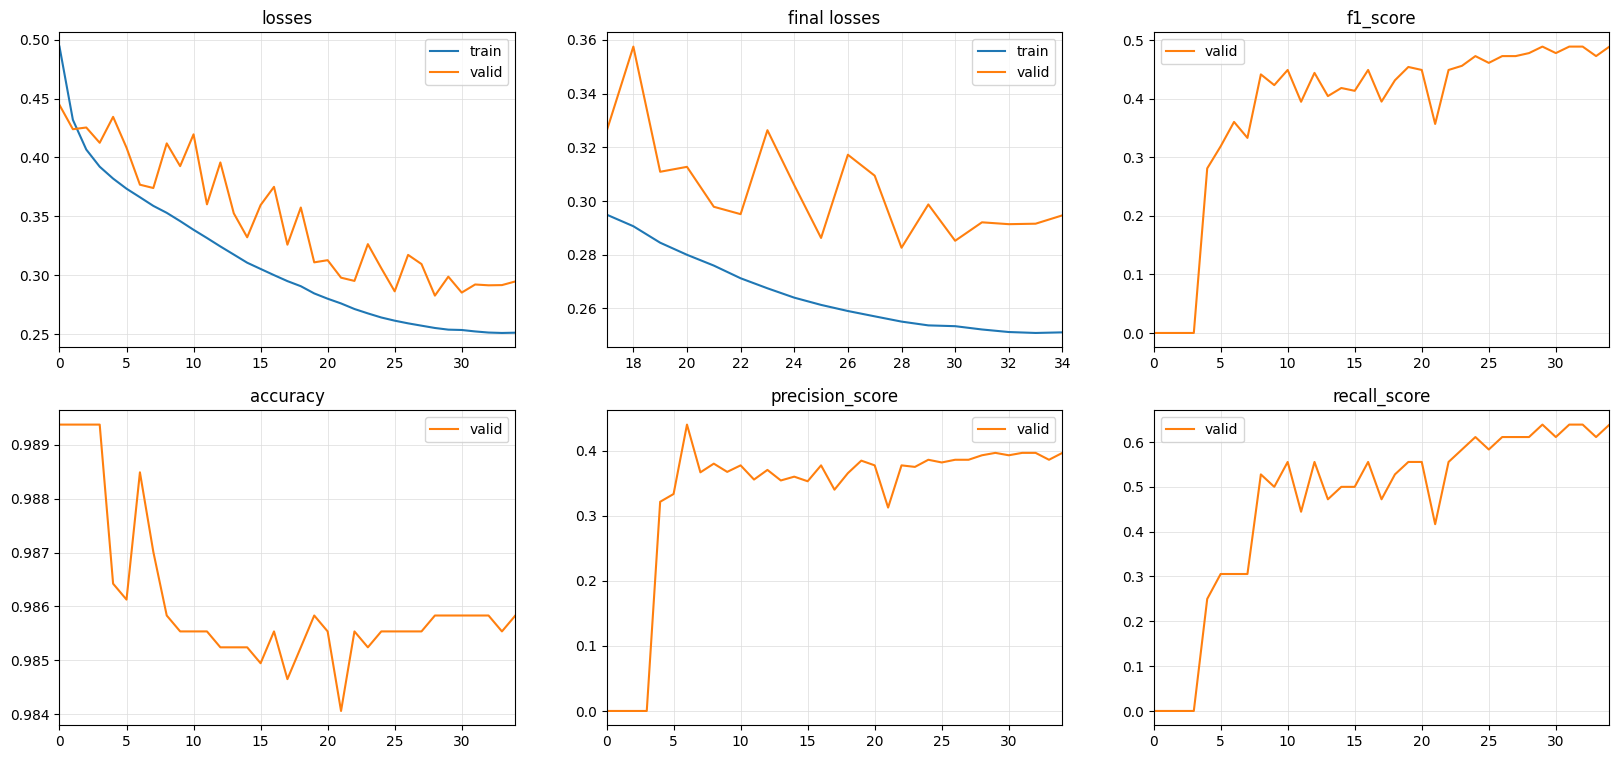

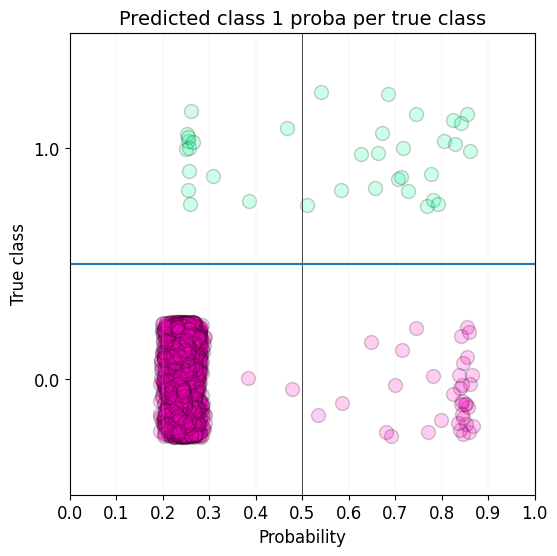

0.13271601 tensor(0.1327)
T-3,3690
############# CHAN_ID = T-3 #############


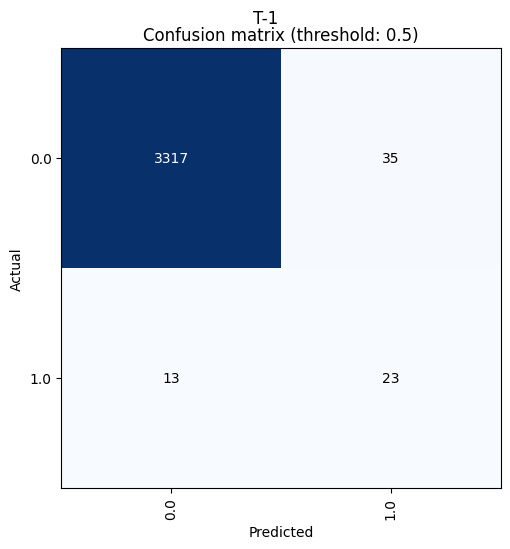

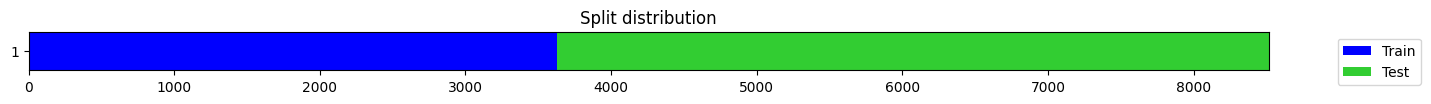

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Epoch 1: reducing lr to 7.352937556460793e-06
Better model found at epoch 2 with f1_score value: 0.4836601307189543.
Better model found at epoch 3 with f1_score value: 0.5644171779141104.
Epoch 4: reducing lr to 2.954390912673573e-05
Better model found at epoch 5 with f1_score value: 0.5818181818181818.
Epoch 6: reducing lr to 4.3053650707233826e-05
Epoch 7: reducing lr to 4.668706166400341e-05
Epoch 8: reducing lr to 4.758217554839512e-05
Epoch 9: reducing lr to 4.7339175729895766e-05
Epoch 10: reducing lr to 4.6759352983937954e-05
Epoch 11: reducing lr to 4.5851002224104776e-05
Epoch 12: reducing lr to 4.4627117143211965e-05
Epoch 13: reducing lr to 4.310520921022713e-05
Epoch 14: reducing lr to 4.1307050016611894e-05
Epoch 15: reducing lr to 3.92583634429857e-05
No improvement since epoch 5: early stopping

training time: 00:00:24


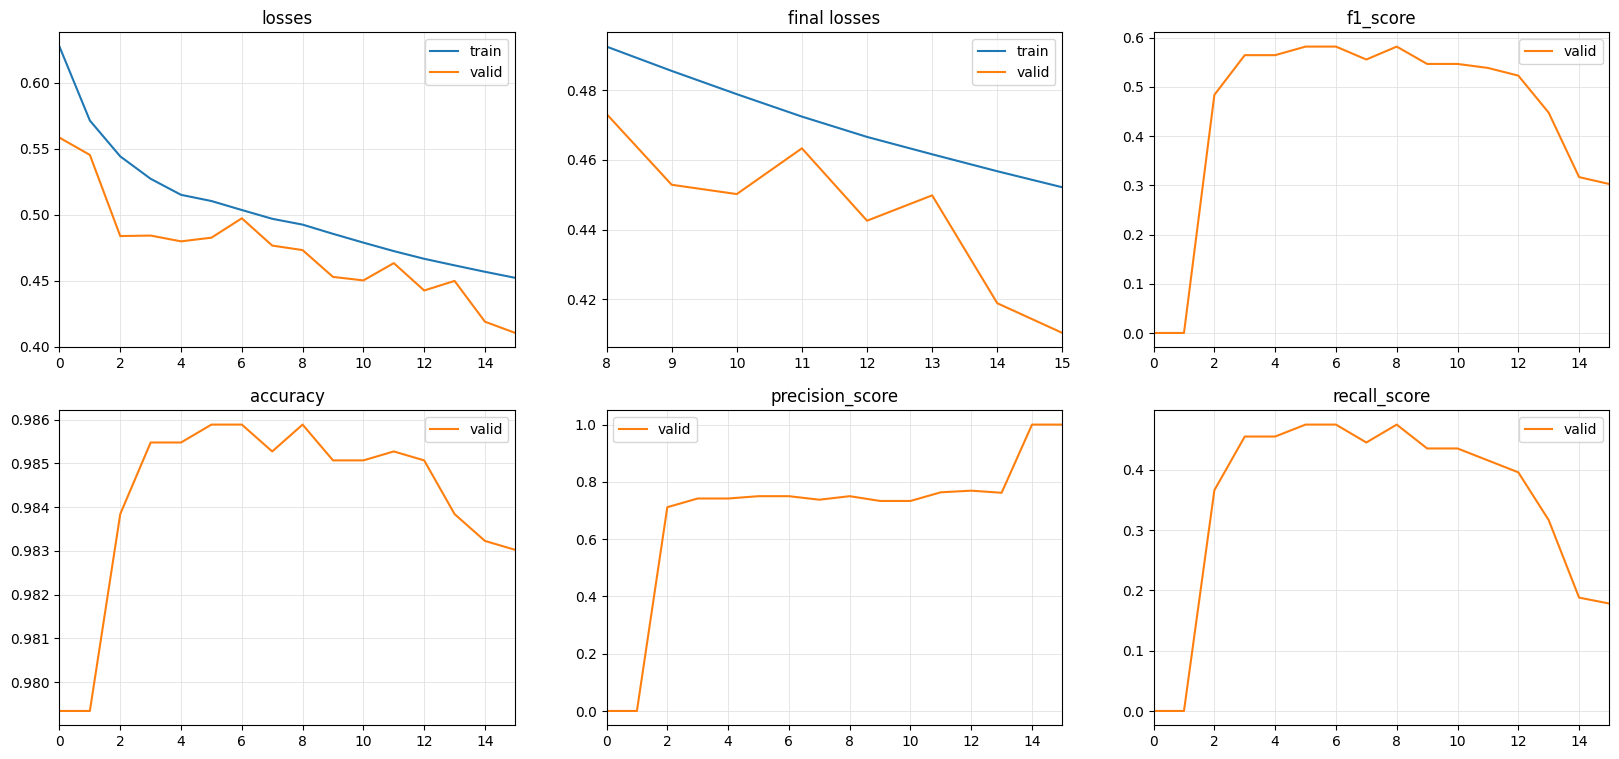

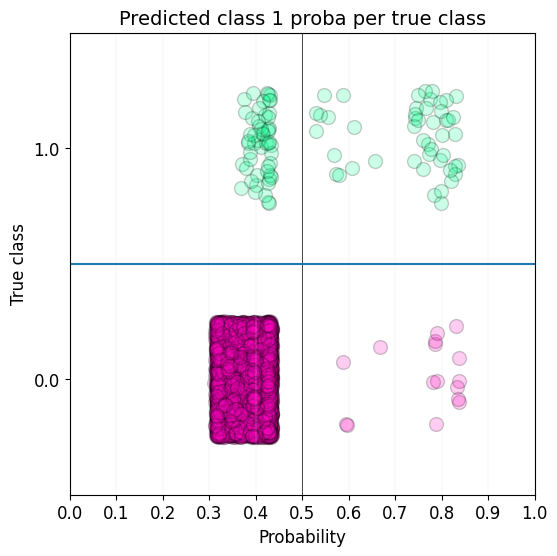

0.16216843 tensor(0.1622)
C-1,1425
############# CHAN_ID = C-1 #############


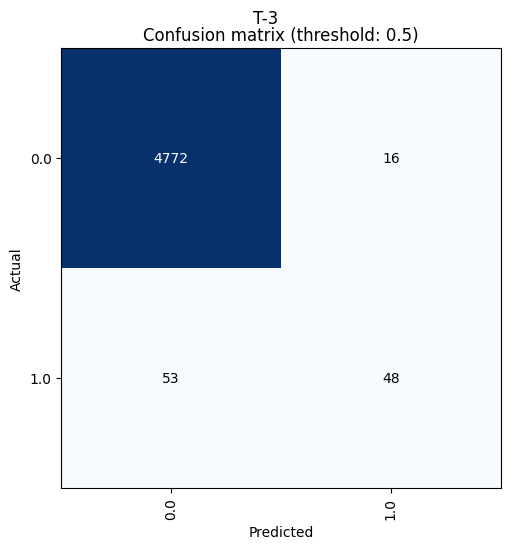

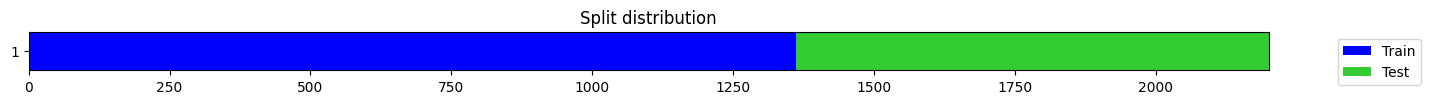

Better model found at epoch 0 with f1_score value: 0.2336842105263158.
Skipping first epoch
Epoch 1: reducing lr to 7.01582489867775e-06
Epoch 2: reducing lr to 1.3207024396853125e-05
Epoch 3: reducing lr to 2.086989639743388e-05
Epoch 4: reducing lr to 2.902718901341278e-05
Epoch 5: reducing lr to 3.6638602575459945e-05
Epoch 6: reducing lr to 4.27334516572476e-05
Epoch 7: reducing lr to 4.653445867017399e-05
Epoch 8: reducing lr to 4.7586165885173675e-05
Epoch 9: reducing lr to 4.736498954079073e-05
Epoch 10: reducing lr to 4.6806620898089215e-05
Epoch 11: reducing lr to 4.591904806017731e-05
No improvement since epoch 1: early stopping

training time: 00:00:06


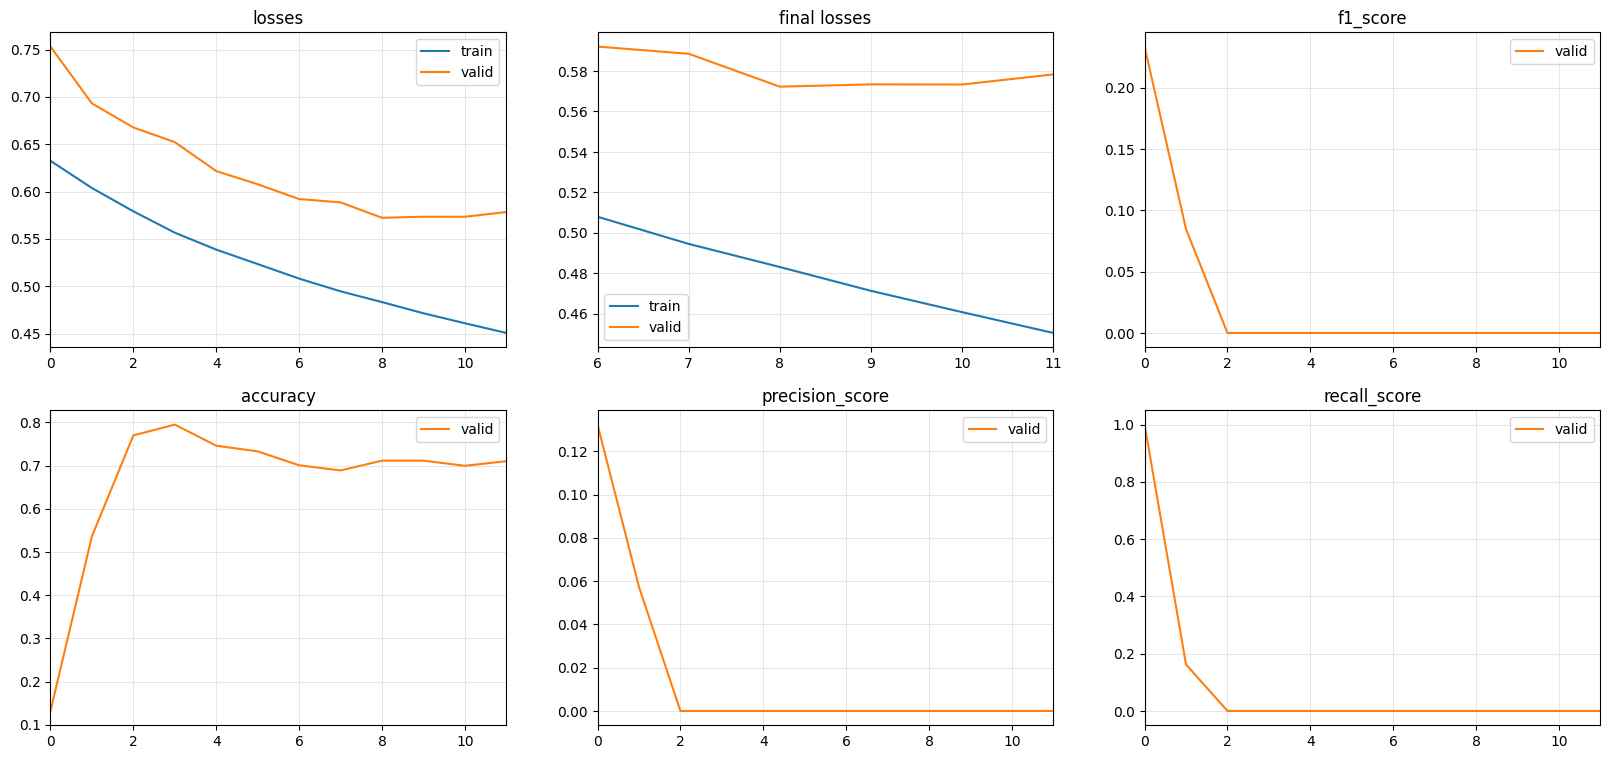

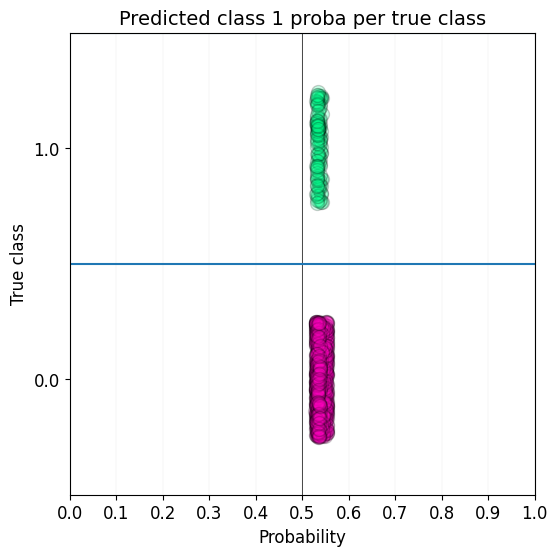

0.4464615 tensor(0.4465)
D-14,1725
############# CHAN_ID = D-14 #############


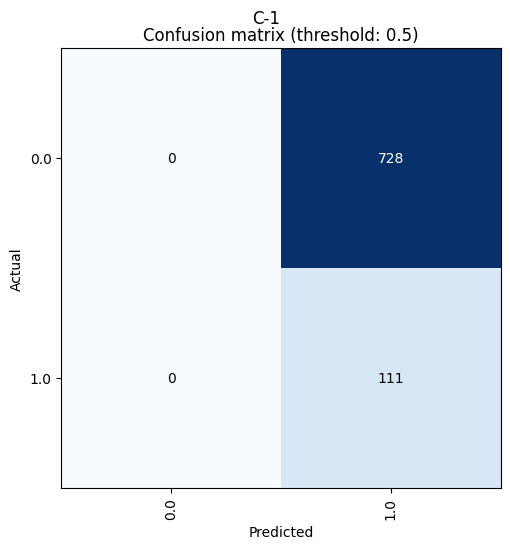

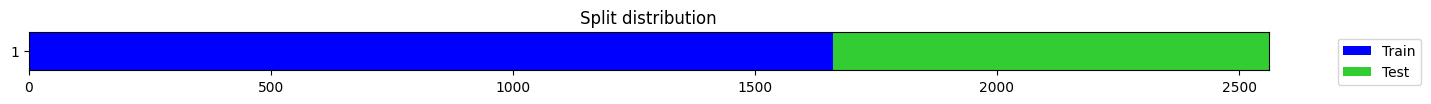

Better model found at epoch 0 with f1_score value: 0.1835985312117503.
Skipping first epoch
Epoch 1: reducing lr to 7.102325001128602e-06
Better model found at epoch 2 with f1_score value: 0.18779342723004694.
Epoch 3: reducing lr to 2.1004674906992768e-05
Epoch 4: reducing lr to 2.9161385419999597e-05
Epoch 5: reducing lr to 3.6755100668799797e-05
Epoch 6: reducing lr to 4.281739440710843e-05
Epoch 7: reducing lr to 4.657514083721076e-05
Epoch 8: reducing lr to 4.7585266574473595e-05
Epoch 9: reducing lr to 4.735843103897902e-05
Epoch 10: reducing lr to 4.679449703204779e-05
Better model found at epoch 11 with f1_score value: 0.18918918918918917.
Better model found at epoch 12 with f1_score value: 0.21333333333333335.
Epoch 13: reducing lr to 4.318413445253982e-05
Epoch 14: reducing lr to 4.139857687467552e-05
Epoch 15: reducing lr to 3.936118336688094e-05
Epoch 16: reducing lr to 3.710110117734947e-05
Epoch 17: reducing lr to 3.465066138850182e-05
Epoch 18: reducing lr to 3.204492417

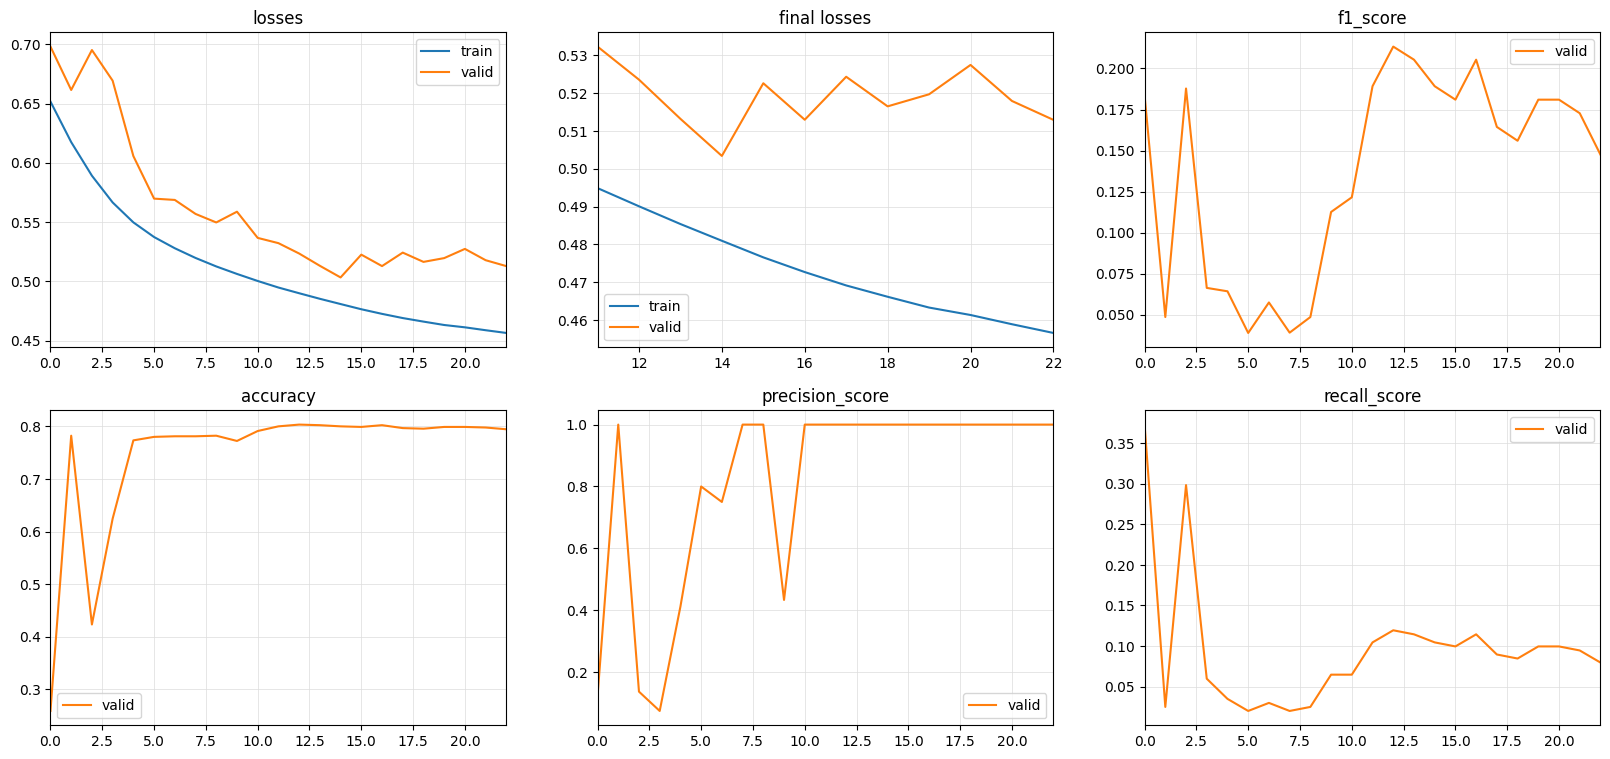

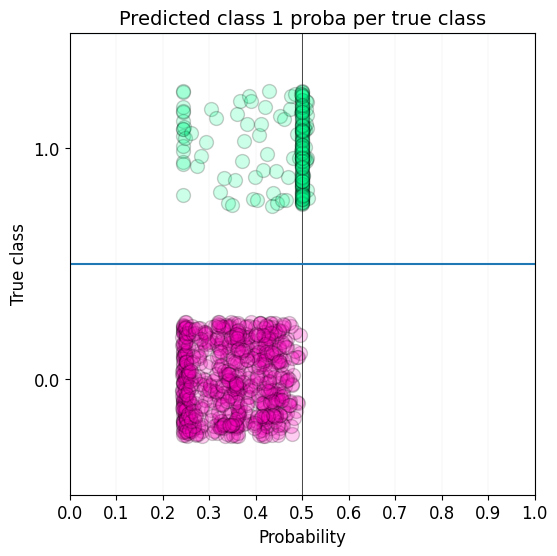

0.24086806 tensor(0.2409)
C-2,965
############# CHAN_ID = C-2 #############


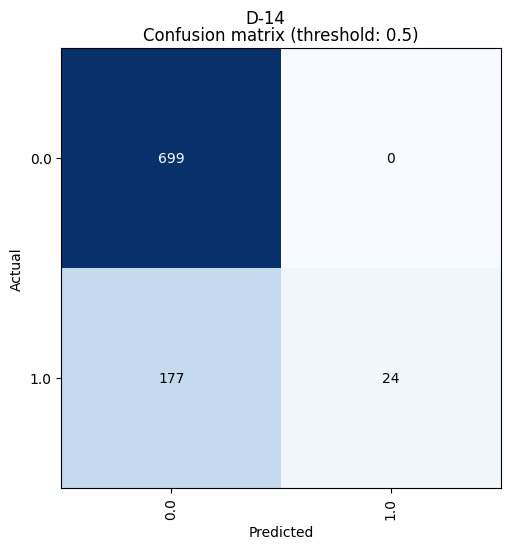

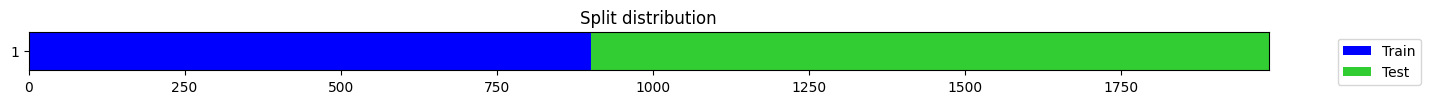

Better model found at epoch 0 with f1_score value: 0.06417112299465241.
Skipping first epoch
Epoch 1: reducing lr to 6.796320206138499e-06
Better model found at epoch 2 with f1_score value: 0.07317073170731708.
Epoch 3: reducing lr to 2.052396943252238e-05
Epoch 4: reducing lr to 2.8681425110115657e-05
Epoch 5: reducing lr to 3.633709498674819e-05
Epoch 6: reducing lr to 4.251465171938141e-05
Epoch 7: reducing lr to 4.642626999254691e-05
Epoch 8: reducing lr to 4.758804378794177e-05
Epoch 9: reducing lr to 4.738142387641845e-05
Epoch 10: reducing lr to 4.6837376625402346e-05
Epoch 11: reducing lr to 4.596368514647126e-05
Epoch 12: reducing lr to 4.477284837105926e-05
No improvement since epoch 2: early stopping

training time: 00:00:07


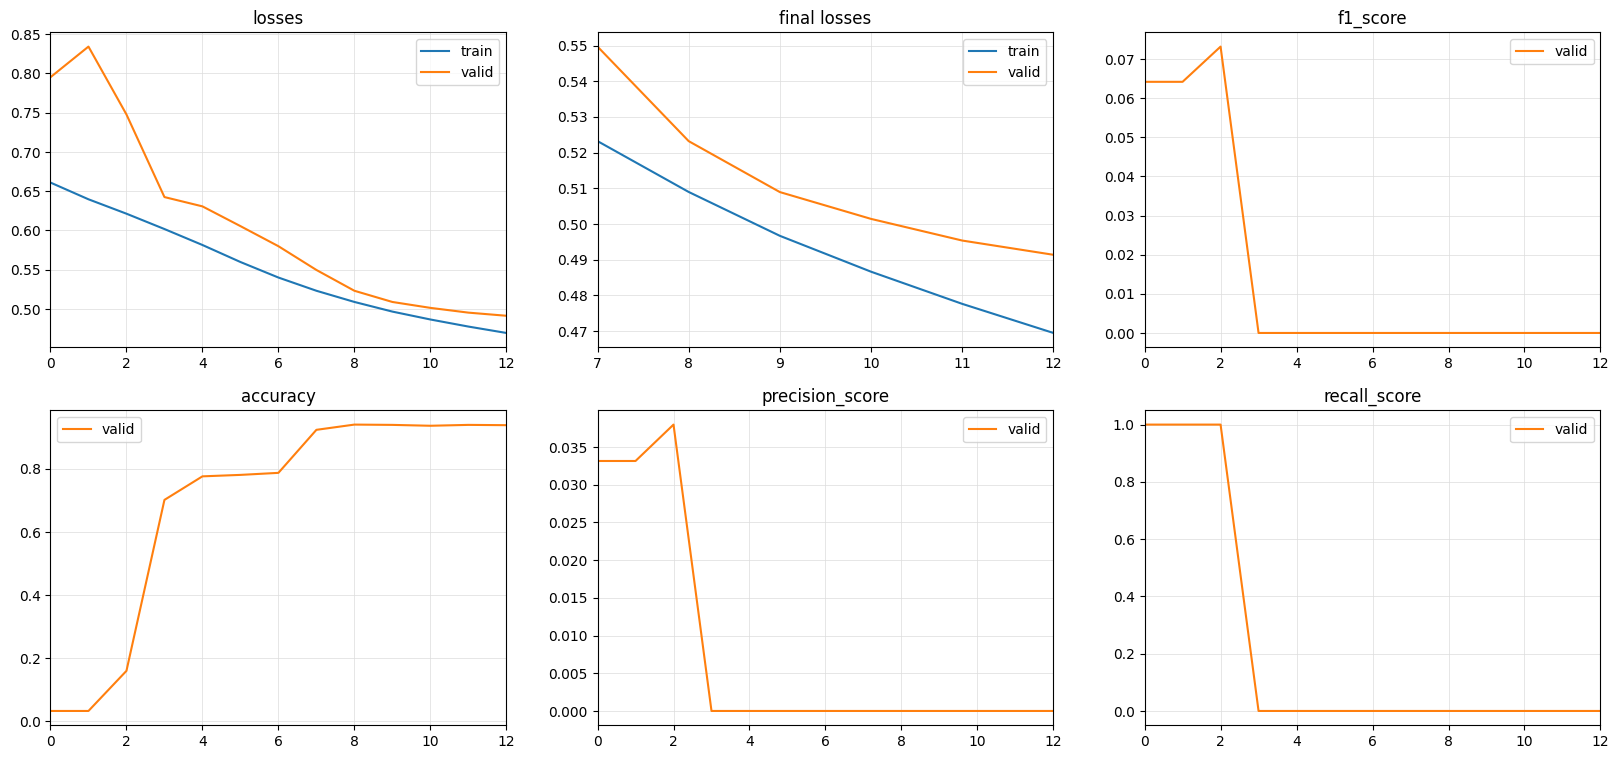

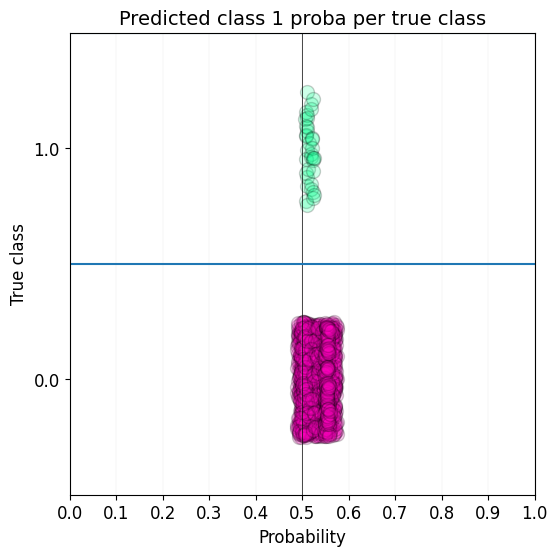

0.4255442 tensor(0.4255)
F-7,3057
############# CHAN_ID = F-7 #############


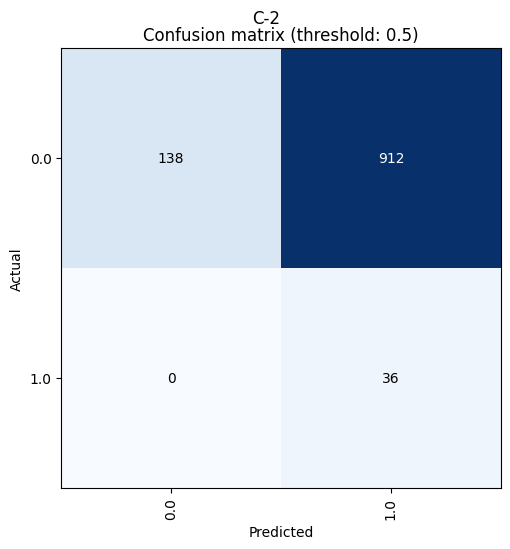

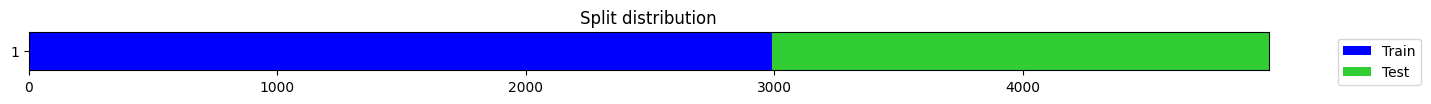

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Better model found at epoch 1 with f1_score value: 0.09628217349857007.
Better model found at epoch 2 with f1_score value: 0.2716049382716049.
Better model found at epoch 3 with f1_score value: 0.3185840707964602.
Better model found at epoch 4 with f1_score value: 0.39644970414201186.
Epoch 5: reducing lr to 3.7031928372423694e-05
Epoch 6: reducing lr to 4.30154952962983e-05
Better model found at epoch 7 with f1_score value: 0.4258064516129032.
Better model found at epoch 8 with f1_score value: 0.4575645756457564.
Epoch 9: reducing lr to 4.7342367259358926e-05
Epoch 10: reducing lr to 4.676513371653558e-05
Epoch 11: reducing lr to 4.585928946009061e-05
Epoch 12: reducing lr to 4.4637793401234224e-05
Epoch 13: reducing lr to 4.311812091767443e-05
Epoch 14: reducing lr to 4.132201245671737e-05
Epoch 15: reducing lr to 3.9275164253508695e-05
Better model found at epoch 16 with f1_score value: 0.4730290456431535.


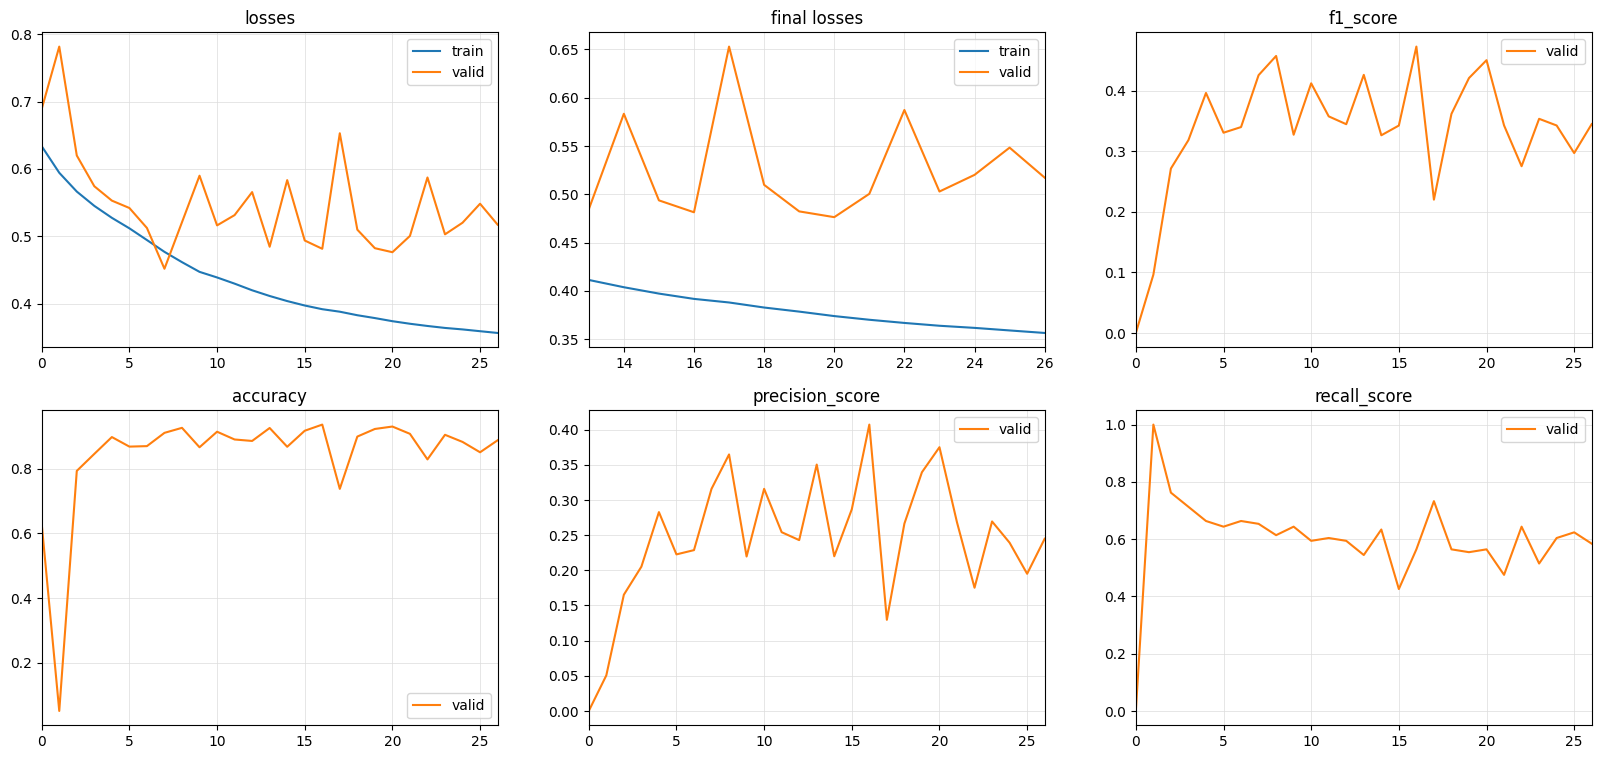

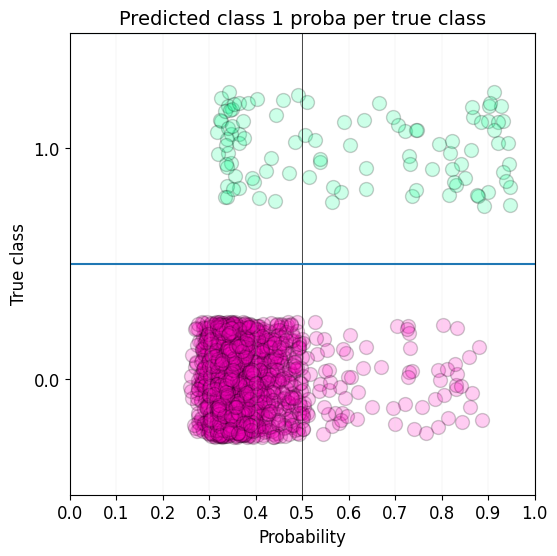

0.05227811 tensor(0.0523)
P-11,1561
############# CHAN_ID = P-11 #############


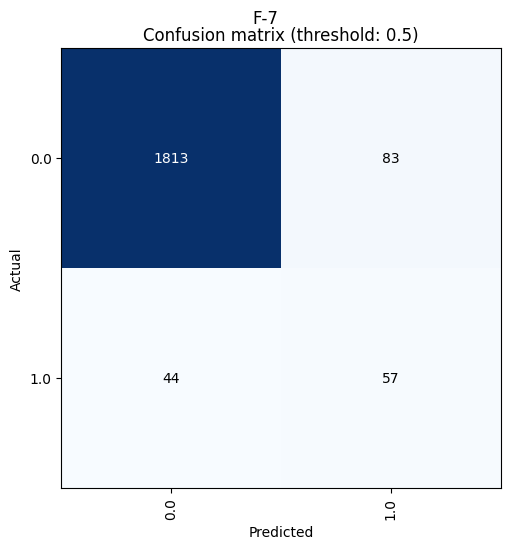

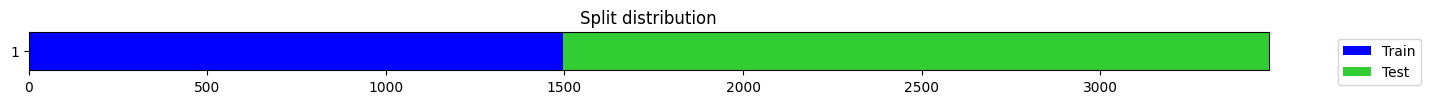

Better model found at epoch 0 with f1_score value: 0.09859154929577466.
Skipping first epoch
Epoch 1: reducing lr to 7.062928384464693e-06
Epoch 2: reducing lr to 1.327143286077782e-05
Epoch 3: reducing lr to 2.0943393704689505e-05
Epoch 4: reducing lr to 2.910040597979411e-05
Epoch 5: reducing lr to 3.6702199714521866e-05
Epoch 6: reducing lr to 4.277931841034809e-05
Epoch 7: reducing lr to 4.655674563911326e-05
Epoch 8: reducing lr to 4.758568710108776e-05
Epoch 9: reducing lr to 4.736142391126166e-05
Better model found at epoch 10 with f1_score value: 0.30136986301369867.
Epoch 11: reducing lr to 4.59095052021056e-05
Epoch 12: reducing lr to 4.470262104324697e-05
Epoch 13: reducing lr to 4.319663281747092e-05
Better model found at epoch 14 with f1_score value: 0.3513513513513513.
Better model found at epoch 15 with f1_score value: 0.43312101910828027.
Epoch 16: reducing lr to 3.7118979740380485e-05
Epoch 17: reducing lr to 3.466985724122492e-05
Better model found at epoch 18 with f1

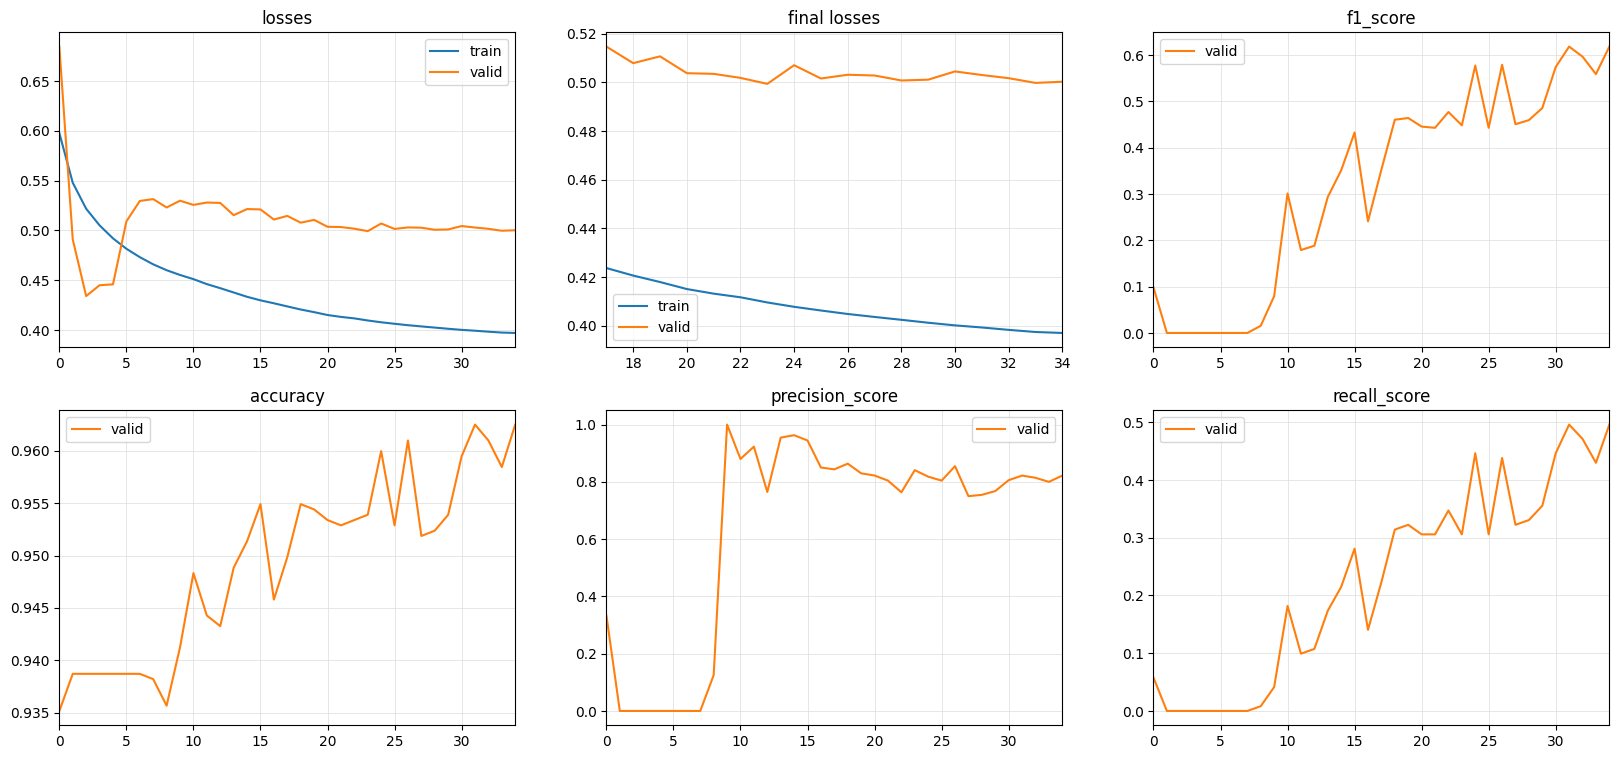

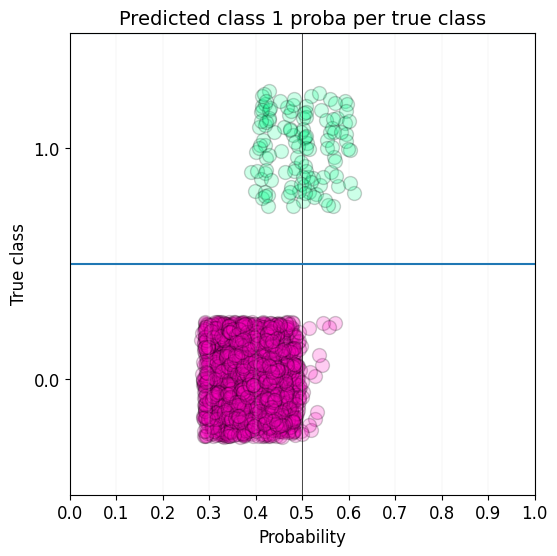

0.28278878 tensor(0.2828)
T-13,1345
############# CHAN_ID = T-13 #############


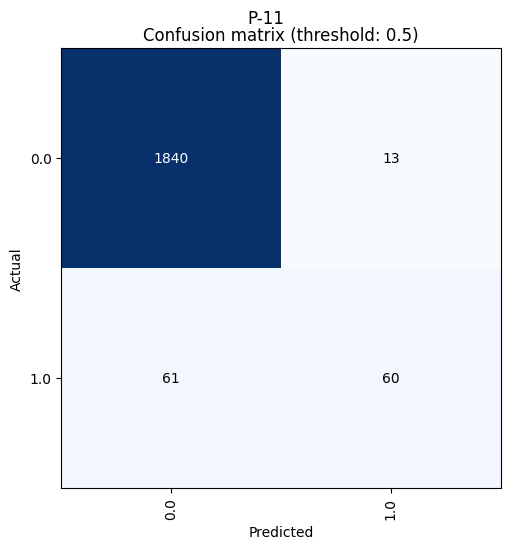

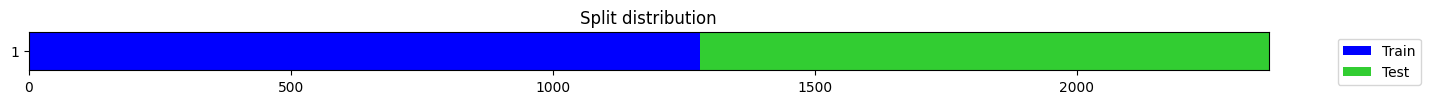

Better model found at epoch 0 with f1_score value: 0.244336569579288.
Skipping first epoch
Epoch 1: reducing lr to 7.01582489867775e-06
Epoch 2: reducing lr to 1.3207024396853125e-05
Epoch 3: reducing lr to 2.086989639743388e-05
Better model found at epoch 4 with f1_score value: 0.28307692307692306.
Epoch 5: reducing lr to 3.6638602575459945e-05
Epoch 6: reducing lr to 4.27334516572476e-05
Epoch 7: reducing lr to 4.653445867017399e-05
Epoch 8: reducing lr to 4.7586165885173675e-05
Better model found at epoch 9 with f1_score value: 0.2983751846381093.
Better model found at epoch 10 with f1_score value: 0.352112676056338.
Epoch 11: reducing lr to 4.591904806017731e-05
Epoch 12: reducing lr to 4.471496877331626e-05
Epoch 13: reducing lr to 4.3211608771113425e-05
Epoch 14: reducing lr to 4.143047534066898e-05
Epoch 15: reducing lr to 3.939704963619494e-05
Epoch 16: reducing lr to 3.714042214191259e-05
Epoch 17: reducing lr to 3.469287451890059e-05
Epoch 18: reducing lr to 3.208942556476027

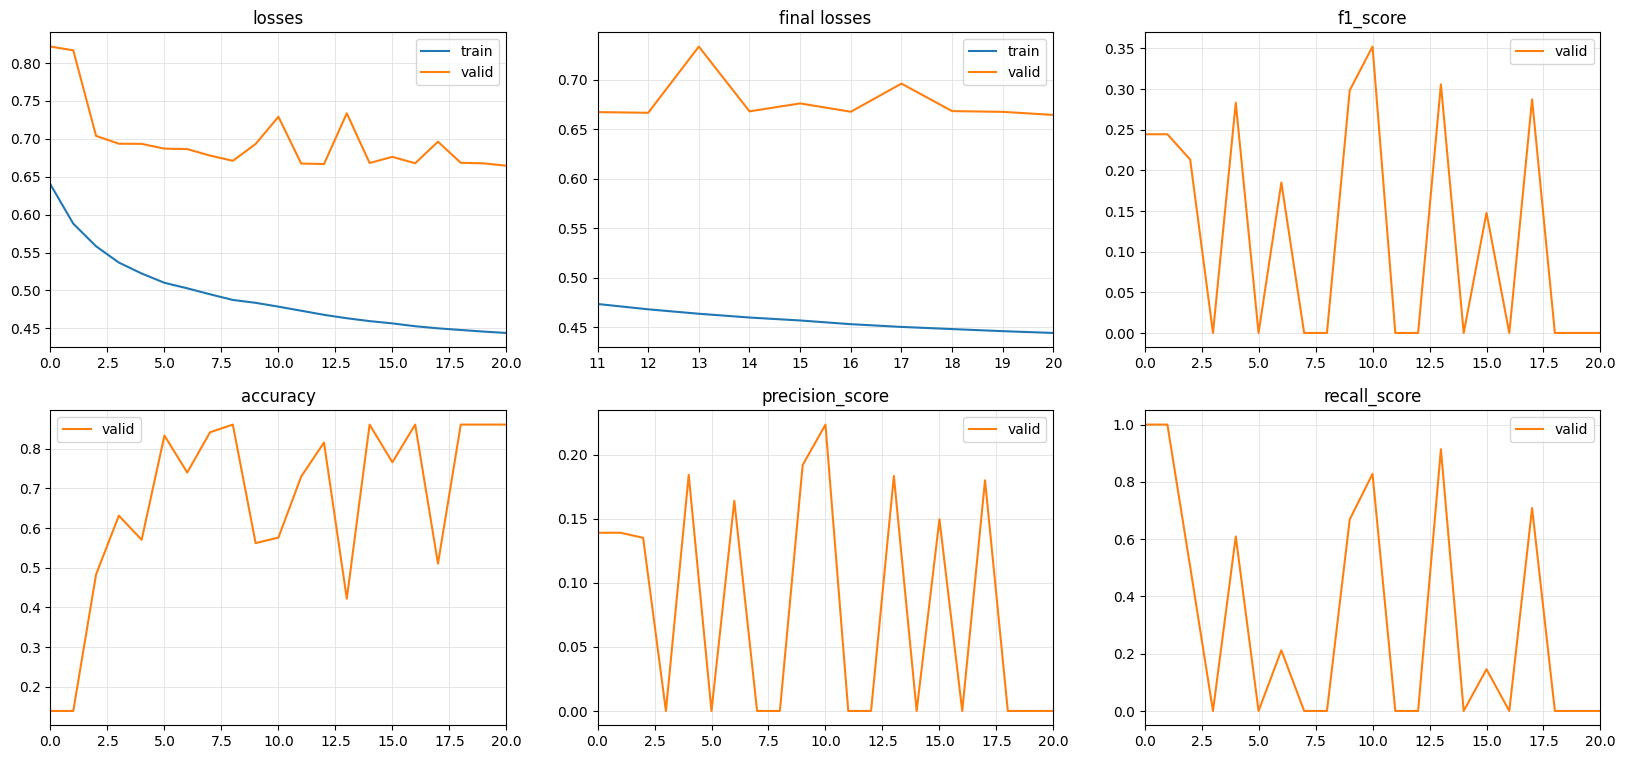

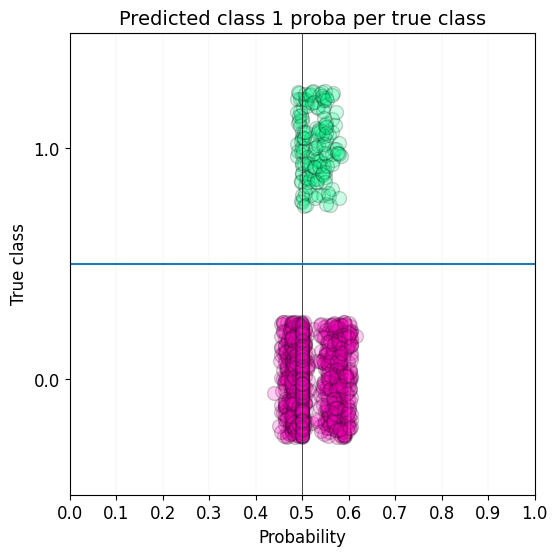

0.3832862 tensor(0.3833)
T-8,1130
############# CHAN_ID = T-8 #############


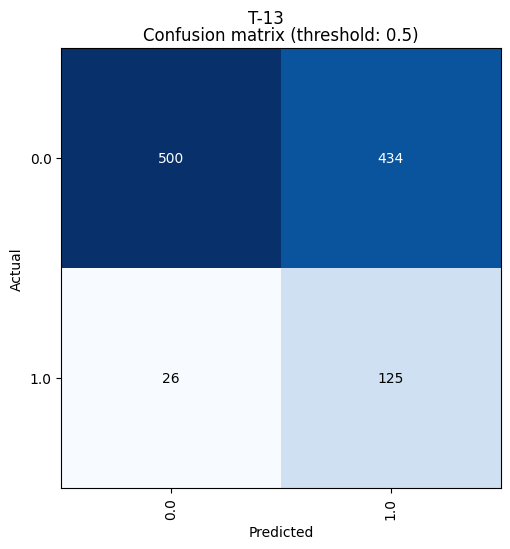

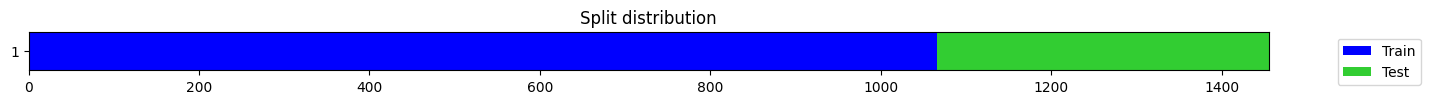

Better model found at epoch 0 with f1_score value: 0.0.
Skipping first epoch
Epoch 1: reducing lr to 6.887267174934826e-06
Epoch 2: reducing lr to 1.3030539855845161e-05
Epoch 3: reducing lr to 2.066798938123457e-05
Epoch 4: reducing lr to 2.8825610618765433e-05
Epoch 5: reducing lr to 3.646306014415485e-05
Epoch 6: reducing lr to 4.260633215832551e-05
Epoch 7: reducing lr to 4.6471973684309086e-05
Epoch 8: reducing lr to 4.758733742045443e-05
Epoch 9: reducing lr to 4.737465187254805e-05
Epoch 10: reducing lr to 4.682463572397437e-05
Epoch 11: reducing lr to 4.5945157694849036e-05
No improvement since epoch 1: early stopping

training time: 00:00:06


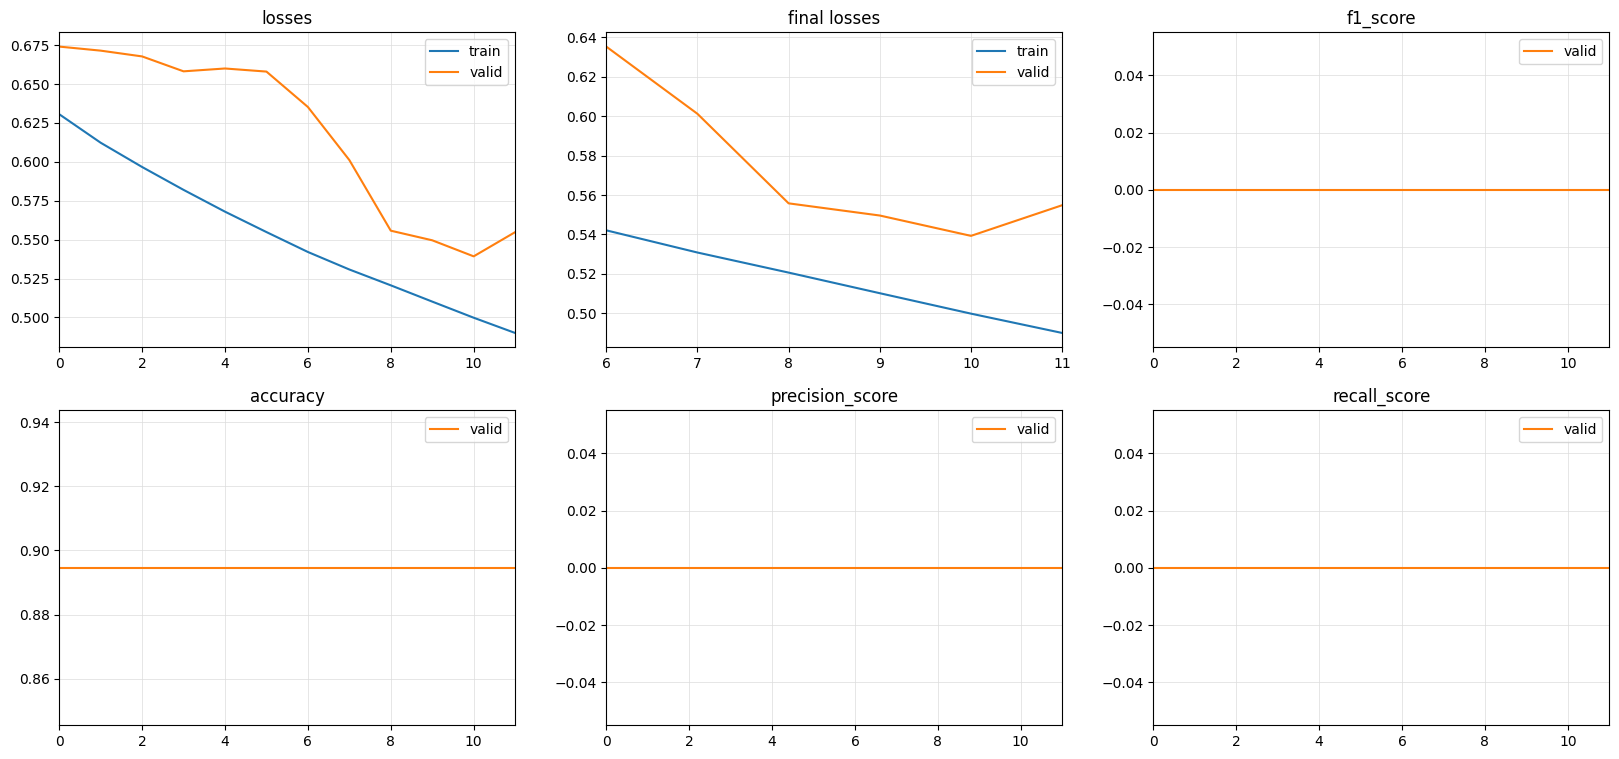

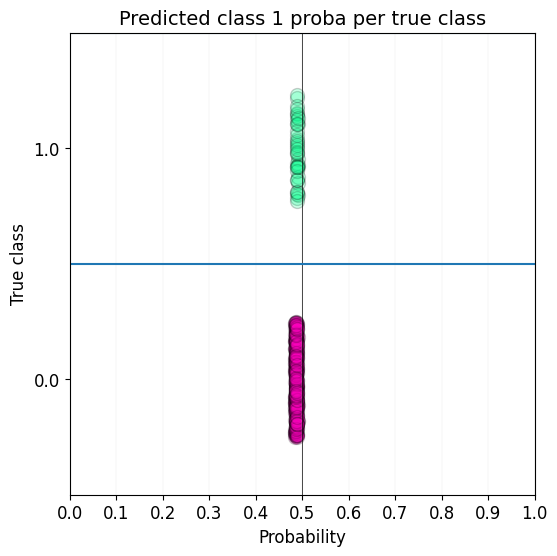

0.4847694 tensor(0.4848)
T-9,850
############# CHAN_ID = T-9 #############


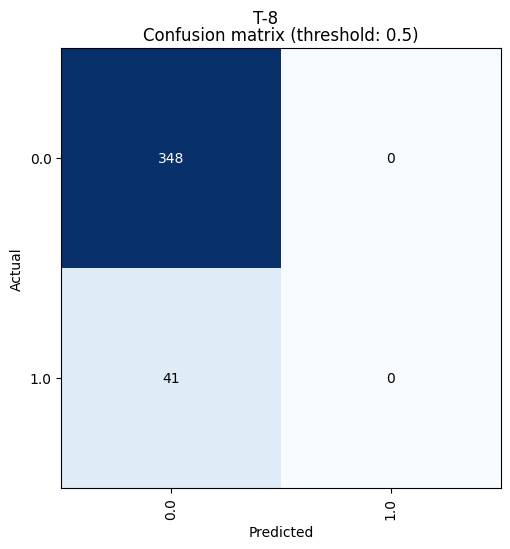

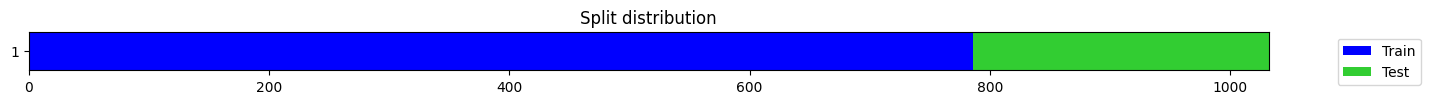

Better model found at epoch 0 with f1_score value: 0.4954128440366972.
Skipping first epoch
Epoch 1: reducing lr to 6.676206247049567e-06
Epoch 2: reducing lr to 1.2738501150579191e-05
Epoch 3: reducing lr to 2.033221667841652e-05
Epoch 4: reducing lr to 2.848892720284893e-05
Epoch 5: reducing lr to 3.616840123479906e-05
Epoch 6: reducing lr to 4.239127567804347e-05
Epoch 7: reducing lr to 4.636394583843643e-05
Epoch 8: reducing lr to 4.758881659943724e-05
Epoch 9: reducing lr to 4.7390285960220223e-05
Epoch 10: reducing lr to 4.685420105884028e-05
Epoch 11: reducing lr to 4.598823130954646e-05
No improvement since epoch 1: early stopping

training time: 00:00:04


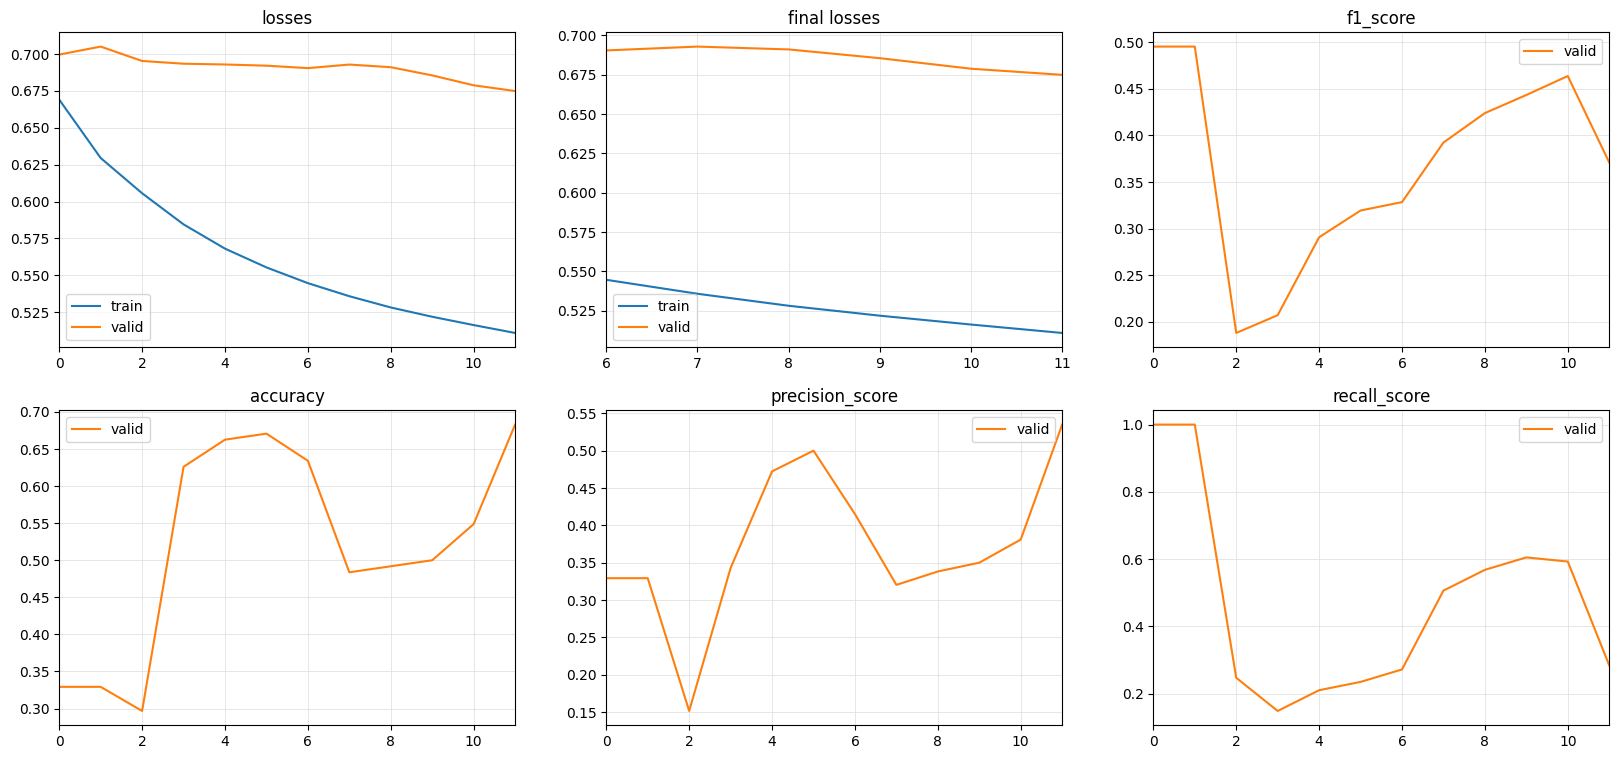

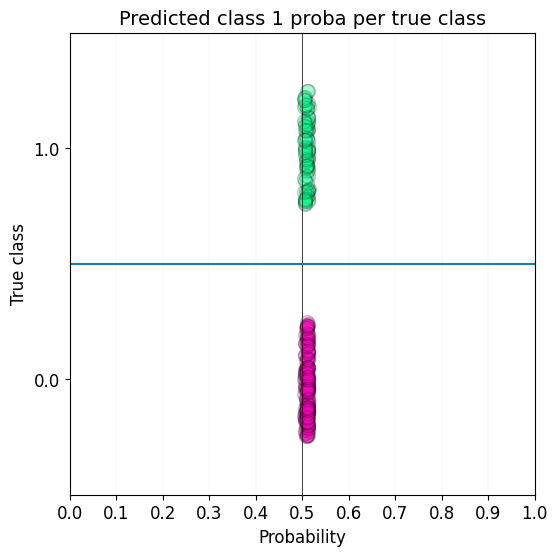

0.48588568 tensor(0.4859)


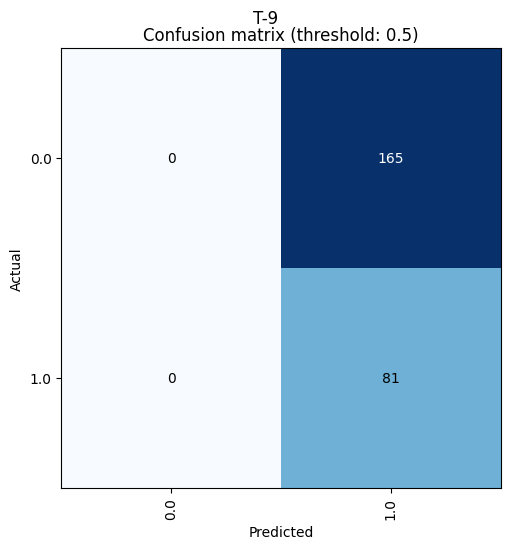

In [ ]:
##################################################################################
# Simple run through
%pdb off
import gc

def show_splitpoints(anomaly=None):
  # Find a sensible split point according to our criteria
  split_point = find_split_point(anomaly)

  print(f"{anomaly.chan_id},{split_point}")

def run_experiment(all_preds, inv_splits=False, arch='InceptionTime', arch_config={}, anomaly=None):
  # Let's do some machine learning!
  data_path = f"/content/drive/MyDrive/Colab Notebooks/data"

  # Find a sensible split point according to our criteria
  split_point = find_split_point(anomaly)

  print(f"{anomaly.chan_id},{split_point}")

  # Load the data
  file_path = os.path.join(labelled_data, f'{anomaly.chan_id}_lab.npy')
  data = np.load(file_path)

  # Plot
  #visualise(data, anomaly.chan_id, split_point, anomaly.anomaly_sequences, image_path)

  # Run the model and get the final predictions
  #from IPython.core.debugger import set_trace; set_trace()

  # Get average anomaly size
  l = 0
  c = 0
  for anomaly_sequence in anomaly.anomaly_sequences:
    l += anomaly_sequence[1] - anomaly_sequence[0] + 1
    c += 1
  avg_anom_len = l/c

  window_length = 64 #min(int(1.5 * avg_anom_len),128)
  bs = 128 #compute_batch_size(window_length+1)
  lr_max = 4.759e-04
  optimiser = 'adamw'
  loss_func = 'celf_w'
  fusion_layers = [128,128]
  fusion_dropout = 0.938
  monitor='f1_score'
  epochs=35
  patience=10
  pretrained=False
  load_weights=False

  probas, preds, probas2, f1 = run_model(data, data_path, arch=arch, arch_config=arch_config,
                                         chan_id=anomaly.chan_id, load_weights=load_weights, lr_max=lr_max, window_length=window_length, bs=bs,
                                         generate_figs=True, split_point=split_point, inv_splits=inv_splits, optimiser=optimiser, loss_func=loss_func,
                                         fusion_layers=fusion_layers, fusion_dropout=fusion_dropout, monitor=monitor,
                                         epochs=epochs, patience=patience, pretrained=pretrained)

  print(probas.min(), probas2.min())

  side = get_side(inv_splits)
  run_id = f'{anomaly.chan_id}{side}'
  all_preds[run_id] = {'chan_id' : anomaly.chan_id, 'predictions' : preds, 'probas' : probas, 'split_point' : split_point, 'probas2' : probas2, 'f1' : f1, 'inv_splits' : inv_splits}


filtered_anomalies = filter_anomalies("SMAP", 2)
filtered_anomalies += filter_anomalies("MSL", 2)
print(len(filtered_anomalies), "anomalies found matching criteria")

plot_width = 18.5/2
plot_height = 10.5/2

# Model Arch
#arch='TransformerLSTMPlus'
#arch='LSTMPlus'
arch='XceptionTimePlus'
#arch='gMLP'
#arch='InceptionTimeXLPlus'
#arch='MultiInceptionTimePlus'
#arch=xresnet34

# Model config
#arch_config = {'bidirectional':True, 'num_rnn_layers':2, "num_encoder_layers":2, "proj_dropout":0.3, "d_model":128} # TransformerLSTMPlus
#arch_config = {'bidirectional':True, 'hidden_size':[128,128], "rnn_dropout":0.3, "shuffle":False} # LSTMPlus
arch_config = {}#'fc_dropout':0.0, 'nf':48, 'depth':9} # XceptionTimePlus, InceptionTimeXLPlus

all_preds = {}

for anomaly in filtered_anomalies:
  show_splitpoints(anomaly)

#raise KeyboardInterrupt

def clear_caches():
  gc.collect()

  try:
    whoops = 1/0
  except:
    pass

# Let's visualise them
for anomaly in filtered_anomalies:
  clear_caches()

  run_experiment(all_preds, inv_splits=False, arch=arch, arch_config=arch_config, anomaly=anomaly)
  #run_experiment(all_preds, inv_splits=True, arch=arch, arch_config=arch_config)


In [ ]:
def find_anomaly_sequences(predictions, offset=0):
    """
    Given a numpy array of predicted classes, finds sequences where class 1 is predicted.
    Returns a list of [begin, end] indices for each sequence.
    """
    print(predictions.sum())

    # Find the start and end of anomaly sequences
    diff = np.concatenate(([0], predictions, [0]))  # Add padding to identify starts/ends
    diff = diff[1:] - diff[:-1]

    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0] - 1  # Subtracting 1 to get the last index of anomaly sequence

    sequences = list(zip(starts + offset, ends + offset))

    return sequences


def evaluate_predictions(predicted_anomaly_sequences, anomaly_sequences):
    tp, fp, fn = 0, 0, 0

    # Helper function to check if two sequences overlap
    def is_overlapping(seq1, seq2):
        return seq1[0] <= seq2[1] and seq2[0] <= seq1[1]

    matched_true_sequences = set()  # Set to hold true sequences that are matched with a prediction
    matched_predicted_sequences = set()  # Set to hold predicted sequences that matched a true sequence

    for true_seq in anomaly_sequences:
        overlaps_with_true_seq = [pred_seq for pred_seq in predicted_anomaly_sequences if is_overlapping(pred_seq, true_seq)]
        if overlaps_with_true_seq:
            # Count the first overlapping prediction as a true positive, others as false positives
            tp += 1
            matched_predicted_sequences.add(overlaps_with_true_seq[0])
            for overlap in overlaps_with_true_seq[1:]:
                matched_predicted_sequences.add(overlap)
                fp += 1
            matched_true_sequences.add(tuple(true_seq))

    # Count the predicted sequences that didn't match any true sequence as false positives
    fp += len(predicted_anomaly_sequences) - len(matched_predicted_sequences)
    # Count the true sequences that didn't match any prediction as false negatives
    fn = len(anomaly_sequences) - len(matched_true_sequences)

    return tp, fp, fn


def merge_sequences(sequences, max_distance=10):
    merged_sequences = []

    if len(sequences) > 0:
      current_sequence = sequences[0]

      for i in range(1, len(sequences)):
          if sequences[i][0] - current_sequence[1] <= max_distance:
              current_sequence = (current_sequence[0], sequences[i][1])
          else:
              merged_sequences.append(current_sequence)
              current_sequence = sequences[i]

      merged_sequences.append(current_sequence)

    return merged_sequences

def prune_sequences(sequences, min_length=5):
    pruned_sequences = [seq for seq in sequences if seq[1] - seq[0] + 1 >= min_length]

    return pruned_sequences

def f1_score(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    if precision + recall == 0:
        return 0
    return 2 * precision * recall / (precision + recall)

def process_results(run_id, anomaly, thr=0.25):
  preds = all_preds[run_id]['predictions']

  chan_f1 = all_preds[run_id]['f1']

  if chan_f1 < thr:
    #print(chan_id,"skipped; F1 too low", chan_f1)
    return 0,0,0
  else:
    #print(chan_id, "F1 =", chan_f1)

    inv_splits = all_preds[run_id]['inv_splits']

    offset = 0
    if inv_splits == False:
      offset = all_preds[run_id]['split_point']

    pred_anomaly_sequences = find_anomaly_sequences(preds, offset=offset)
    pred_anomaly_sequences = merge_sequences(pred_anomaly_sequences)
    pred_anomaly_sequences = prune_sequences(pred_anomaly_sequences)

    # Trim to split point
    split_point = all_preds[run_id]['split_point']
    if inv_splits == True:
      filtered_sequences = [(begin, end) for (begin, end) in anomaly.anomaly_sequences if begin < split_point]
    else:
      filtered_sequences = [(begin, end) for (begin, end) in anomaly.anomaly_sequences if end > split_point]

    #print(run_id, "predicted:", pred_anomaly_sequences, "true:", filtered_sequences)

    print(pred_anomaly_sequences, filtered_sequences)

    tp, fp, fn = evaluate_predictions(pred_anomaly_sequences, filtered_sequences)
    print(f"{run_id} Total anomalies: {len(pred_anomaly_sequences)}, TP: {tp}, FP: {fp}, FN: {fn}")

    return tp, fp, fn

sum_tp = 0
sum_fp = 0
sum_fn = 0

for anomaly in filtered_anomalies:
  chan_id = anomaly.chan_id

  thr=0.0
  tp, fp, fn = process_results(chan_id, anomaly, thr=thr)
  sum_tp += tp
  sum_fp += fp
  sum_fn += fn

  #tp, fp, fn = process_results(f'{chan_id}_b', anomaly, thr=thr)
  #sum_tp += tp
  #sum_fp += fp
  #sum_fn += fn

print("F1 score for set is", f1_score(sum_tp, sum_fp, sum_fn))

# Sorting by 'f1'
sorted_runs = sorted(all_preds.items(), key=lambda x: x[1]['f1'], reverse=True)

# Printing out sorted results with inv_splits=False
for run_id, metrics in sorted_runs:
    if not metrics['inv_splits']:
        print(f"{run_id}: F1 = {metrics['f1']}")

337
[(1561, 1630), (1676, 1811), (2067, 2140), (2185, 2263)] [(2100, 2210)]
C-1 Total anomalies: 4, TP: 1, FP: 3, FN: 0
900
[(1725, 2624)] [(1800, 2000)]
D-14 Total anomalies: 1, TP: 1, FP: 0, FN: 0
689
[(965, 1047), (1089, 1172), (1226, 1234), (1252, 1420), (1465, 1573), (1605, 1662), (1704, 1850), (1897, 1931)] [(1540, 1575)]
C-2 Total anomalies: 8, TP: 1, FP: 7, FN: 0
271
[(3320, 3328), (3345, 3442), (4074, 4137), (4489, 4515), (4526, 4603), (4927, 4954)] [(3325, 3425)]
F-7 Total anomalies: 6, TP: 1, FP: 5, FN: 0
62
[(1823, 1881)] [(1778, 1898)]
P-11 Total anomalies: 1, TP: 1, FP: 0, FN: 0
537
[(1471, 2011)] [(1900, 2050)]
T-13 Total anomalies: 1, TP: 1, FP: 0, FN: 0
389
[(1130, 1518)] [(1330, 1370)]
T-8 Total anomalies: 1, TP: 1, FP: 0, FN: 0
153
[(874, 952), (1022, 1095)] [(890, 970)]
T-9 Total anomalies: 2, TP: 1, FP: 1, FN: 0
F1 score for set is 0.5
P-11: F1 = 0.6557377049180327
T-9: F1 = 0.5384615384615384
F-7: F1 = 0.446236559139785
D-14: F1 = 0.36512261580381467
T-13: F1 = 0.

In [ ]:
def print_anomaly_counts(spacecraft):
  filtered_anomalies = filter_anomalies(spacecraft, 2)

  tot_train = 0
  tot_test = 0

  for anomaly in filtered_anomalies:
    sp = find_split_point(anomaly)
    n_train = 0
    n_test = 0
    for anomaly_sequence in anomaly.anomaly_sequences:
      if anomaly_sequence[1] < sp:
        n_train += 1
      else:
        n_test += 1

    print(anomaly.chan_id, "&", n_train, "&", n_test, "\\\\")

    tot_train += n_train
    tot_test += n_test

  print("Total", "&", tot_train, "&", tot_test, "\\\\")


spacecraft = ["SMAP","MSL"]
all_filtered = []

for sc in spacecraft:
  #print("\\multicolumn{3}{l}{",sc,"}\\\\")
  #print_anomaly_counts(sc)

  filtered_anomalies = filter_anomalies(sc, 2)
  for anomaly in filtered_anomalies:
    #print(anomaly.chan_id)
    all_filtered.append(anomaly.chan_id)

print(all_filtered)


['E-1', 'E-12', 'E-11', 'E-10', 'E-13', 'G-7', 'P-1', 'P-4', 'T-1', 'T-3', 'C-1', 'D-14', 'C-2', 'F-7', 'P-11', 'T-13', 'T-8', 'T-9']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Accumulate all anomaly percentages in a list
anomaly_percentages = []

for anomaly in anomalies:
    sum_of_anoms = 0
    for anomaly_sequence in anomaly.anomaly_sequences:
        sum_of_anoms += (anomaly_sequence[1] - anomaly_sequence[0])
    percentage = sum_of_anoms / anomaly.num_values * 100
    anomaly_percentages.append(percentage)
    #print(anomaly.chan_id, percentage)

# Plot the histogram
plt.hist(anomaly_percentages, bins=30, density=True, alpha=0.6, color='g', label="Data")

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(anomaly_percentages), np.std(anomaly_percentages))
plt.plot(x, p, 'k', linewidth=2, label="Fit")

title = "Fit results: mean = %.2f,  std = %.2f" % (np.mean(anomaly_percentages), np.std(anomaly_percentages))
plt.title(title)
plt.legend()
plt.show()

from scipy.stats import gamma, lognorm

# Using the Gamma distribution
a, loc, scale = gamma.fit(anomaly_percentages)
x = np.linspace(xmin, xmax, 100)
pdf_gamma = gamma.pdf(x, a, loc=loc, scale=scale)

plt.hist(anomaly_percentages, bins=30, density=True, alpha=0.6, color='g', label="Data")
plt.plot(x, pdf_gamma, 'b-', linewidth=2, label="Gamma Fit")

# Set the title and labels
plt.title("Gamma Fit")
plt.xlabel('Anomaly Percentage')
plt.ylabel('Density')
plt.legend()
plt.show()

# Using the Log-normal distribution
s, loc, scale = lognorm.fit(anomaly_percentages, floc=0)
pdf_lognorm = lognorm.pdf(x, s, loc=loc, scale=scale)

plt.hist(anomaly_percentages, bins=30, density=True, alpha=0.6, color='g', label="Data")
plt.plot(x, pdf_lognorm, 'r-', linewidth=2, label="Log-normal Fit")

# Annotate the median
median = np.median(data)
plt.axvline(median, color='blue', linestyle='dashed', linewidth=1)
plt.text(0.5+median, 0.17, 'Median: {:.2f}'.format(median), rotation=0, color='blue')

# Set the title and labels
plt.title("Log-normal Fit")
plt.xlabel('Anomaly Percentage')
plt.ylabel('Density')
plt.legend()
plt.savefig("log_normal_fit.pdf")
plt.show()

import numpy as np
from scipy.stats import kstest, norm, gamma, lognorm

# Sample data (replace with your anomaly percentages)
data = np.array(anomaly_percentages)

# Fit data to each distribution and get parameters
normal_params = norm.fit(data)
gamma_params = gamma.fit(data)
lognorm_params = lognorm.fit(data)

# Run K-S test
ks_stat_normal, ks_p_value_normal = kstest(data, 'norm', normal_params)
ks_stat_gamma, ks_p_value_gamma = kstest(data, 'gamma', gamma_params)
ks_stat_lognorm, ks_p_value_lognorm = kstest(data, 'lognorm', lognorm_params)

print("Normal Distribution: K-S Statistic:", ks_stat_normal, "P-Value:", ks_p_value_normal)
print("Gamma Distribution: K-S Statistic:", ks_stat_gamma, "P-Value:", ks_p_value_gamma)
print("Log-Normal Distribution: K-S Statistic:", ks_stat_lognorm, "P-Value:", ks_p_value_lognorm)

print(np.min(data), np.max(data))




In [ ]:
# Optimise
import gc

from optuna import logging
from optuna.pruners import BasePruner
from optuna.samplers import TPESampler

_logger = logging.get_logger(__name__)


class DuplicateIterationPruner(BasePruner):
    """
    DuplicatePruner

    Pruner to detect duplicate trials based on the parameters.

    This pruner is used to identify and prune trials that have the same set of parameters
    as a previously completed trial.
    """

    def prune(
        self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial"
    ) -> bool:
        completed_trials = study.get_trials(states=[optuna.trial.TrialState.COMPLETE])

        for completed_trial in completed_trials:
            if completed_trial.params == trial.params:
                return True

        return False

# Use one data set from each type

# Cluster 0 = E-10
# Cluster 1 = P-4
# Cluster 2 = T-3
# Cluster 3 = G-7
cluster_data = ['E-10', 'P-4', 'T-3', 'G-7']

filtered_anomalies = filter_anomalies("SMAP", 2)

inv_splits = False
data_path = f"/content/drive/MyDrive/Colab Notebooks/data"

arch='XceptionTimePlus'
arch_config={}

def objective(trial):
  lr_max=trial.suggest_float("lr_max", 1e-8, 1e-3)
  window_length=trial.suggest_categorical("window_length", [64,128,256,512])
  bs=trial.suggest_categorical("bs", [64,128,256,512]),
  optimiser=trial.suggest_categorical("optimiser", ['lookahead_lamb', 'lamb', 'sgd', 'adamw', 'rmsprop', 'radam', 'adam'])
  loss_func=trial.suggest_categorical("loss_func", ['fl', 'celf', 'celf_w', 'cel_w', 'cel', 'flf', 'flf_w'])
  fusion_layers=trial.suggest_categorical("fusion_layers", [[64], [64,64], [128], [128,128]])
  fusion_dropout=trial.suggest_float("fusion_dropout", 0, 1)

  print(lr_max, window_length, bs, optimiser, loss_func, fusion_layers, fusion_dropout)

  all_preds = {}

  for cluster in cluster_data:
    gc.collect()

    # Find anomalies corresponding to cluster
    anomaly = None
    for a in filtered_anomalies:
      if a.chan_id == cluster:
        anomaly = a
        break
    assert anomaly is not None

    # Find a sensible split point according to our criteria
    split_point = find_split_point(anomaly)

    # Load the data
    file_path = os.path.join(labelled_data, f'{anomaly.chan_id}_lab.npy')
    data = np.load(file_path)

    probas, preds, probas2, f1 = run_model(data, data_path, arch=arch, arch_config=arch_config,
                                         chan_id=anomaly.chan_id, load_weights=False, lr_max=lr_max, window_length=window_length, bs=bs,
                                         generate_figs=False, split_point=split_point, inv_splits=inv_splits, optimiser=optimiser, loss_func=loss_func,
                                         fusion_layers=fusion_layers, fusion_dropout=fusion_dropout, monitor='f1_score', verbose=False)

    side = get_side(inv_splits)
    run_id = f'{anomaly.chan_id}{side}'
    all_preds[run_id] = {'chan_id' : anomaly.chan_id, 'predictions' : preds, 'probas' : probas,
                         'split_point' : split_point, 'probas2' : probas2, 'f1' : f1, 'inv_splits' : inv_splits}

  # Calculate average F1 score
  f1_values = [v['f1'] for v in all_preds.values()]
  average_f1 = sum(f1_values) / len(f1_values)

  return average_f1

def print_best_callback(study, trial):
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

pruner = DuplicateIterationPruner()
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=250, show_progress_bar=True, callbacks=[print_best_callback])
print(study.best_trial.value)  # Show the best value.






In [ ]:
%pdb off
import gc

##################################################################################
# Fine-tune learning
def fine_tune_model(train_chans, data_path, arch=None, arch_config=None, load_weights=False, thr=0.5,
                    generate_figs=False, lr_max = 1e-3, window_length=64, bs=64,
                    split_points=None, inv_splits=False, epochs=35, patience=10, min_delta=0.001,
                    monitor='f1_score', seed=42, optimiser='adam'):
  # We assume the training channels are in order of:
  # Load train_chans[0]
  # For each remaining channel i
  #   fine_tune(train_chans[i])

  chans_string = ""  # Initialize an empty string to store the combined entries
  for chan_id in train_chans:
      chans_string += f'{chan_id}_'

  print('Processing', chans_string)  # Print the final combined string
  model_import = f"{data_path}/models/{arch}_model_{train_chans[0]}.pkl"
  model_export = f"{data_path}/models/{arch}_model_{chans_string}.pkl"
  weights_import = f"{data_path}/weights/{arch}_weights_{train_chans[0]}"
  weights_export = f"{data_path}/weights/{arch}_weights_{chans_string}"
  image_path = f"{data_path}/img/{chans_string}"
  logs = f"{data_path}/logs/{arch}_{chans_string}"

  learn = None

  # Fine tune on the 0..nth data sets
  for idx in range(0, len(train_chans)):
    print(f'############# CHAN_ID = {train_chans[idx]} #############')

    # Load the data
    data = train_data[idx]
    split_point = split_points[idx]

    # Prep data
    dls,y = prep_data(data, window_length, split_point, seed, generate_figs, bs, inv_splits, train_chans[idx])

    append = True
    if idx > 1:
      append = False

    # Create the callbacks
    cbs = get_callbacks(monitor, min_delta, patience, weights_export, logs, append=append)
    metrics = get_metrics()

    base_lr = 1e-5
    freeze_epochs = 10

    if idx > 0:
      #try:
      learn = create_learner(dls, arch, arch_config, metrics, False, seed, False,
                               get_optimiser(opt=optimiser), pretrained=True, weights_path=f'{weights_export}.pth')
      #except:
      #  print('Could not load weights from', weights)

      start = time.time()
      learn.fine_tune(epochs, cbs=cbs, base_lr=base_lr, freeze_epochs=freeze_epochs)
      print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
    else:
      learn = create_learner(dls, arch, arch_config, metrics, False, seed, False, get_optimiser(opt=optimiser), pretrained=False)
      if load_weights == True:
        try:
          learn.load(weights_import)
        except:
          print('Could not load weights from', weights_import)
      else:
        # Run the learner
        run_learner(learn, y, epochs, lr_max, cbs)
  # END FOR

  if generate_figs == True: save_results_fig(learn, image_path, train_chans[idx])

  # save to gdrive
  learn.export(model_export)

  # Return results
  return get_results_from_learner(learn, thr)

##################################################################################
# Run it

spacecraft='SMAP'
best_to_worst = True

filtered_anomalies = filter_anomalies(spacecraft, 2)
print(len(filtered_anomalies), "anomalies found matching criteria")

plot_width = 18.5/2
plot_height = 10.5/2

# Model Arch
#arch='TransformerLSTMPlus'
#arch='LSTMPlus'
#arch='XceptionTimePlus'
#arch='InceptionTimeXLPlus'
arch='MultiInceptionTimePlus'

# Model config
#arch_config = {'bidirectional':True, 'num_rnn_layers':2, "num_encoder_layers":2, "proj_dropout":0.3, "d_model":128} # TransformerLSTMPlus
#arch_config = {'bidirectional':True, 'hidden_size':[128,128], "rnn_dropout":0.3, "shuffle":False} # LSTMPlus
arch_config = {}#'fc_dropout':0.5, 'nf':48, 'depth':9} # XceptionTimePlus, InceptionTimeXLPlus

all_preds = {}

train_chans_smap = ['E-11','E-10']#'E-10','G-7','P-4','E-1','T-1'] # best/worst SMAP
train_chans_msl = ['F-7','D-14','P-11','T-9'] # best MSL

train_chans = None
if spacecraft == 'MSL':
  train_chans = train_chans_msl
else:
  train_chans = train_chans_smap

if best_to_worst == False: train_chans.reverse() #worst
valid_chan = ''

train_data = []
valid_data = None
split_points = []

# Load the training data and calculate splits
for chan_id in train_chans:
  gc.collect()

  for anomaly in filtered_anomalies:
    if anomaly.chan_id == chan_id:
      print(chan_id)

      # Find a sensible split point according to our criteria
      split_point = find_split_point(anomaly)
      split_points.append(split_point)

      # Load the data
      file_path = os.path.join(labelled_data, f'{anomaly.chan_id}_lab.npy')
      data = np.load(file_path)
      train_data.append(data)

      break

window_length = 64 #min(int(1.5 * avg_anom_len),128)
bs = compute_batch_size(window_length+1)
lr_max = 1e-5
inv_splits = False

data_path = f"/content/drive/MyDrive/Colab Notebooks/data"
probas, preds, probas2, f1 = fine_tune_model(train_chans, data_path, arch=arch, arch_config=arch_config, load_weights=False, thr=0.5,
                    generate_figs=False, lr_max = lr_max, window_length=window_length, bs=bs, inv_splits=inv_splits, epochs=35,
                    patience=10, min_delta=0.001, split_points=split_points, monitor='f1_score', seed=42, optimiser='adamw')
side = get_side(False)
run_id = f'{anomaly.chan_id}{side}'
all_preds[run_id] = {'chan_id' : anomaly.chan_id, 'predictions' : preds, 'probas' : probas, 'split_point' : split_point, 'probas2' : probas2, 'f1' : f1, 'inv_splits' : inv_splits}


Automatic pdb calling has been turned OFF
10 anomalies found matching criteria
E-11
E-10
Processing E-11_E-10_
############# CHAN_ID = E-11 #############


Better model found at epoch 0 with f1_score value: 0.03398208217485326.
Better model found at epoch 1 with f1_score value: 0.14768065635847272.
Epoch 2: reducing lr to 2.888503217225014e-07
Epoch 3: reducing lr to 4.514051948516173e-07
Epoch 4: reducing lr to 6.227080240965594e-07
Epoch 5: reducing lr to 7.809124295208482e-07
Epoch 6: reducing lr to 9.058426092288367e-07
Epoch 7: reducing lr to 9.81566186959204e-07


KeyboardInterrupt: ignored

Loading /content/drive/MyDrive/Colab Notebooks/data/models/InceptionTimeXLPlus_model_E-11_E-10_G-7_P-42.pkl
Loading /content/drive/MyDrive/Colab Notebooks/data/models/InceptionTimeXLPlus_model_E-11_E-10_G-7_P-4.pkl


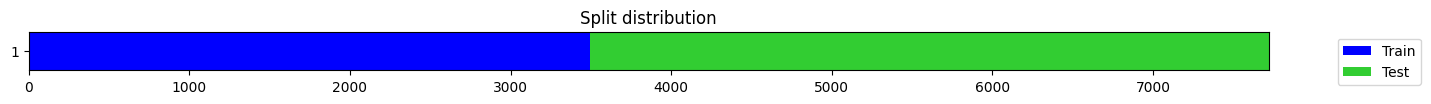

AttributeError: ignored

In [ ]:
##########################################################
# Load in the previously trained model

train_chans = ['E-11','E-10','G-7','P-4','E-1','T-1']

file_path = os.path.join(labelled_data, f'{valid_chan}_lab.npy')
valid_data = np.load(file_path)

chans_string = ""  # Initialize an empty string to store the combined entries
for chan_id in train_chans:
    chans_string += f'{chan_id}_'
chans_string += valid_chan

weights_export = f"/content/drive/MyDrive/Colab Notebooks/data/weights/{arch}_weights_{chans_string}2"
model_import = f"/content/drive/MyDrive/Colab Notebooks/data/models/{arch}_model_{chans_string}.pkl"
model_export = f"/content/drive/MyDrive/Colab Notebooks/data/models/{arch}_model_{chans_string}2.pkl"
logs = f"/content/drive/MyDrive/Colab Notebooks/data/logs/{arch}_{chans_string}"

def load_from_model():
  learn = None
  try:
    print(f"Loading {model_export}")
    learn = load_learner(model_export)
  except:
    try:
      print(f"Loading {model_import}")
      learn = load_learner(model_import)
    except:
      print("failed to load model")
  return learn

learn = load_from_model()

# Try it out on the validation set
data = valid_data
# Args to SlidingWindow
window_length = 64
stride = window_length # no overlap
horizon = None
get_x = list(np.arange(data.shape[1]-1))
get_y = data.shape[1]-1
seq_first = True
random_start = 0

def y_max(o): return np.max(o, axis=1)

# Apply sliding window
X,y = SlidingWindow(window_length, get_x = get_x, get_y=get_y, y_func=y_max)(data)

# Find the splits
split_point = 0
# Load the training data and calculate splits
filtered_anomalies = filter_anomalies("SMAP", 2)
for anomaly in filtered_anomalies:
  if anomaly.chan_id == valid_chan:
    # Find a sensible split point according to our criteria
    split_point = find_split_point(anomaly)

splits,fig = get_splits(y, valid_size=(len(data)-split_point), stratify=True, random_state=23, shuffle=False, return_figure=True)

tfms = [None, Categorize()]
batch_tfms = []
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)

patience = 5
cbs = [EarlyStoppingCallback(monitor='f1_score', min_delta=0.01, patience=patience),
      SaveModelCallback(monitor='f1_score', min_delta=0.01, fname=weights_export),
      CSVLogger(fname=f"{logs}_log2.csv")]

f1score = F1Score()
roc = RocAucBinary()
metrics = [roc, f1score]
epochs = 25

learn.dls = dls

start = time.time()
learn.fine_tune(epochs, cbs=cbs)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

image_path = f"/content/drive/MyDrive/Colab Notebooks/data/img/{chans_string}"

# Produce some graphics
fig = learn.plot_metrics()
fig.suptitle(chans_string)
fig.set_layout_engine('tight')
fig.savefig(f'{image_path}_metrics.pdf')

#ipdb.set_trace()
fig = learn.show_probas()
fig.suptitle(chans_string)
fig.savefig(f'{image_path}_probas.pdf')

#interp = ClassificationInterpretation.from_learner(learn)
fig = learn.plot_confusion_matrix()
fig.set_figheight(fig.get_figheight()+0.5)
fig.suptitle(chans_string)
fig.savefig(f'{image_path}_confusion_matrix.pdf')

# save to gdrive
learn.export(model_export)

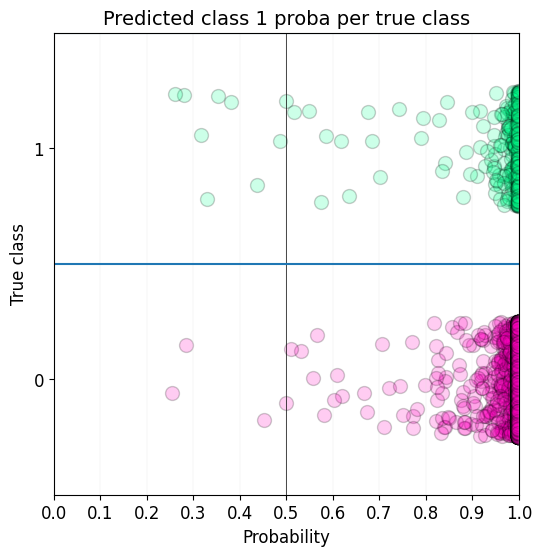

tensor([[1.0317e-03, 9.9897e-01],
        [1.0862e-03, 9.9891e-01],
        [8.2667e-04, 9.9917e-01],
        ...,
        [2.3602e-03, 9.9764e-01],
        [2.3602e-03, 9.9764e-01],
        [2.3602e-03, 9.9764e-01]])


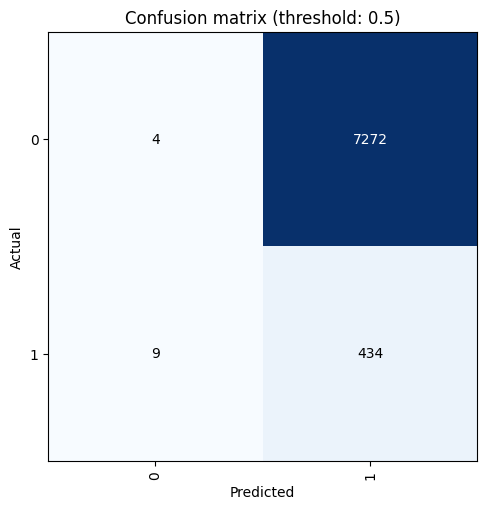

In [ ]:
from sklearn.metrics import f1_score

def show_probas(probas, test_preds, targets, figsize=(6,6),  **kwargs):
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)

    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    # class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    class_probas = np.array([probas[int(i)][int(t)] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, ['0','1'], fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()

def plot_confusion_matrix(probas, preds, targets, thr=.5, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2, figsize=(5,5),
                          title_fontsize=12, fontsize=10, plot_txt=True, **kwargs):
    from sklearn.metrics import confusion_matrix

    y_pred = (probas[:, 1] > thr).numpy().astype(int)
    y_test = targets
    if normalize: skm_normalize = 'true'
    else: skm_normalize = None
    cm = confusion_matrix(y_test, y_pred, normalize=skm_normalize)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=figsize, **kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(f"{title} (threshold: {thr})", fontsize=title_fontsize)

    labels = ['0','1']
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=fontsize)
    plt.yticks(tick_marks, labels, rotation=0, fontsize=fontsize)

    if plot_txt:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

    ax = fig.gca()
    ax.set_ylim(len(labels)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual', fontsize=fontsize)
    plt.xlabel('Predicted', fontsize=fontsize)
    plt.grid(False)

show_probas(test_probas, test_preds, y)
plot_confusion_matrix(test_probas, test_preds, y)

print(test_probas)

4 best performing channels per architecture:
inception: ['G-7', 'P-4', 'T-1', 'E-11']
TransformerLSTMPlus: ['G-7', 'T-1', 'E-1', 'E-12']
LSTMPlus: ['E-11', 'E-10', 'G-7', 'E-1']
XceptionTimePlus: ['G-7', 'P-4', 'T-1', 'E-11']
InceptionTimeXLPlus: ['E-11', 'E-10', 'G-7', 'P-4']
6 worst performing channels per architecture:
inception: ['E-12', 'E-10', 'E-13', 'E-1', 'P-1', 'T-3']
TransformerLSTMPlus: ['E-1', 'E-12', 'E-11', 'E-10', 'E-13', 'P-1']
LSTMPlus: ['E-13', 'P-1', 'P-4', 'T-3', 'E-12', 'T-1']
XceptionTimePlus: ['E-12', 'E-10', 'E-13', 'T-3', 'E-1', 'P-1']
InceptionTimeXLPlus: ['E-1', 'E-12', 'E-13', 'P-1', 'T-3', 'T-1']


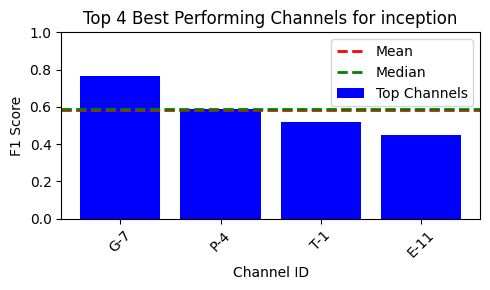

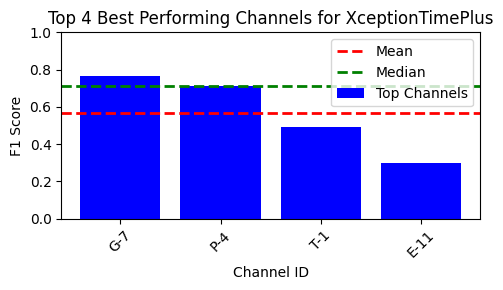

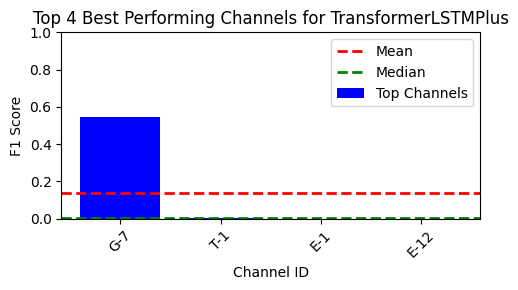

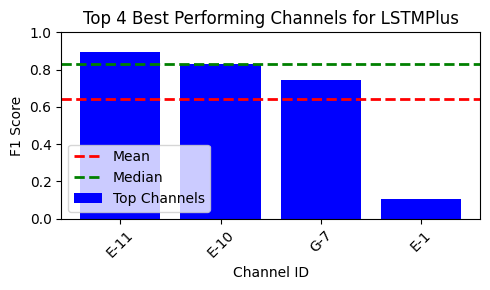

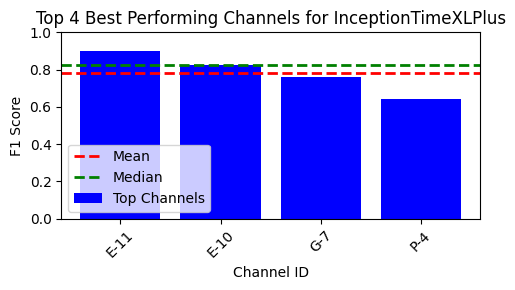

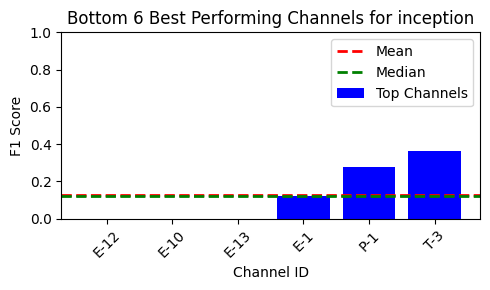

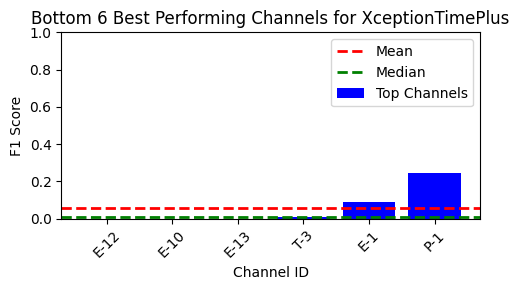

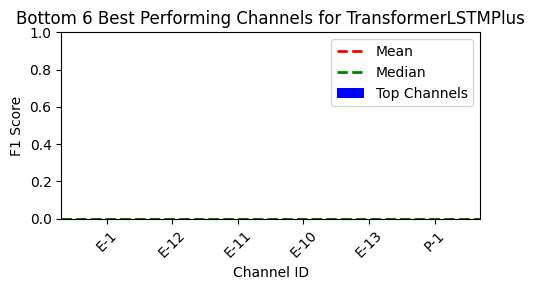

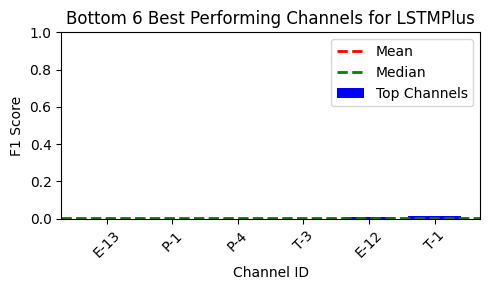

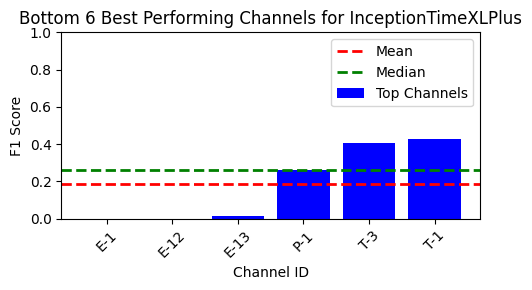


Consistently best performing channels:
G-7: 0.7167
E-11: 0.5081
P-4: 0.3883
E-10: 0.3316

Consistently worst performing channels:
E-12: 0.0017
E-13: 0.0031
E-1: 0.0639
T-3: 0.1560
P-1: 0.1566
T-1: 0.2909


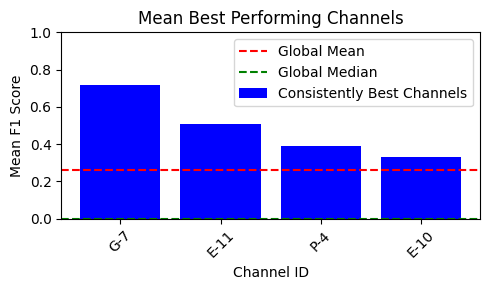

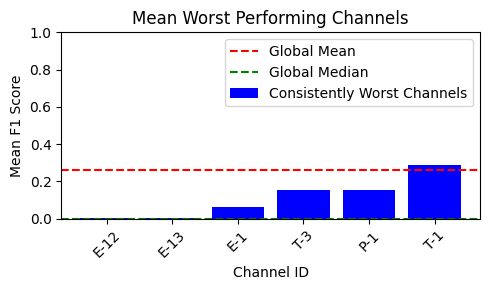

In [ ]:
###########################################
# Assess log files to find the best performing arch and data sets
logs = f"/content/drive/MyDrive/Colab Notebooks/data/logs/"

import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Set up a dictionary to store architecture-channel pairs and their scores
architecture_scores = defaultdict(list)
architecture_worst_scores = defaultdict(list)

top_n = 4  # Change this to the desired top_n value
bottom_n = 6

# Traverse the 'logs' directory
logs_directory = logs  # Change this to your logs directory
for log_file in os.listdir(logs_directory):
    if log_file.endswith('.csv'):
        log_path = os.path.join(logs_directory, log_file)

        # Read the CSV log file using pandas
        df = pd.read_csv(log_path, delimiter=',')

        # Extract relevant information from the log
        architecture = log_file.split('_')[0]
        anomaly_channel_id = log_file.split('_')[1]

        # Ignore multi-data-set logs for now
        if len(log_file.split('_')) == 3:
          best_f1_scores = df['f1_score'].nlargest(top_n)
          worst_f1_scores = df['f1_score'].nsmallest(bottom_n)

          # Store architecture-channel pair and scores
          architecture_scores[(architecture, anomaly_channel_id)].extend(best_f1_scores)
          architecture_worst_scores[(architecture, anomaly_channel_id)].extend(worst_f1_scores)

# Calculate the average scores for each architecture-channel pair
average_scores = {arch_chan: sum(scores) / len(scores) for arch_chan, scores in architecture_scores.items()}

# Print the top_n best performing channels per architecture
print(f"{top_n} best performing channels per architecture:")
top_channels = {}  # To store the top channels and their scores
printed_architectures = set()  # Keep track of architectures already printed
for architecture, _ in average_scores.keys():
    if architecture not in printed_architectures:
        channels = [chan for arch, chan in average_scores.keys() if arch == architecture]
        sorted_channels = sorted(channels, key=lambda x: average_scores[(architecture, x)], reverse=True)[:top_n]
        top_channels[architecture] = [(chan, average_scores[(architecture, chan)]) for chan in sorted_channels]
        print(f"{architecture}: {sorted_channels}")
        printed_architectures.add(architecture)

# Print the bottom_n worst performing channels per architecture
print(f"{bottom_n} worst performing channels per architecture:")
bottom_channels = {}  # To store the top channels and their scores
printed_architectures = set()  # Keep track of architectures already printed
for architecture, _ in average_scores.keys():
    if architecture not in printed_architectures:
        channels = [chan for arch, chan in average_scores.keys() if arch == architecture]
        sorted_channels = sorted(channels, key=lambda x: average_scores[(architecture, x)], reverse=False)[:bottom_n]
        bottom_channels[architecture] = [(chan, average_scores[(architecture, chan)]) for chan in sorted_channels]
        print(f"{architecture}: {sorted_channels}")
        printed_architectures.add(architecture)

# Create bar plots for each architecture showing F1 scores of top_n best performing channels
for architecture in printed_architectures:
    channels, scores = zip(*top_channels[architecture])
    mean_score = sum(scores) / top_n  # Calculate mean score
    median_score = sorted(scores)[top_n // 2]  # Calculate median score
    plt.figure(figsize=(10/2, 6/2))
    plt.bar(channels, scores, color='blue', label='Top Channels')
    plt.axhline(y=mean_score, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(y=median_score, color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.xlabel('Channel ID')
    plt.ylabel('F1 Score')
    plt.title(f'Top {top_n} Best Performing Channels for {architecture}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create bar plots for each architecture showing F1 scores of bottom_n best performing channels
for architecture in printed_architectures:
    channels, scores = zip(*bottom_channels[architecture])
    mean_score = sum(scores) / bottom_n  # Calculate mean score
    median_score = sorted(scores)[bottom_n // 2]  # Calculate median score
    plt.figure(figsize=(10/2, 6/2))
    plt.bar(channels, scores, color='blue', label='Top Channels')
    plt.axhline(y=mean_score, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(y=median_score, color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.xlabel('Channel ID')
    plt.ylabel('F1 Score')
    plt.title(f'Bottom {bottom_n} Best Performing Channels for {architecture}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
    plt.legend()
    plt.tight_layout()
    plt.show()

# Calculate the average F1 scores for each channel
channel_avg_scores = defaultdict(list)
for (architecture, channel_id), scores in architecture_scores.items():
    avg_score = sum(scores) / len(scores)
    channel_avg_scores[channel_id].append(avg_score)

# Calculate the overall average F1 score for each channel
overall_avg_scores = {channel_id: sum(scores) / len(scores) for channel_id, scores in channel_avg_scores.items()}

# Print the consistently best performing channels
best_channels_consistently = sorted(overall_avg_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
print(f"\nConsistently best performing channels:")
for channel_id, score in best_channels_consistently:
    print(f"{channel_id}: {score:.4f}")

# Print the consistently worst performing channels
worst_channels_consistently = sorted(overall_avg_scores.items(), key=lambda x: x[1], reverse=False)[:bottom_n]
print(f"\nConsistently worst performing channels:")
for channel_id, score in worst_channels_consistently:
    print(f"{channel_id}: {score:.4f}")

# Calculate the overall mean and median of all F1 scores
all_scores = [score for scores in architecture_scores.values() for score in scores]
global_mean = np.mean(all_scores)
global_median = np.median(all_scores)

# Plot consistently best performing channels
plt.figure(figsize=(10/2, 6/2))
plt.bar([channel_id for channel_id, _ in best_channels_consistently],
        [score for _, score in best_channels_consistently],
        color='b', label='Consistently Best Channels')

# Plot global mean and median
plt.axhline(global_mean, color='r', linestyle='--', label='Global Mean')
plt.axhline(global_median, color='g', linestyle='--', label='Global Median')

plt.xlabel('Channel ID')
plt.ylabel('Mean F1 Score')
plt.title('Mean Best Performing Channels')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
plt.legend()
plt.tight_layout()
plt.show()

# Plot consistently worst performing channels
plt.figure(figsize=(10/2, 6/2))
plt.bar([channel_id for channel_id, _ in worst_channels_consistently],
        [score for _, score in worst_channels_consistently],
        color='b', label='Consistently Worst Channels')

# Plot global mean and median
plt.axhline(global_mean, color='r', linestyle='--', label='Global Mean')
plt.axhline(global_median, color='g', linestyle='--', label='Global Median')

plt.xlabel('Channel ID')
plt.ylabel('Mean F1 Score')
plt.title('Mean Worst Performing Channels')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
plt.legend()
plt.tight_layout()
plt.show()

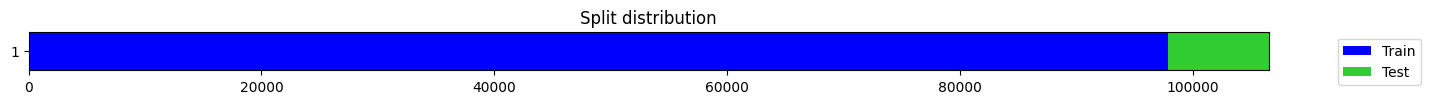

Better model found at epoch 0 with f1_score value: 0.14244064972927947.
Better model found at epoch 3 with f1_score value: 0.16105082809822957.
Better model found at epoch 4 with f1_score value: 0.17620706819313092.
Better model found at epoch 7 with f1_score value: 0.21540469973890336.


No improvement since epoch 7: early stopping

training time: 02:29:55


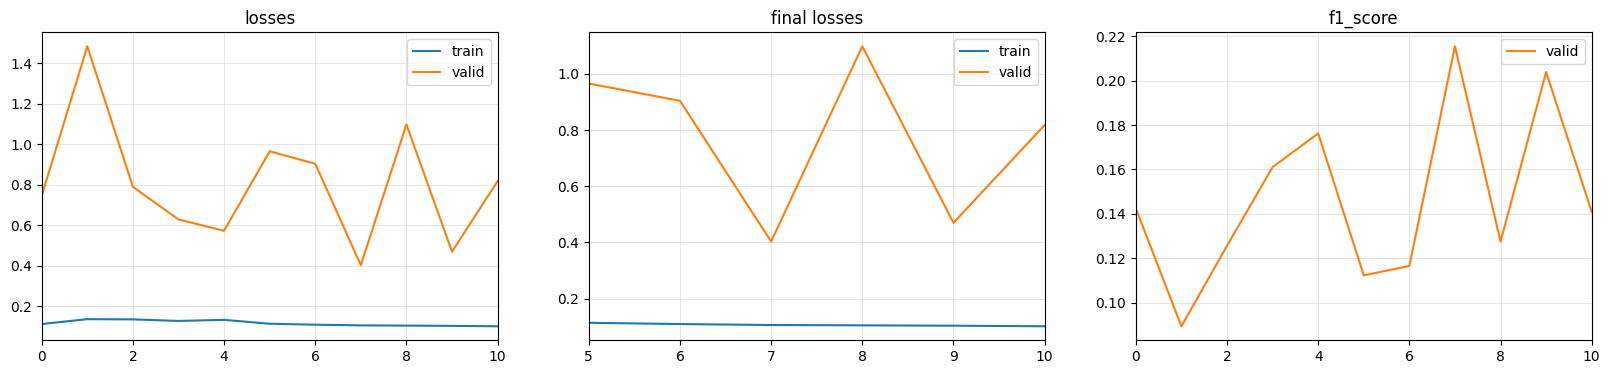

In [ ]:
import gc
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from tsai.all import *

from fastai.callback.all import *

dsets = None
dls = None

gc.collect()

SMAP_DS = [['A-1','A-2','A-3','A-4','A-5','A-6','A-7','A-8','A-9'],
           ['B-1'],
           ['D-1','D-11','D-12','D-13','D-2','D-3','D-4','D-5','D-6','D-7','D-8','D-9'],
           ['E-1','E-10','E-11','E-12','E-13','E-2','E-3','E-4','E-5','E-6','E-7','E-8','E-9'],
           ['F-1','F-2','F-3'],
           ['G-1','G-2','G-3','G-4','G-6','G-7'],
           ['P-1','P-2','P-2','P-3','P-4','P-7'],
           ['R-1'],
           ['S-1'],
           ['T-1','T-2','T-3']]

MSL_DS = [['C-1','C-2'],
          ['D-14','D-15','D-16'],
          ['F-4','F-5','F-7','F-8'],
          ['M-1','M-2','M-3','M-4','M-5','M-6','M-7'],
          ['P-10','P-11','P-14','P-15'],
          ['S-2'],
          ['T-12','T-13','T-4','T-5','T-8','T-9']]

labelled_data = "labelled_data"

ds = SMAP_DS
ts_type = 2 # D-x
ts_split = 8
train_sets = ds[ts_type][:ts_split]
test_sets = ds[ts_type+1][ts_split:]

train_len = 0
test_len = 0

# Start concatenating
arrays = []
for filename in train_sets:
  file_path = os.path.join(labelled_data, f'{filename}_lab.npy')
  data = np.load(file_path)
  arrays.append(data)

train_len = len(data)

for filename in test_sets:
  file_path = os.path.join(labelled_data, f'{filename}_lab.npy')
  data = np.load(file_path)
  arrays.append(data)

combined_array = np.concatenate(arrays, axis=0)

test_len = (len(combined_array) - train_len)

print(train_len, test_len)

# Args to SlidingWindow
window_length = 64
stride = window_length # no overlap
horizon = None
get_x = list(np.arange(combined_array.shape[1]-1))
get_y = data.shape[1]-1
seq_first = True
random_start = 0

# Apply sliding window
X,y = SlidingWindow(window_length, get_x = get_x, get_y=get_y)(combined_array)
splits = get_splits(y, valid_size=(test_len/(test_len+train_len)), stratify=True, random_state=23, shuffle=False)

tfms = [None, Categorize()]
batch_tfms = []
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)

epochs=10
model = InceptionTime(dls.vars, dls.c)

f1score = F1Score()
learn = Learner(dls, model, metrics=f1score)

# Load our saved weights
try:
  learn.load(weights)
except:
  print('Could not load weights from', weights)

start = time.time()
cbs = [EarlyStoppingCallback(monitor='f1_score', min_delta=0.01, patience=3),
       SaveModelCallback(monitor='f1_score', min_delta=0.01, fname=weights)]

learn.fit_one_cycle(25, lr_max=1e-3, cbs=cbs)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
learn.plot_metrics()

# save to gdrive
learn.export(model_export)


8354 90332


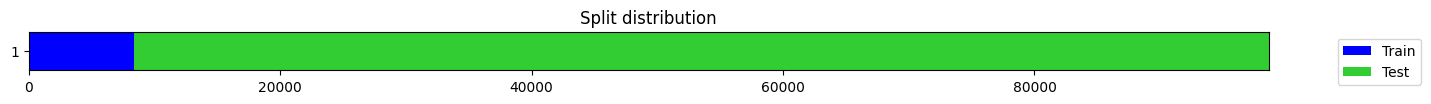

Could not load weights from /content/drive/MyDrive/Colab Notebooks/data/inception_weights2


Better model found at epoch 0 with f1_score value: 0.42713582144788903.
Better model found at epoch 1 with f1_score value: 0.48086109560146406.
No improvement since epoch 1: early stopping

training time: 00:22:53


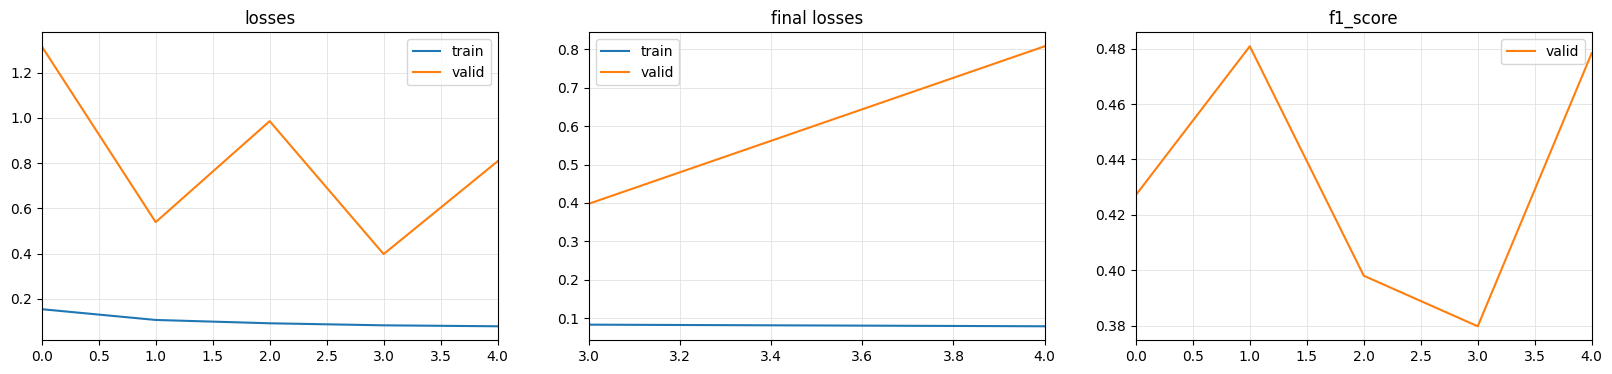

In [ ]:
import gc
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from tsai.all import *

from fastai.callback.all import *

dsets = None
dls = None

model_export = '/content/drive/MyDrive/Colab Notebooks/data/inception_model2.pkl'
weights = '/content/drive/MyDrive/Colab Notebooks/data/inception_weights2'

gc.collect()

SMAP_DS = [['A-1','A-2','A-3','A-4','A-5','A-6','A-7','A-8','A-9'],
           ['B-1'],
           ['D-1','D-11','D-12','D-13','D-2','D-3','D-4','D-5','D-6','D-7','D-8','D-9'],
           ['E-1','E-10','E-11','E-12','E-13','E-2','E-3','E-4','E-5','E-6','E-7','E-8','E-9'],
           ['F-1','F-2','F-3'],
           ['G-1','G-2','G-3','G-4','G-6','G-7'],
           ['P-1','P-2','P-2','P-3','P-4','P-7'],
           ['R-1'],
           ['S-1'],
           ['T-1','T-2','T-3']]

MSL_DS = [['C-1','C-2'],
          ['D-14','D-15','D-16'],
          ['F-4','F-5','F-7','F-8'],
          ['M-1','M-2','M-3','M-4','M-5','M-6','M-7'],
          ['P-10','P-11','P-14','P-15'],
          ['S-2'],
          ['T-12','T-13','T-4','T-5','T-8','T-9']]

labelled_data = "labelled_data"

ds = SMAP_DS
ts_type = 3 # E-x
ts_split = 8
train_sets = ds[ts_type][:ts_split]
test_sets = ds[ts_type-1][ts_split:]

train_len = 0
test_len = 0

# Start concatenating
arrays = []
for filename in train_sets:
  file_path = os.path.join(labelled_data, f'{filename}_lab.npy')
  data = np.load(file_path)
  arrays.append(data)

train_len = len(data)

for filename in test_sets:
  file_path = os.path.join(labelled_data, f'{filename}_lab.npy')
  data = np.load(file_path)
  arrays.append(data)

combined_array = np.concatenate(arrays, axis=0)

test_len = (len(combined_array) - train_len)

print(train_len, test_len)

# Args to SlidingWindow
window_length = 64
stride = window_length # no overlap
horizon = None
get_x = list(np.arange(combined_array.shape[1]-1))
get_y = data.shape[1]-1
seq_first = True
random_start = 0

# Apply sliding window
X,y = SlidingWindow(window_length, get_x = get_x, get_y=get_y)(combined_array)
splits = get_splits(y, valid_size=(test_len/(test_len+train_len)), stratify=True, random_state=23, shuffle=False)

tfms = [None, Categorize()]
batch_tfms = []
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)

epochs=10
model = InceptionTime(dls.vars, dls.c)

f1score = F1Score()
learn = Learner(dls, model, metrics=f1score)

# Load our saved weights
try:
  learn.load(weights)
except:
  print('Could not load weights from', weights)

start = time.time()
cbs = [EarlyStoppingCallback(monitor='f1_score', min_delta=0.01, patience=3),
       SaveModelCallback(monitor='f1_score', min_delta=0.01, fname=weights)]

learn.fit_one_cycle(25, lr_max=1e-3, cbs=cbs)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
learn.plot_metrics()

# save to gdrive
learn.export(model_export)


In [ ]:
import pandas as pd
import os

logs_dir = '/content/drive/MyDrive/Colab Notebooks/data/logs'

# List of architectures and channel IDs provided by the user.
architectures = ['XceptionTimePlus', 'xresnet34', 'xresnet34_pretrained']
channel_ids = ['E-1', 'E-12', 'E-11', 'E-10', 'E-13', 'G-7', 'P-1', 'P-4', 'T-1', 'T-3', 'C-1', 'D-14', 'C-2', 'F-7', 'P-11', 'T-13', 'T-8', 'T-9']  # Replace with actual channel IDs

# Initialize an empty DataFrame.
time_df = pd.DataFrame(columns=['Channel ID'] + architectures)

# Loop over each architecture and channel ID.
for chan_id in channel_ids:
    row = {'Channel ID': chan_id}
    for arch in architectures:
        # Construct the file name and check if it exists.
        file_name = f"{logs_dir}/{arch}_{chan_id}_log.csv"
        if os.path.isfile(file_name):
            # Read the CSV file.
            df = pd.read_csv(file_name)
            # Convert the 'time' column to timedelta objects.
            df['time'] = pd.to_timedelta('00:' + df['time'] + '.5')
            # Calculate the total time and add it to the row dictionary.
            total_time = df['time'].sum()
            # Format total time back to 'mm:ss' format for display.
            total_minutes = total_time.components.minutes + total_time.components.hours * 60
            total_seconds = total_time.components.seconds
            row[arch] = f'{total_minutes:02d}:{total_seconds:02d}'
            print(chan_id, arch, row[arch])
        else:
            row[arch] = None  # In case the file does not exist.
    # Append the row to the DataFrame.
    time_df = pd.concat([time_df, pd.DataFrame([row])], ignore_index=True)

# Add the final row with the sums for each architecture.
#total_row = {col: time_df[col].sum() for col in time_df.columns if col != 'Channel ID'}
#total_row['Channel ID'] = 'Total'
#time_df = pd.concat([time_df, pd.DataFrame([total_row])], ignore_index=True)


# Save the resulting DataFrame as a CSV file.
time_df.to_csv('summary_times.csv', index=False)


E-1 XceptionTimePlus 00:29
E-1 xresnet34 44:05
E-1 xresnet34_pretrained 43:15
E-12 XceptionTimePlus 00:18
E-12 xresnet34 43:30
E-12 xresnet34_pretrained 43:21
E-11 XceptionTimePlus 00:23
E-11 xresnet34 43:45
E-11 xresnet34_pretrained 43:01
E-10 XceptionTimePlus 00:35
E-10 xresnet34 43:45
E-10 xresnet34_pretrained 43:27
E-13 XceptionTimePlus 00:24
E-13 xresnet34 83:46
E-13 xresnet34_pretrained 10:39
G-7 XceptionTimePlus 00:49
G-7 xresnet34 81:49
G-7 xresnet34_pretrained 66:00
P-1 XceptionTimePlus 00:48
P-1 xresnet34 49:25
P-1 xresnet34_pretrained 49:06
P-4 XceptionTimePlus 00:21
P-4 xresnet34 66:38
P-4 xresnet34_pretrained 53:34
T-1 XceptionTimePlus 01:02
T-1 xresnet34 87:50
T-1 xresnet34_pretrained 88:13
T-3 XceptionTimePlus 00:25
T-3 xresnet34 49:56
T-3 xresnet34_pretrained 49:14
C-1 XceptionTimePlus 00:06
C-1 xresnet34_pretrained 36:27
D-14 XceptionTimePlus 00:11
D-14 xresnet34_pretrained 24:31
C-2 XceptionTimePlus 00:06
C-2 xresnet34_pretrained 20:39
F-7 XceptionTimePlus 00:38
F-7 x